In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d
import scipy as sp
pd.set_option("display.max_columns", None)
from tqdm import tqdm
tqdm.pandas()

In [44]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# DATA CLEANING AND WRANGLING

### Data Cleaning

In [45]:
# DF1 = Total and facet scores, and score per question
df00 = pd.read_csv('Indian Risk Literacy DYNATA_normal launch_2.csv')[26:]
print(len(df00["ResponseId"]))

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print(len(df01["ResponseId"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print(len(df01["ResponseId"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(dict)
df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print(len(df01["ResponseId"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print(len(df01["ResponseId"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print(len(df01["ResponseId"]))

4443
963
961
846
846
699


In [46]:
df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "ResponseId", range(0, len(df0)))
df0

ResponseId      Q1  Q2                     Q3  \
0             0    Male  30  Post-Graduate Program   
1             1    Male  53  Post-Graduate Program   
2             2    Male  43  Undergraduate Program   
3             3    Male  32  Undergraduate Program   
4             4  Female  31  Post-Graduate Program   
..          ...     ...  ..                    ...   
694         694  Female  44       Ph.D. and higher   
695         695    Male  37  Post-Graduate Program   
696         696    Male  41  Post-Graduate Program   
697         697    Male  33  Post-Graduate Program   
698         698    Male  34  Post-Graduate Program   

                             Q4a             Q4.5_4             Q4.5_5  \
0                       Salaried         Financial             Health    
1                       Salaried       unemployment     global warming   
2    Entrepreneur/Business Owner          financial             health   
3                       Salaried  Make my business   Personal finance    
4                       Salaried            economy       job security   
..                           ...                ...                ...   
694                     Salaried     Financial risk        Health risk   
695  Entrepreneur/Business Owner              Money             House    
696                     Salaried          inflation           security   
697                     Salaried          Planning             Target    
698                     Salaried         Inflation               Noise   

                                     Q4.5_6                      Q5_1  \
0                                 Politics                          5   
1                                 terrorism                         5   
2    rising prices of essential commodities                         6   
3                            Health issues   7 (willing to take risk)   
4                           gender equality                         6   
..                                      ...                       ...   
694                             Career risk                         3   
695                                  Health                         6   
696               high prices of education   7 (willing to take risk)   
697                                Working   7 (willing to take risk)   
698                              Pollution                          5   

                        Q6 - changed  Q8_1  Q8_2  Q8_3  Q8_4  Q8_5  Q8_6  \
0             Rather much experience     5     5     5     6     6     6   
1                    Some experience     4     2     2     5     5     5   
2                    Some experience     5     4     5     4     5     5   
3    Definitely very much experience     6     5     5     6     6     5   
4    Definitely very much experience     4     5     4     5     6     6   
..                               ...   ...   ...   ...   ...   ...   ...   
694                  Some experience     5     5     3     2     3     5   
695  Definitely very much experience     5     4     5     5     5     6   
696  Definitely very much experience     6     6     6     6     6     5   
697  Definitely very much experience     5     6     6     6     6     5   
698                  Some experience     5     5     4     3     4     5   

     Q8_7  Q8_8 Q9b_1 Q9b_4 Q9b_10 Q9b_5 Q9b_11 Q9b_12 Q9b_6 Q9b_7 Q9b_8  \
0       5     6    25    15     10     0      0      0     0    15    15   
1       4     6    10    10      0     0      0      0     0    10     0   
2       5     4    80    20      0     0      0      0     0     0     0   
3       6     6    10     5      5     5      0      0     0    40     5   
4       5     5    20    25      5     5      5      5     1     5     5   
..    ...   ...   ...   ...    ...   ...    ...    ...   ...   ...   ...   
694     5     5    10    10      5     0      0      0     0    50     5   
695     6     4    30    10      1     1      1      1     1    35   

In [47]:
df00.to_csv("Indian Risk Literacy Survey_Dynata_unfiltered v060525.csv")

In [48]:
df0.to_csv("Indian Risk Literacy Survey_Dynata_filtered v060525.csv")

## Demographics

In [49]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b"].astype(float).copy()

In [50]:
df0["Q15a"].value_counts()

Q15a
INR 500,001 – INR 15,00,000      221
< INR 500,000                    194
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42
Name: count, dtype: int64

In [51]:
df0["Q1"].count()

699

In [52]:
df0["Q1"].value_counts()

Q1
Male      361
Female    338
Name: count, dtype: int64

In [53]:
df0["Q3"].value_counts()

Q3
Post-Graduate Program                   225
Undergraduate Program                   206
Secondary School (11th to 12th Std.)    177
Diploma and Vocational Training          35
Primary School (up to 10th Std.)         29
Ph.D. and higher                         16
M.Phil.                                  11
Name: count, dtype: int64

In [54]:
df0["isced"].value_counts()

isced
1    252
2    241
3    206
Name: count, dtype: int64

In [55]:
df0["Q4a"].value_counts()

Q4a
Salaried                       490
Entrepreneur/Business Owner    129
Currently not employed          68
Retired                         12
Name: count, dtype: int64

In [56]:
df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]]

Q15a
< INR 500,000                    194
INR 500,001 – INR 15,00,000      221
INR 1500,001 – INR 30,00,000     114
INR 30,00,001 – INR 50,00,000     76
INR 50,00,001 – INR 75,00,000     52
> INR 75,00,000                   42
Name: count, dtype: int64

In [57]:
df0["income"].value_counts().sort_index()

#   < INR 500,000                      --> 1
#     INR 500,001 – INR 15,00,000      --> 2
#     INR 1500,001 – INR 30,00,000     --> 3
#     INR 30,00,001 – INR 50,00,000    --> 4
#     INR 50,00,001 – INR 75,00,000    --> 5
#   > INR 75,00,000 

income
1    194
2    221
3    114
4     76
5     52
6     42
Name: count, dtype: int64

## Winsorizing Income and Wealth

In [58]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

df0["winsorized_wealth"] = winsorize(np.array(df0["wealth"]), limits = [0.1, 0.1], inclusive = [False, False])

In [59]:
df0.describe()

C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
C:\Users\SHIVAM\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


ResponseId        Q8_1        Q8_2        Q8_3        Q8_4        Q8_5  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean   349.000000    4.589413    4.522175    4.552217    4.429185    4.669528   
std    201.928205    1.270765    1.259011    1.244382    1.314044    1.241972   
min      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%    174.500000    4.000000    4.000000    4.000000    4.000000    4.000000   
50%    349.000000    5.000000    5.000000    5.000000    5.000000    5.000000   
75%    523.500000    6.000000    5.000000    6.000000    5.000000    6.000000   
max    698.000000    6.000000    6.000000    6.000000    6.000000    6.000000   

             Q8_6        Q8_7        Q8_8         age     age_rec       isced  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean     4.712446    4.483548    4.542203   35.194564    2.456366    1.934192   
std      1.206003    1.337449    1.381159   11.327980    0.614322    0.807356   
min      1.000000    1.000000    1.000000   18.000000    2.000000    1.000000   
25%      4.000000    4.000000    4.000000   27.000000    2.000000    1.000000   
50%      5.000000    5.000000    5.000000   33.000000    2.000000    2.000000   
75%      6.000000    6.000000    6.000000   42.000000    3.000000    3.000000   
max      6.000000    6.000000    6.000000   75.000000    4.000000    3.000000   

           income        wealth  winsorized_wealth  
count  699.000000  6.990000e+02       6.990000e+02  
mean     2.566524  1.628566e+08       3.129498e+06  
std      1.479398  3.794346e+09       4.770219e+06  
min      1.000000  0.000000e+00       5.000000e+03  
25%      1.000000  1.000000e+05       1.000000e+05  
50%      2.000000  6.000000e+05       6.000000e+05  
75%      3.000000  4.000000e+06       4.000000e+06  
max      6.000000  1.000000e+11       1.500000e+07

C:\Users\SHIVAM\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\SHIVAM\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


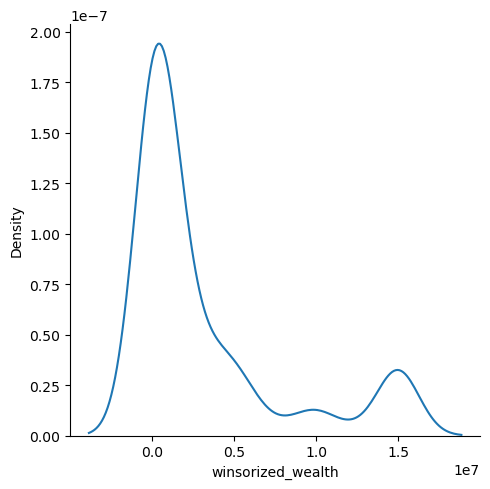

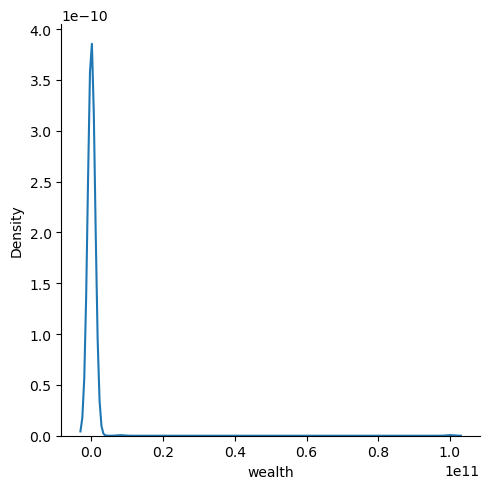

In [60]:
# WEALTH - winsorized, and non winsorized
sns.displot(data = df0["winsorized_wealth"], kind = "kde")
sns.displot(data = df0["wealth"], kind = "kde")

## Questions

In [61]:
matchCol = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5", "q8_3", "q8_4", "q8_5berlin_1", 
            "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7", "q9_1_1", "q9_2_1", "q9_3",
            "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]
df0[ matchCol ] = 0

In [62]:
df0.columns

Index(['ResponseId', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_5', 'Q9b_11', 'Q9b_12',
       'Q9b_6', 'Q9b_7', 'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b',
       'Q11a_1', 'Q11a_2', 'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4',
       'Q11b_5', 'Q11c', 'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a',
       'Q13b', 'Q13c', 'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1',
       'Q14c', 'Q54', 'Q57', 'Q58', 'Q15a', 'psid', 'age', 'age_rec', 'isced',
       'income', 'wealth', 'winsorized_wealth', 'q8_2_1', 'q8_2_2', 'q8_2_3',
       'q8_2_4', 'q8_2_5', 'q8_3', 'q8_4', 'q8_5berlin_1', 'q8_5london_1',
       'q8_5paris_1', 'q8_6', 'q8_7', 'q9_1_1', 'q9_2_1', 'q9_3', 'q10_1_1',
       'q10_2_1', 'q10_3_1', 'q10_4'],
      dtype='object')

In [63]:
df0["Q11b_1"].value_counts()

Q11b_1
Yes    391
No     308
Name: count, dtype: int64

In [64]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [65]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [66]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

## Scoring

In [67]:
scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5", "uncertainty1", "uncertainty2", "numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5", "graph1", "graph2", "graph3", "riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5", "bayesian1"]
df0[scoreColumns] = 0

In [68]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [70]:
df10 = df0.groupby(["ResponseId"]).progress_apply(scoring1)
df10 = df10.reset_index(drop = True).dropna().copy()
df10

100%|███████████████████████████████████████████████████████████████████████████████| 699/699 [00:02<00:00, 295.04it/s]


ResponseId      Q1  Q2                     Q3  \
0             0    Male  30  Post-Graduate Program   
1             1    Male  53  Post-Graduate Program   
2             2    Male  43  Undergraduate Program   
3             3    Male  32  Undergraduate Program   
4             4  Female  31  Post-Graduate Program   
..          ...     ...  ..                    ...   
694         694  Female  44       Ph.D. and higher   
695         695    Male  37  Post-Graduate Program   
696         696    Male  41  Post-Graduate Program   
697         697    Male  33  Post-Graduate Program   
698         698    Male  34  Post-Graduate Program   

                             Q4a             Q4.5_4             Q4.5_5  \
0                       Salaried         Financial             Health    
1                       Salaried       unemployment     global warming   
2    Entrepreneur/Business Owner          financial             health   
3                       Salaried  Make my business   Personal finance    
4                       Salaried            economy       job security   
..                           ...                ...                ...   
694                     Salaried     Financial risk        Health risk   
695  Entrepreneur/Business Owner              Money             House    
696                     Salaried          inflation           security   
697                     Salaried          Planning             Target    
698                     Salaried         Inflation               Noise   

                                     Q4.5_6                      Q5_1  \
0                                 Politics                          5   
1                                 terrorism                         5   
2    rising prices of essential commodities                         6   
3                            Health issues   7 (willing to take risk)   
4                           gender equality                         6   
..                                      ...                       ...   
694                             Career risk                         3   
695                                  Health                         6   
696               high prices of education   7 (willing to take risk)   
697                                Working   7 (willing to take risk)   
698                              Pollution                          5   

                        Q6 - changed  Q8_1  Q8_2  Q8_3  Q8_4  Q8_5  Q8_6  \
0             Rather much experience     5     5     5     6     6     6   
1                    Some experience     4     2     2     5     5     5   
2                    Some experience     5     4     5     4     5     5   
3    Definitely very much experience     6     5     5     6     6     5   
4    Definitely very much experience     4     5     4     5     6     6   
..                               ...   ...   ...   ...   ...   ...   ...   
694                  Some experience     5     5     3     2     3     5   
695  Definitely very much experience     5     4     5     5     5     6   
696  Definitely very much experience     6     6     6     6     6     5   
697  Definitely very much experience     5     6     6     6     6     5   
698                  Some experience     5     5     4     3     4     5   

     Q8_7  Q8_8 Q9b_1 Q9b_4 Q9b_10 Q9b_5 Q9b_11 Q9b_12 Q9b_6 Q9b_7 Q9b_8  \
0       5     6    25    15     10     0      0      0     0    15    15   
1       4     6    10    10      0     0      0      0     0    10     0   
2       5     4    80    20      0     0      0      0     0     0     0   
3       6     6    10     5      5     5      0      0     0    40     5   
4       5     5    20    25      5     5      5      5     1     5     5   
..    ...   ...   ...   ...    ...   ...    ...    ...   ...   ...   ...   
694     5     5    10    10      5     0      0      0     0    50     5   
695     6     4    30    10      1     1      1      1     1    35   

In [71]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_2"] = survey["numeracy1"] + survey["numeracy2"] # + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_18"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_2"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_2"] / 2 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_18"] / 18 * 100
    
    
    colReq = ["ResponseId", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_2", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
              "TotalScore_18", "TotalScore_%",]
    
    survey1 = survey[colReq].copy()
    return survey1

In [72]:
df11 = scoring2(df10)
df11

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1             1  53.0        3      1       4   9000000.0            4   
2             2  43.0        3      2       1   2200000.0            4   
3             3  32.0        2      2       3   8000000.0            4   
4             4  31.0        2      1       3  35000000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         694  44.0        3      1       2   5000000.0            4   
695         695  37.0        3      1       2   3000000.0            4   
696         696  41.0        3      1       2   2500000.0            5   
697         697  33.0        2      1       2    100000.0            2   
698         698  34.0        2      1       2     65000.0            2   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
0                0                    1                2           1   
1                0                    2                1           0   
2                1                    3                3           2   
3                0                    1                1           2   
4                1                    2                1           1   
..             ...                  ...              ...         ...   
694              2                    4                2           2   
695              1                    2                1           2   
696              0                    1                2           1   
697              0                    3                2           0   
698              0                    1                0           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1         80.0            0.0                 40.0   
2                      0         80.0           50.0                 60.0   
3                      0         80.0            0.0                 20.0   
4                      0         60.0           50.0                 40.0   
..                   ...          ...            ...                  ...   
694                    0         80.0          100.0                 80.0   
695                    0         80.0           50.0                 40.0   
696                    0        100.0            0.0                 20.0   
697                    0         40.0            0.0                 60.0   
698                    0         40.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
0          66.666667        50.0                100.0              7   
1          33.333333         0.0                100.0              8   
2         100.000000       100.0                  0.0             13   
3          33.333333       100.0                  0.0              8   
4          33.333333        50.0                  0.0              8   
..               ...         ...                  ...            ...   
694        66.666667       100.0                  0.0             14   
695        33.333333       100.0                  0.0             10   
696        66.666667        50.0                  0.0              9   
697        66.666667         0.0                  0.0              7   
698         0.000000         0.0                  0.0              3   

     TotalScore_%  
0       38.888889  
1       44.444444  
2       72.222222  
3       44.444444  
4       44.444444  
..            ...  
694     77.777778  
695     55.555556  
696     50.000000  
697     38.888889  
698     16.666667  

[699 rows x 20 columns]

In [73]:
df2 = df11.copy()

In [74]:
df2

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1             1  53.0        3      1       4   9000000.0            4   
2             2  43.0        3      2       1   2200000.0            4   
3             3  32.0        2      2       3   8000000.0            4   
4             4  31.0        2      1       3  35000000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         694  44.0        3      1       2   5000000.0            4   
695         695  37.0        3      1       2   3000000.0            4   
696         696  41.0        3      1       2   2500000.0            5   
697         697  33.0        2      1       2    100000.0            2   
698         698  34.0        2      1       2     65000.0            2   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
0                0                    1                2           1   
1                0                    2                1           0   
2                1                    3                3           2   
3                0                    1                1           2   
4                1                    2                1           1   
..             ...                  ...              ...         ...   
694              2                    4                2           2   
695              1                    2                1           2   
696              0                    1                2           1   
697              0                    3                2           0   
698              0                    1                0           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1         80.0            0.0                 40.0   
2                      0         80.0           50.0                 60.0   
3                      0         80.0            0.0                 20.0   
4                      0         60.0           50.0                 40.0   
..                   ...          ...            ...                  ...   
694                    0         80.0          100.0                 80.0   
695                    0         80.0           50.0                 40.0   
696                    0        100.0            0.0                 20.0   
697                    0         40.0            0.0                 60.0   
698                    0         40.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
0          66.666667        50.0                100.0              7   
1          33.333333         0.0                100.0              8   
2         100.000000       100.0                  0.0             13   
3          33.333333       100.0                  0.0              8   
4          33.333333        50.0                  0.0              8   
..               ...         ...                  ...            ...   
694        66.666667       100.0                  0.0             14   
695        33.333333       100.0                  0.0             10   
696        66.666667        50.0                  0.0              9   
697        66.666667         0.0                  0.0              7   
698         0.000000         0.0                  0.0              3   

     TotalScore_%  
0       38.888889  
1       44.444444  
2       72.222222  
3       44.444444  
4       44.444444  
..            ...  
694     77.777778  
695     55.555556  
696     50.000000  
697     38.888889  
698     16.666667  

[699 rows x 20 columns]

# GRAPHS

<Axes: title={'center': 'Frequency of Scores'}, xlabel='TotalScore_18', ylabel='Frequency'>

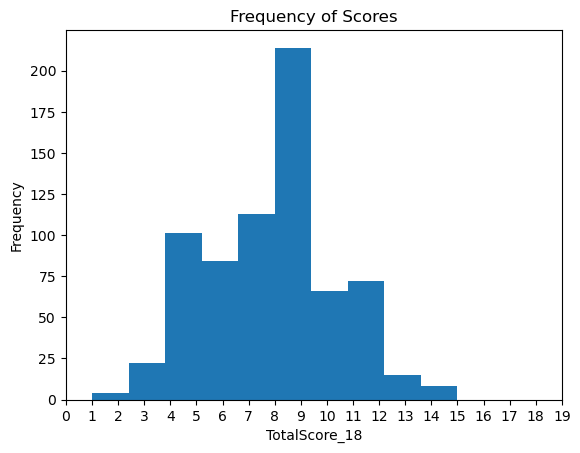

In [75]:
# The following graph represents frequency of each data point on "TotalScore_18" or the total score out of 13 questions across the sample.

df2['TotalScore_18'].plot(kind = 'hist', xticks = np.arange(0, 20, step=1), xlabel = 'TotalScore_18', title = 'Frequency of Scores' )

<Axes: title={'center': 'Absolute mean of scores for above data set'}>

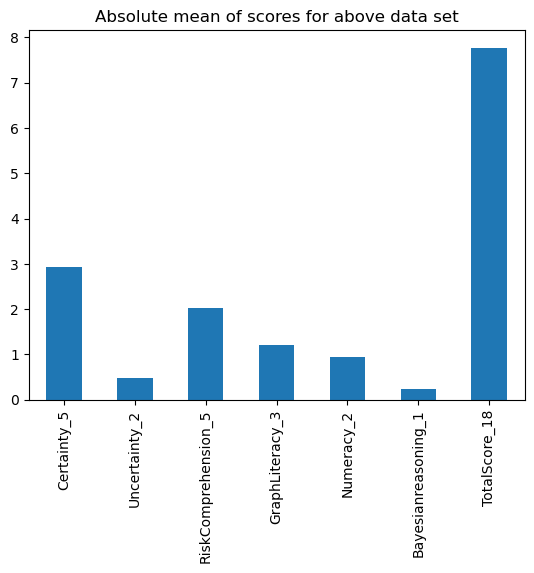

In [76]:
# Absolute mean scores for each facet

(df2[['Certainty_5', 'Uncertainty_2', 'RiskComprehension_5','GraphLiteracy_3','Numeracy_2','Bayesianreasoning_1','TotalScore_18']].mean(axis = 0)).plot(kind = 'bar', title = 'Absolute mean of scores for above data set')

<Axes: title={'center': '% mean of scores for above data set'}>

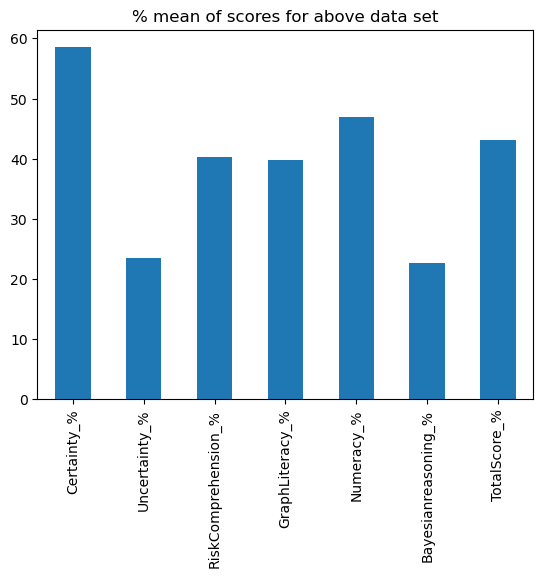

In [77]:
# Normalised mean scores for each facet

df2[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean(axis = 0).plot(kind = 'bar', title = '% mean of scores for above data set')

# ISCED

In [78]:
# Data Frame 5 or df5 is an aggregate data on facet total scores and over all total score, along with  education data vs each response. 
# This data set is now sorted by education.

df5 = df2.sort_values(by = 'isced')
df5 = df5.reset_index(drop = True)

df5

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1           599  35.0        2      1       3   2000000.0            5   
2           598  27.0        2      1       5  20000000.0            2   
3           597  45.0        3      1       3   5000000.0            2   
4           596  40.0        3      1       6    500000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         365  26.0        2      3       1   4000000.0            3   
695         364  28.0        2      3       3    100000.0            2   
696         363  20.0        2      3       2    140000.0            5   
697         361  75.0        4      3       1   2000000.0            2   
698         349  37.0        3      3       2  15000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
0                0                    1                2           1   
1                0                    2                2           2   
2                0                    2                1           2   
3                0                    2                1           1   
4                0                    3                1           0   
..             ...                  ...              ...         ...   
694              0                    2                0           0   
695              0                    2                2           2   
696              0                    2                0           0   
697              0                    2                2           0   
698              0                    1                1           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1        100.0            0.0                 40.0   
2                      1         40.0            0.0                 40.0   
3                      0         40.0            0.0                 40.0   
4                      0         60.0            0.0                 60.0   
..                   ...          ...            ...                  ...   
694                    0         60.0            0.0                 40.0   
695                    0         40.0            0.0                 40.0   
696                    0        100.0            0.0                 40.0   
697                    0         40.0            0.0                 40.0   
698                    0          0.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
0          66.666667        50.0                100.0              7   
1          66.666667       100.0                100.0             12   
2          33.333333       100.0                100.0              8   
3          33.333333        50.0                  0.0              6   
4          33.333333         0.0                  0.0              7   
..               ...         ...                  ...            ...   
694         0.000000         0.0                  0.0              5   
695        66.666667       100.0                  0.0              8   
696         0.000000         0.0                  0.0              7   
697        66.666667         0.0                  0.0              6   
698        33.333333         0.0                  0.0              2   

     TotalScore_%  
0       38.888889  
1       66.666667  
2       44.444444  
3       33.333333  
4       38.888889  
..            ...  
694     27.777778  
695     44.444444  
696     38.888889  
697     33.333333  
698     11.111111  

[699 rows x 20 columns]

In [79]:
# Mean of each facet as a % for each category of isced

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean()

Certainty_%  Uncertainty_%  RiskComprehension_%  Numeracy_%  \
isced                                                                
1        63.730159      21.428571            40.396825   51.388889   
2        56.348548      24.066390            39.419087   50.000000   
3        54.660194      25.485437            41.262136   37.864078   

       GraphLiteracy_%  Bayesianreasoning_%  
isced                                        
1            44.841270            23.015873  
2            40.387275            22.406639  
3            33.171521            22.330097

In [80]:
# Count of responses for each category isced

df5.groupby('isced')[['ResponseId']].count()

ResponseId
isced            
1             252
2             241
3             206

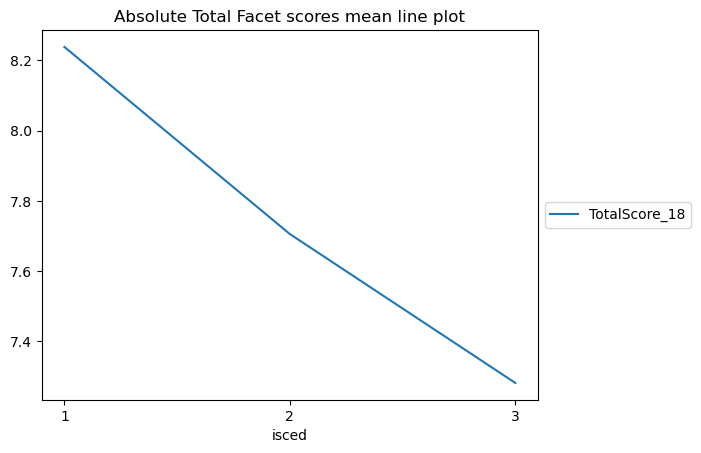

In [81]:
# Absolute Total Facet scores mean line plot from low to high ISCED

df5.groupby('isced')[['TotalScore_18']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

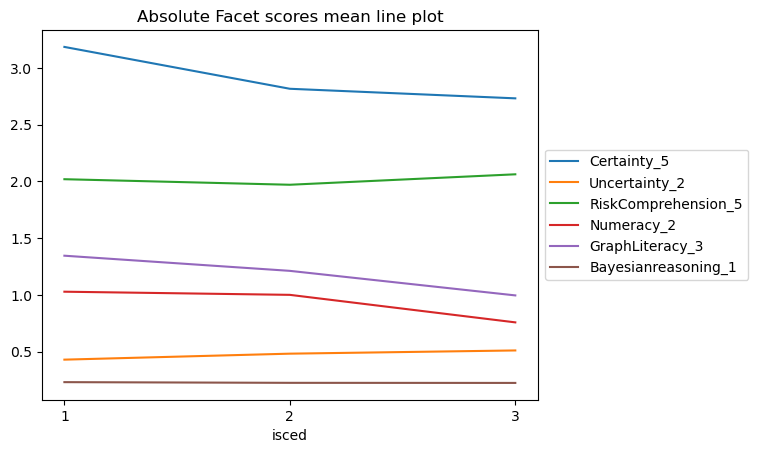

In [82]:
# Absolute Facet scores mean line plot from low to high edu

df5.groupby('isced')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_2','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

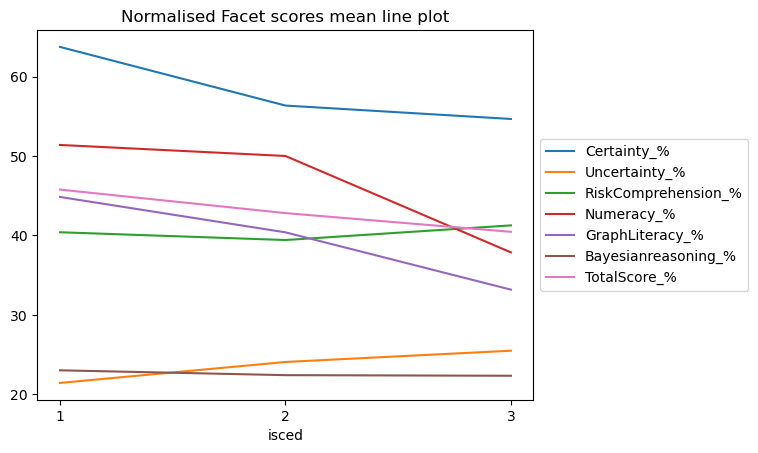

In [83]:
# Normalised Facet scores mean line plot from low to high edu


df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = 'Normalised Facet scores mean line plot', xticks = np.arange(1,4, step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

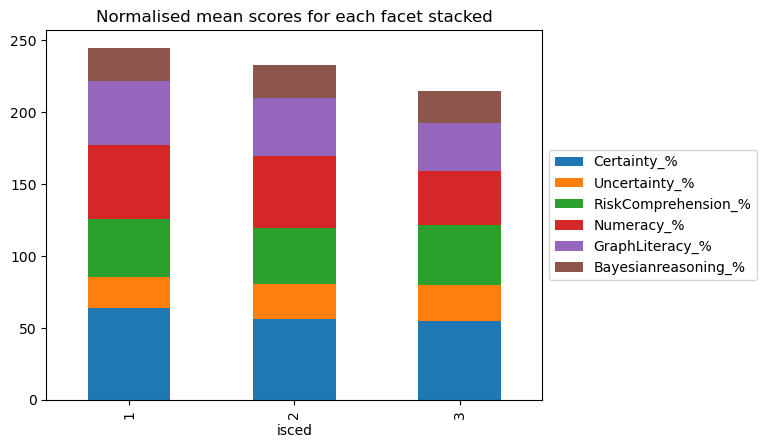

In [84]:
# Normalised mean scores for each facet stacked

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = 'Normalised mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

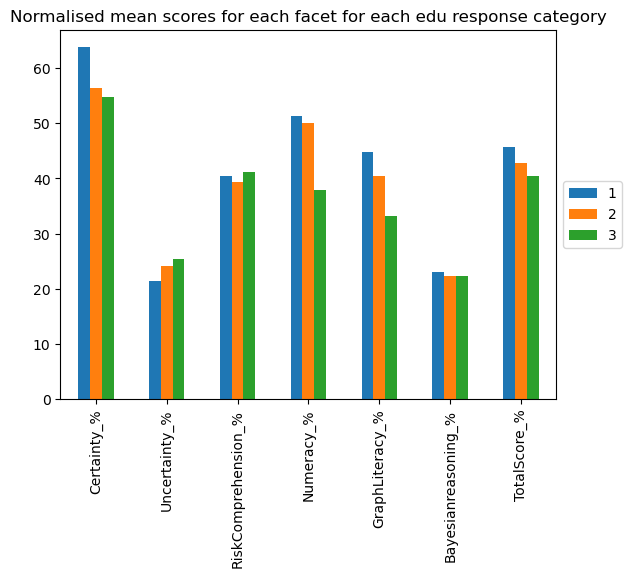

In [85]:
# Normalised mean scores for each facet for each edu response category

df5.groupby('isced')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = 'Normalised mean scores for each facet for each edu response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='isced', ylabel='TotalScore_18'>

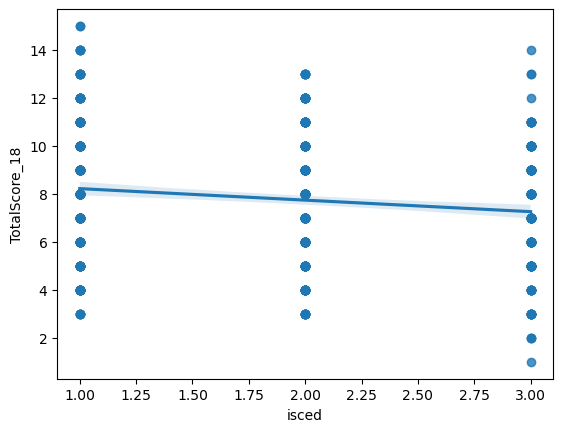

In [86]:
# Trend line for Absolute Total Facet Score vs edu (isced) reponses

sns.regplot (data = df5, x = 'isced', y = 'TotalScore_18')

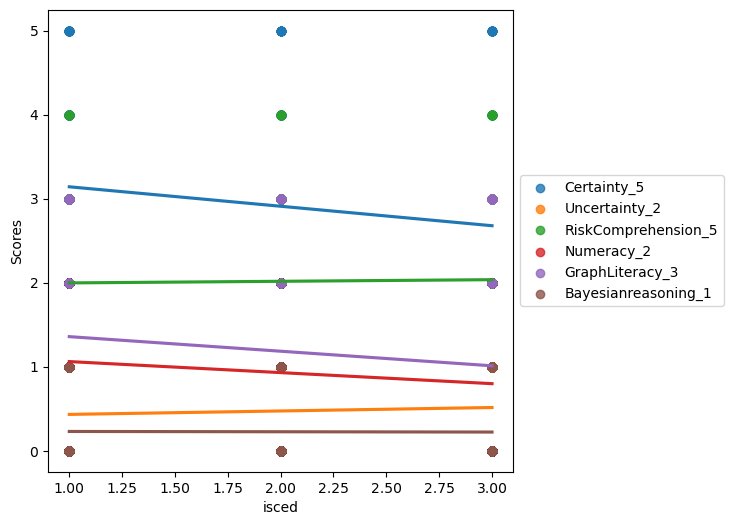

In [87]:
# Trend line for Absolute Independent Facet Score vs edu (isced) reponses

fig, ax6 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df5, x = 'isced', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax6, label='Certainty_5')
sns.regplot (data = df5, x = 'isced', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax6, label='Uncertainty_2')
sns.regplot (data = df5, x = 'isced', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax6, label='RiskComprehension_5')
sns.regplot (data = df5, x = 'isced', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax6, label='Numeracy_2')
sns.regplot (data = df5, x = 'isced', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax6, label='GraphLiteracy_3')
sns.regplot (data = df5, x = 'isced', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax6, label='Bayesianreasoning_1' )

ax6.set(ylabel='Scores', xlabel='isced')
ax6.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='isced', ylabel='TotalScore_18'>

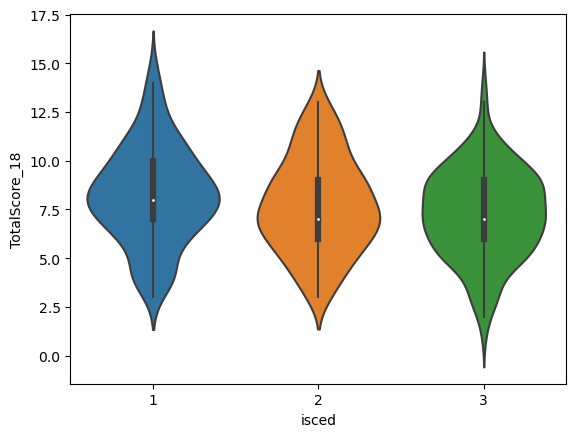

In [88]:
# Violine Plot for TotalScore_18 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'TotalScore_18')

<Axes: xlabel='isced', ylabel='Certainty_5'>

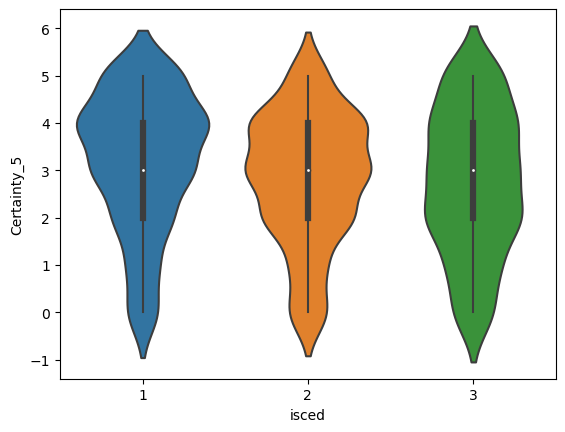

In [89]:
# Violine Plot for Certainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Certainty_5')

<Axes: xlabel='isced', ylabel='Uncertainty_2'>

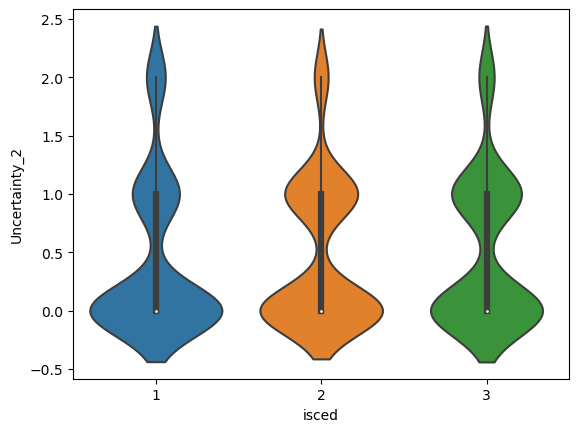

In [90]:
# Violine Plot for Uncertainty_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Uncertainty_2')

<Axes: xlabel='isced', ylabel='RiskComprehension_5'>

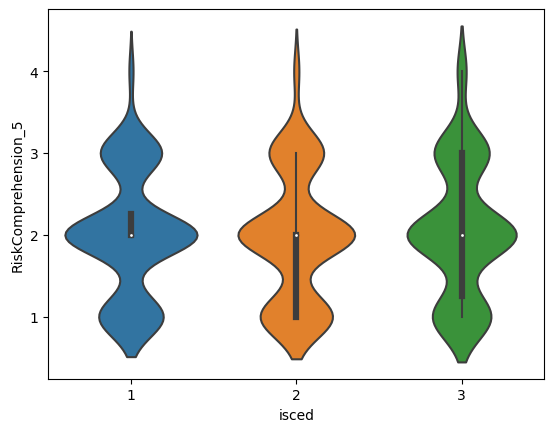

In [91]:
# Violine Plot for RiskComprehension_5 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'RiskComprehension_5')

<Axes: xlabel='isced', ylabel='GraphLiteracy_3'>

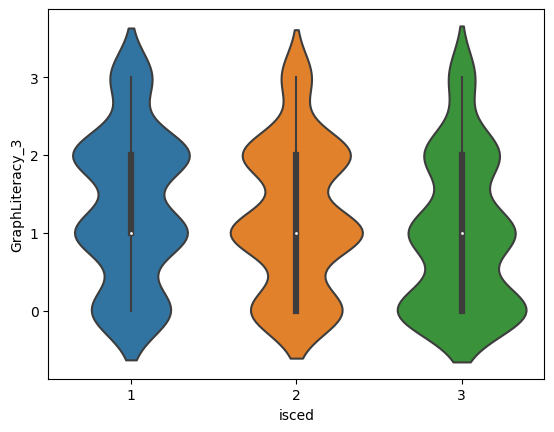

In [92]:
# Violine Plot for GraphLiteracy_3 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'GraphLiteracy_3')

<Axes: xlabel='isced', ylabel='Numeracy_2'>

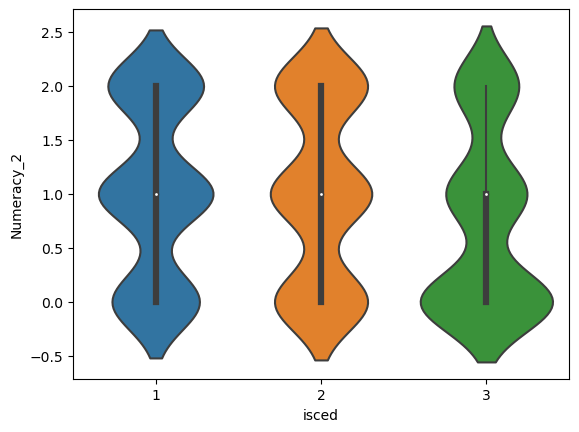

In [93]:
# Violine Plot for Numeracy_2 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Numeracy_2')

<Axes: xlabel='isced', ylabel='Bayesianreasoning_1'>

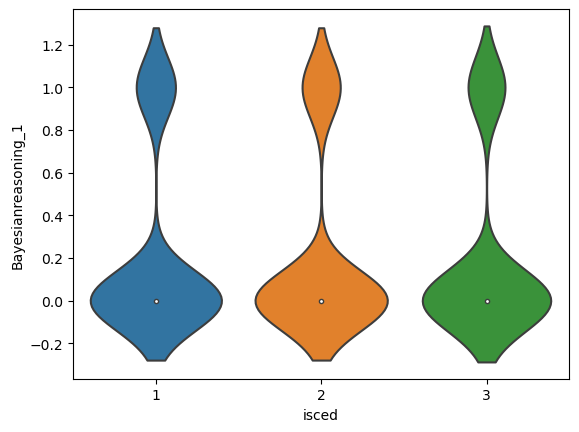

In [94]:
# Violine Plot for TotalScore_18 for each entry under edu.

sns.violinplot( data = df5, x = 'isced', y = 'Bayesianreasoning_1')

## INCOME

### INCOME VS SCORES

In [95]:
# DF3 = Sorted by income

df3 = df2.sort_values(by = 'income')
df3 = df3.reset_index(drop = True)
df3.drop(df3[df3['income'] == 7].index, inplace = True)

df3

ResponseId   age  age_rec  isced  income     wealth  Certainty_5  \
0           306  49.0        3      3       1   300000.0            2   
1           479  25.0        2      2       1    50000.0            3   
2           477  25.0        2      2       1    50000.0            2   
3           476  21.0        2      2       1  5000000.0            3   
4           475  42.0        3      2       1   200000.0            4   
..          ...   ...      ...    ...     ...        ...          ...   
694         605  26.0        2      1       6   450000.0            3   
695         199  35.0        2      1       6   100000.0            2   
696         596  40.0        3      1       6   500000.0            3   
697         227  45.0        3      2       6   750000.0            5   
698         307  30.0        2      3       6  1500000.0            5   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
0                1                    2                2           0   
1                2                    2                3           1   
2                0                    1                1           0   
3                0                    1                2           2   
4                1                    1                1           0   
..             ...                  ...              ...         ...   
694              1                    2                3           0   
695              1                    2                0           1   
696              0                    3                1           0   
697              0                    3                0           1   
698              0                    2                0           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      0         40.0           50.0                 40.0   
1                      0         60.0          100.0                 40.0   
2                      0         40.0            0.0                 20.0   
3                      0         60.0            0.0                 20.0   
4                      0         80.0           50.0                 20.0   
..                   ...          ...            ...                  ...   
694                    0         60.0           50.0                 40.0   
695                    0         40.0           50.0                 40.0   
696                    0         60.0            0.0                 60.0   
697                    0        100.0            0.0                 60.0   
698                    0        100.0            0.0                 40.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
0          66.666667         0.0                  0.0              7   
1         100.000000        50.0                  0.0             11   
2          33.333333         0.0                  0.0              4   
3          66.666667       100.0                  0.0              8   
4          33.333333         0.0                  0.0              7   
..               ...         ...                  ...            ...   
694       100.000000         0.0                  0.0              9   
695         0.000000        50.0                  0.0              6   
696        33.333333         0.0                  0.0              7   
697         0.000000        50.0                  0.0              9   
698         0.000000         0.0                  0.0              7   

     TotalScore_%  
0       38.888889  
1       61.111111  
2       22.222222  
3       44.444444  
4       38.888889  
..            ...  
694     50.000000  
695     33.333333  
696     38.888889  
697     50.000000  
698     38.888889  

[699 rows x 20 columns]

In [96]:
# Normalised mean of each facet as a numerical (sorted by income)

df3.groupby('income')[['Certainty_%','RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean()

Certainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
income                                                                  
1         53.505155            40.618557        37.113402   40.206186   
2         58.914027            39.909502        44.494721   51.809955   
3         62.631579            40.877193        36.842105   49.561404   
4         61.315789            39.210526        42.543860   46.052632   
5         57.307692            40.769231        33.974359   39.423077   
6         64.761905            40.952381        38.888889   55.952381   

        Bayesianreasoning_%  TotalScore_%  
income                                     
1                 19.587629     40.836197  
2                 23.076923     44.645551  
3                 16.666667     43.469786  
4                 28.947368     44.152047  
5                 23.076923     41.025641  
6                 38.095238     46.428571

In [97]:
# Count of responses for each category (sorted by income)

df3.groupby('income')[['ResponseId']].count()

ResponseId
income            
1              194
2              221
3              114
4               76
5               52
6               42

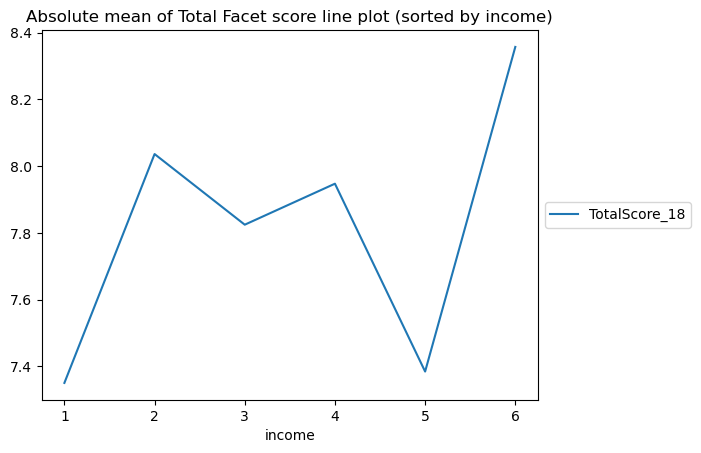

In [98]:
# Absolute mean of Total Facet score line plot (sorted by income)

df3.groupby('income')[['TotalScore_18']].mean().plot( kind = 'line', title = 'Absolute mean of Total Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

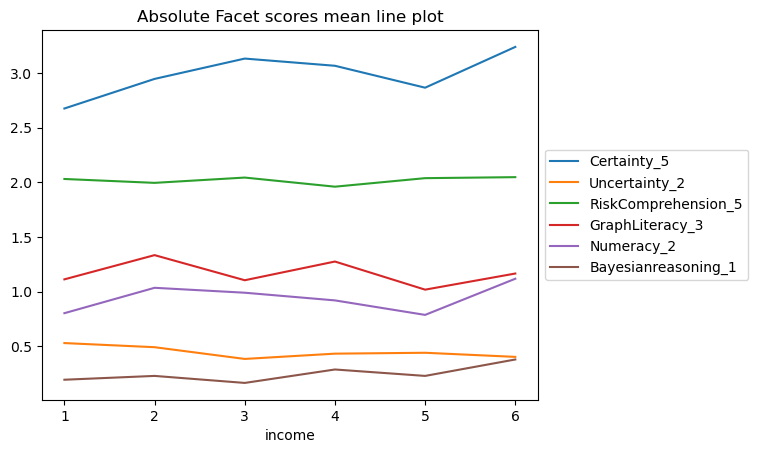

In [99]:
# Absolute mean of each Facet score line plot (sorted by income)

df3.groupby('income')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','GraphLiteracy_3','Numeracy_2','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

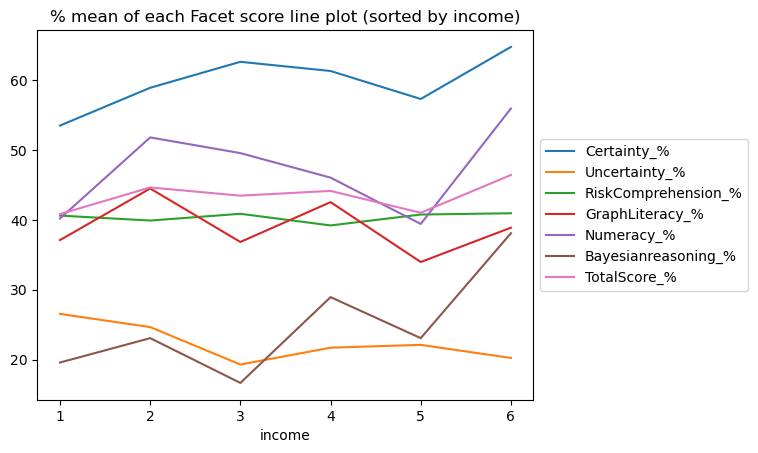

In [100]:
# Normalised mean of each Facet score line plot (sorted by income)


df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%', 'TotalScore_%']].mean().plot( kind = 'line', title = '% mean of each Facet score line plot (sorted by income)').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

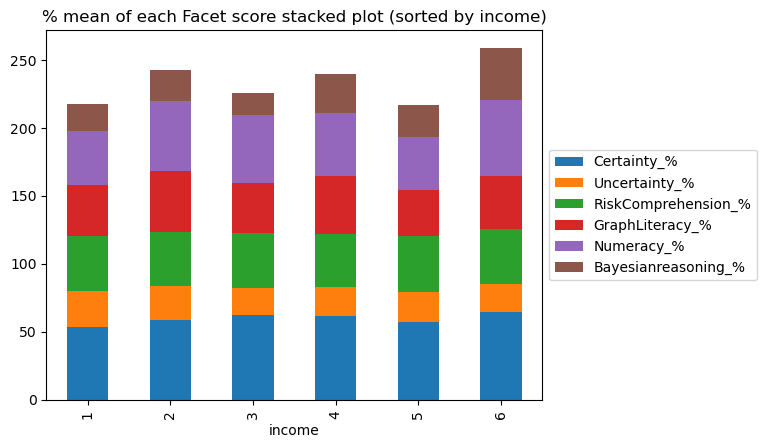

In [101]:
# Normalised mean of each Facet score stacked plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean of each Facet score stacked plot (sorted by income)', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

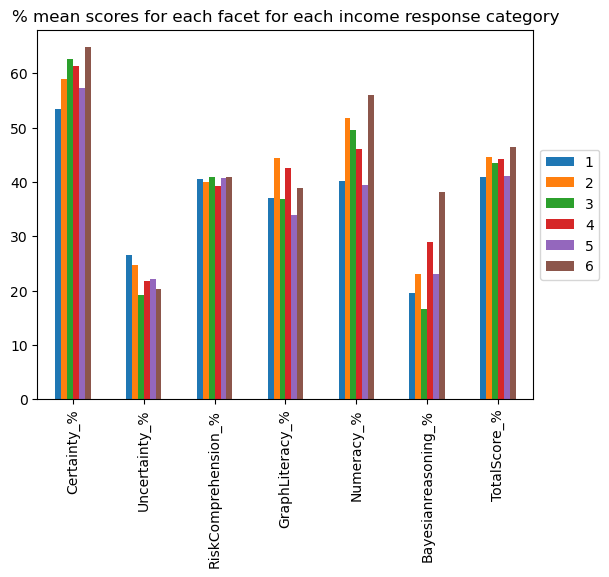

In [102]:
# Normalised mean of each Facet score hist plot (sorted by income)

df3.groupby('income')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','GraphLiteracy_%','Numeracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each income response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='income', ylabel='TotalScore_18'>

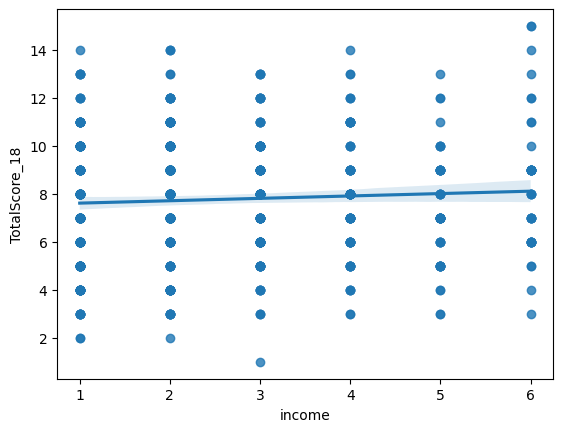

In [103]:
# Trend line for Absolute Total Facet Score vs income

sns.regplot (data = df3, x = 'income', y = 'TotalScore_18')

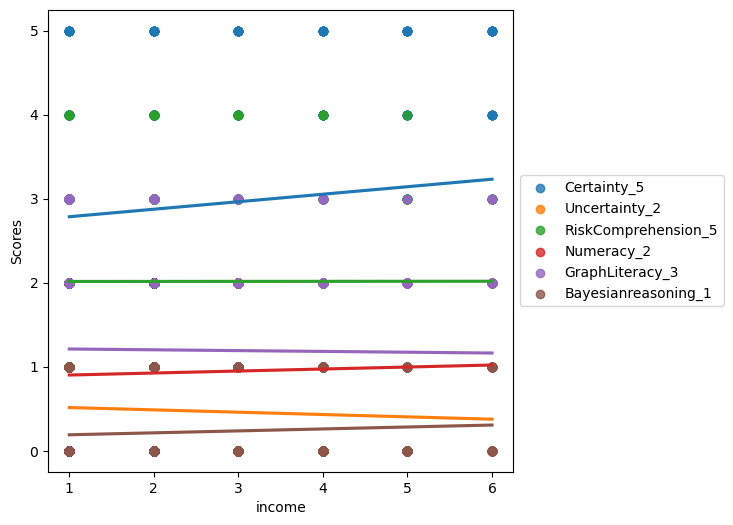

In [104]:
# Trend line for Absolute Independent Facet Score vs income reponses

fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot (data = df3, x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax, label='Certainty_5')
sns.regplot (data = df3, x = 'income', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax, label='Uncertainty_2')
sns.regplot (data = df3, x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax, label='RiskComprehension_5')
sns.regplot (data = df3, x = 'income', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax, label='Numeracy_2')
sns.regplot (data = df3, x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax, label='GraphLiteracy_3')
sns.regplot (data = df3, x = 'income', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax, label='Bayesianreasoning_1' )

ax.set(ylabel='Scores', xlabel='income')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='income', ylabel='TotalScore_18'>

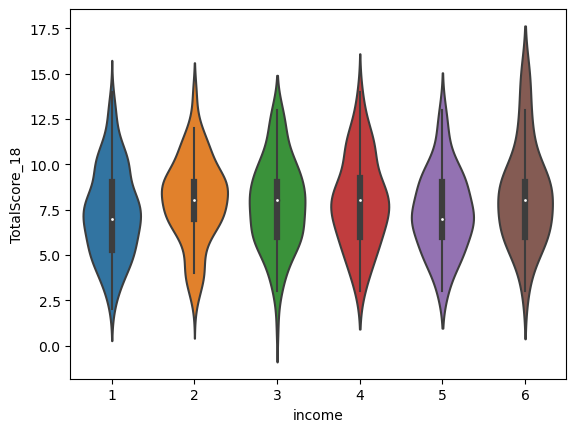

In [105]:
# Violin Plot for TotalScore_18 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'TotalScore_18')

<Axes: xlabel='income', ylabel='Certainty_5'>

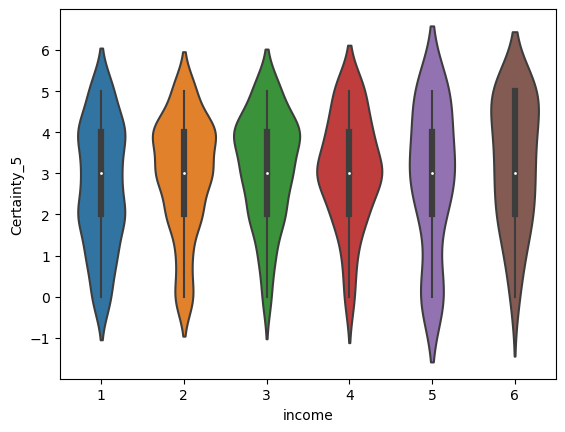

In [106]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Certainty_5')

<Axes: xlabel='income', ylabel='Uncertainty_2'>

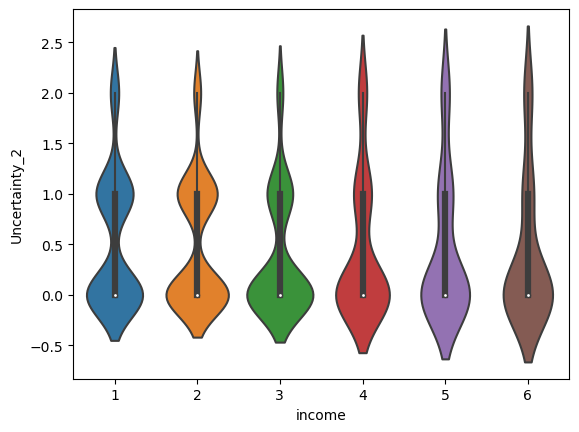

In [107]:
# Violin Plot for Certainty_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Uncertainty_2')

<Axes: xlabel='income', ylabel='RiskComprehension_5'>

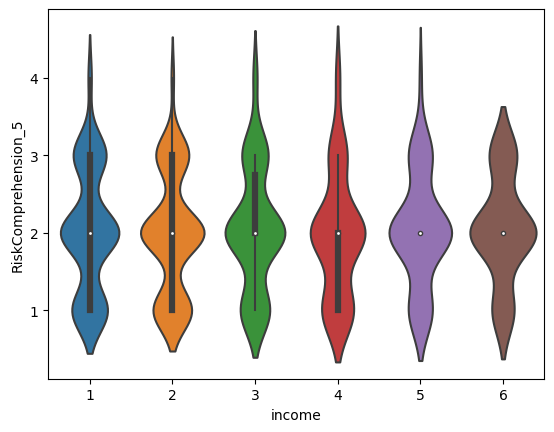

In [108]:
# Violine Plot for RiskComprehension_5 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'RiskComprehension_5')

<Axes: xlabel='income', ylabel='GraphLiteracy_3'>

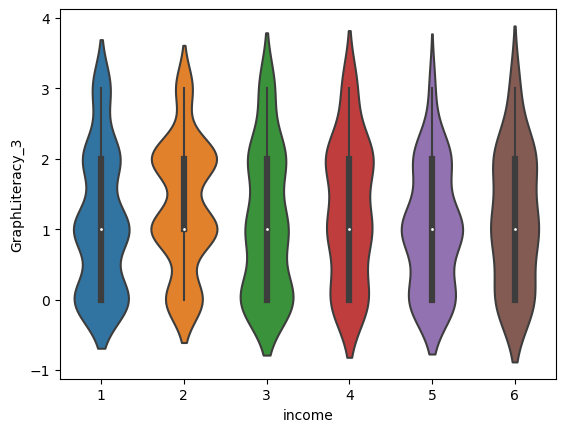

In [109]:
# Violine Plot for GraphLiteracy_3 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'GraphLiteracy_3')

<Axes: xlabel='income', ylabel='Numeracy_2'>

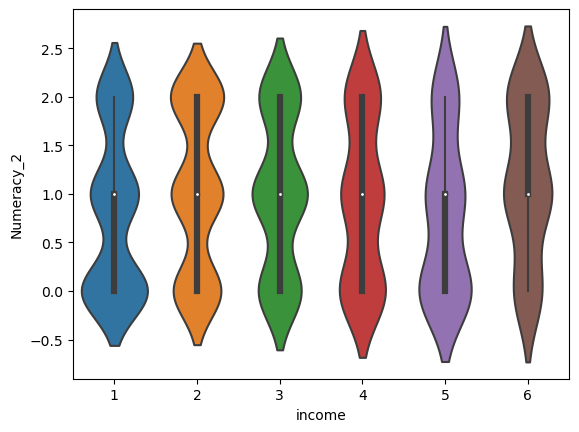

In [110]:
# Violine Plot for Numeracy_2 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Numeracy_2')

<Axes: xlabel='income', ylabel='Bayesianreasoning_1'>

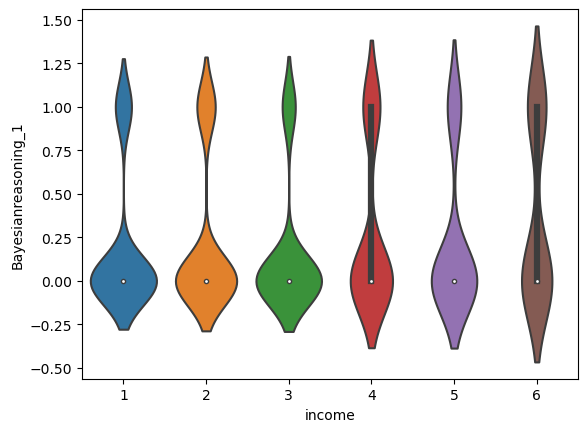

In [111]:
# Violine Plot for TotalScore_18 for each entry under income.

sns.violinplot( data = df3, x = 'income', y = 'Bayesianreasoning_1')

### INCOME vs SCORES w/ ISCED classification

In [112]:
# Descriptive stats for the data set, isced = 1
# NA values of income are removed

df7 = df5
df7.drop(df7[df7['income'] == 7].index, inplace = True)

df7.loc[df7['isced']==1].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  252.000000  252.000000  252.000000  252.0  252.000000  2.520000e+02   
mean   370.682540   35.757937    2.460317    1.0    3.234127  4.436538e+08   
std    272.942711    8.983880    0.587395    0.0    1.432667  6.317611e+09   
min      0.000000   19.000000    2.000000    1.0    1.000000  0.000000e+00   
25%    102.750000   30.000000    2.000000    1.0    2.000000  3.875000e+05   
50%    572.500000   34.500000    2.000000    1.0    3.000000  2.500000e+06   
75%    635.250000   40.000000    3.000000    1.0    4.000000  9.125000e+06   
max    698.000000   66.000000    4.000000    1.0    6.000000  1.000000e+11   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   252.000000     252.000000           252.000000       252.000000   
mean      3.186508       0.428571             2.019841         1.345238   
std       1.445193       0.661142             0.738527         0.959258   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         1.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.250000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  252.000000           252.000000   252.000000     252.000000   
mean     1.027778             0.230159    63.730159      21.428571   
std      0.785338             0.421772    28.903856      33.057099   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           252.000000       252.000000  252.000000           252.000000   
mean             40.396825        44.841270   51.388889            23.015873   
std              14.770531        31.975276   39.266882            42.177199   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              45.000000        66.666667  100.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     252.000000    252.000000  
mean        8.238095     45.767196  
std         2.508721     13.937340  
min         3.000000     16.666667  
25%         7.000000     38.888889  
50%         8.000000     44.444444  
75%        10.000000     55.555556  
max        15.000000     83.333333

In [113]:
df7.loc[df7['isced']==2].describe()

ResponseId        age     age_rec  isced      income        wealth  \
count  241.000000  241.00000  241.000000  241.0  241.000000  2.410000e+02   
mean   327.900415   33.40249    2.373444    2.0    2.224066  4.807468e+06   
std    174.356168   11.55926    0.599965    0.0    1.227973  1.680959e+07   
min      2.000000   18.00000    2.000000    2.0    1.000000  0.000000e+00   
25%    182.000000   25.00000    2.000000    2.0    1.000000  1.000000e+05   
50%    398.000000   30.00000    2.000000    2.0    2.000000  5.000000e+05   
75%    490.000000   39.00000    3.000000    2.0    3.000000  2.500000e+06   
max    556.000000   72.00000    4.000000    2.0    6.000000  1.565000e+08   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   241.000000     241.000000           241.000000       241.000000   
mean      2.817427       0.481328             1.970954         1.211618   
std       1.375328       0.619697             0.771353         0.917895   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  241.000000           241.000000   241.000000     241.000000   
mean     1.000000             0.224066    56.348548      24.066390   
std      0.806226             0.417834    27.506569      30.984871   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           241.000000       241.000000  241.000000           241.000000   
mean             39.419087        40.387275   50.000000            22.406639   
std              15.427069        30.596498   40.311289            41.783377   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              40.000000        66.666667  100.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     241.000000    241.000000  
mean        7.705394     42.807746  
std         2.444452     13.580289  
min         3.000000     16.666667  
25%         6.000000     33.333333  
50%         7.000000     38.888889  
75%         9.000000     50.000000  
max        13.000000     72.222222

In [114]:
df7.loc[df7['isced']==3].describe()

ResponseId         age     age_rec  isced      income        wealth  \
count  206.000000  206.000000  206.000000  206.0  206.000000  2.060000e+02   
mean   347.160194   36.601942    2.548544    3.0    2.150485  4.259471e+06   
std    104.520781   13.248352    0.651507    0.0    1.521128  1.546074e+07   
min     27.000000   18.000000    2.000000    3.0    1.000000  0.000000e+00   
25%    285.250000   27.000000    2.000000    3.0    1.000000  2.125000e+04   
50%    345.500000   35.000000    2.000000    3.0    2.000000  2.000000e+05   
75%    404.500000   45.000000    3.000000    3.0    2.750000  1.500000e+06   
max    570.000000   75.000000    4.000000    3.0    6.000000  1.500000e+08   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   206.000000     206.000000           206.000000       206.000000   
mean      2.733010       0.509709             2.063107         0.995146   
std       1.521096       0.638140             0.802981         0.960171   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.250000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  206.000000           206.000000   206.000000     206.000000   
mean     0.757282             0.223301    54.660194      25.485437   
std      0.808081             0.417473    30.421928      31.906988   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      1.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           206.000000       206.000000  206.000000           206.000000   
mean             41.262136        33.171521   37.864078            22.330097   
std              16.059621        32.005686   40.404069            41.747297   
min              20.000000         0.000000    0.000000             0.000000   
25%              25.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              60.000000        66.666667   50.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     206.000000    206.000000  
mean        7.281553     40.453074  
std         2.290670     12.725946  
min         1.000000      5.555556  
25%         6.000000     33.333333  
50%         7.000000     38.888889  
75%         9.000000     50.000000  
max        14.000000     77.777778

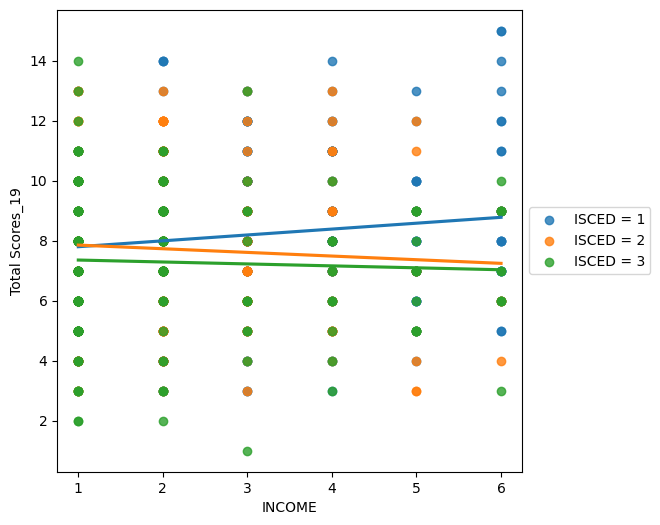

In [115]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==1]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==2]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = df7.loc[df7['isced']==3]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='INCOME')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

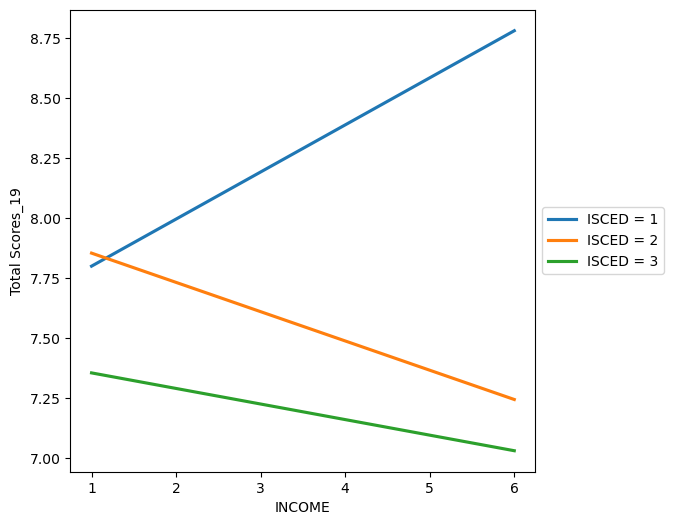

In [116]:
# Trend line for Absolute Tota Facet Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='INCOME')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

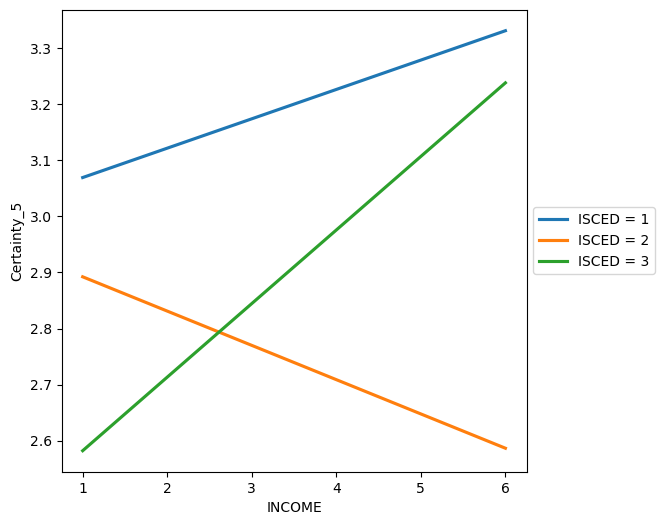

In [117]:
# Trend line for Absolute Certainty Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='INCOME')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

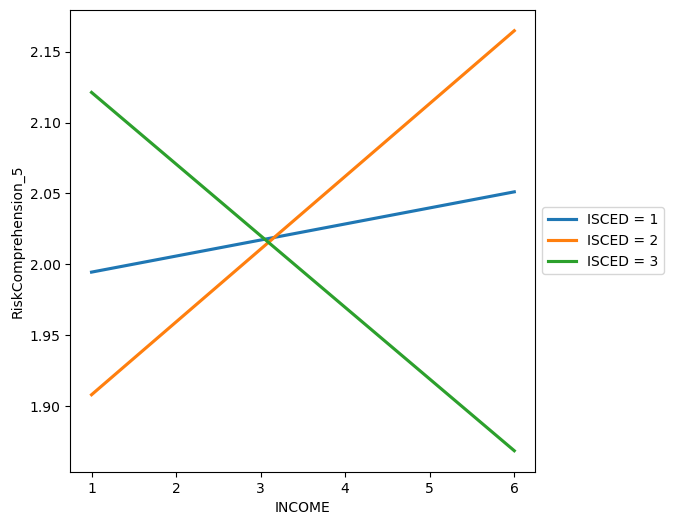

In [118]:
# Trend line for Absolute Risk Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='INCOME')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

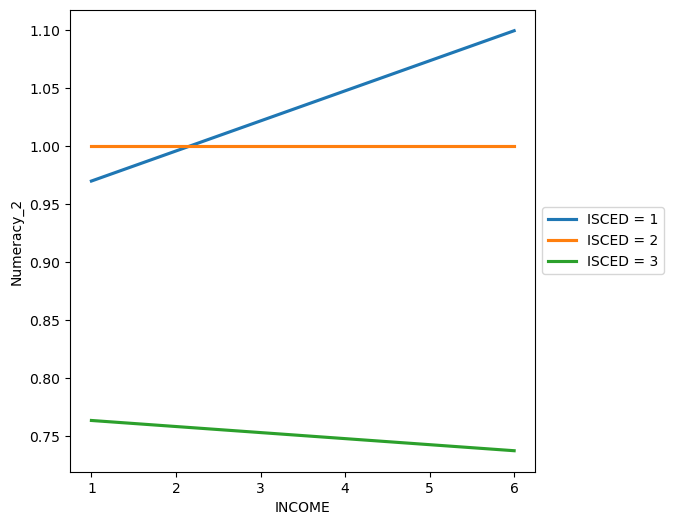

In [119]:
# Trend line for Absolute Number Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_2', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

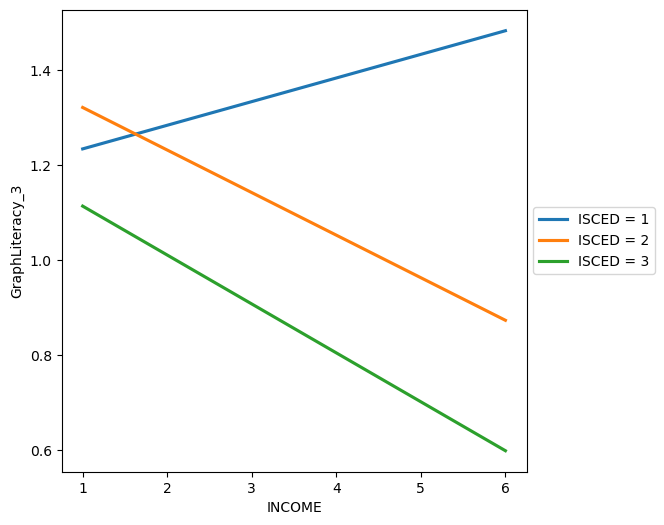

In [120]:
# Trend line for Absolute Graph Comprehension Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='INCOME')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

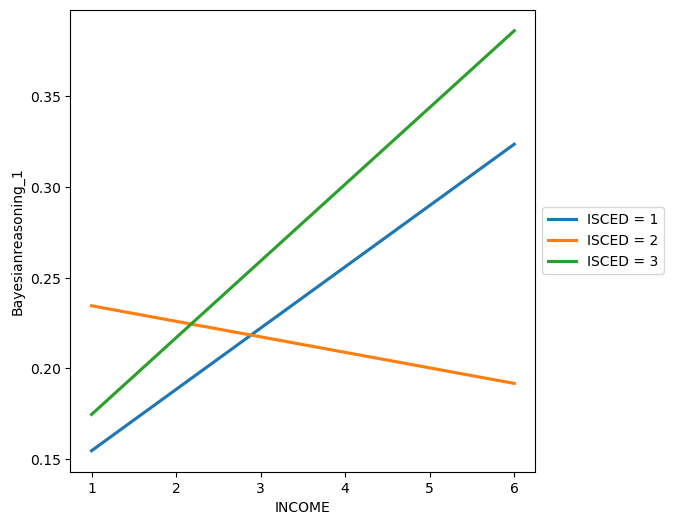

In [121]:
# Trend line for Absolute Bayesian Reasoning Score vs income reponses sorted by isced and ORDERED by income WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[df7['isced']==1].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==2].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[df7['isced']==3].reset_index(drop = True), x = 'income', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='INCOME')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### INCOME vs SCORES w/ ISCED and AGE based classification 

In [122]:
df7

ResponseId   age  age_rec  isced  income      wealth  Certainty_5  \
0             0  30.0        2      1       2   5000000.0            2   
1           599  35.0        2      1       3   2000000.0            5   
2           598  27.0        2      1       5  20000000.0            2   
3           597  45.0        3      1       3   5000000.0            2   
4           596  40.0        3      1       6    500000.0            3   
..          ...   ...      ...    ...     ...         ...          ...   
694         365  26.0        2      3       1   4000000.0            3   
695         364  28.0        2      3       3    100000.0            2   
696         363  20.0        2      3       2    140000.0            5   
697         361  75.0        4      3       1   2000000.0            2   
698         349  37.0        3      3       2  15000000.0            0   

     Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
0                0                    1                2           1   
1                0                    2                2           2   
2                0                    2                1           2   
3                0                    2                1           1   
4                0                    3                1           0   
..             ...                  ...              ...         ...   
694              0                    2                0           0   
695              0                    2                2           2   
696              0                    2                0           0   
697              0                    2                2           0   
698              0                    1                1           0   

     Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
0                      1         40.0            0.0                 20.0   
1                      1        100.0            0.0                 40.0   
2                      1         40.0            0.0                 40.0   
3                      0         40.0            0.0                 40.0   
4                      0         60.0            0.0                 60.0   
..                   ...          ...            ...                  ...   
694                    0         60.0            0.0                 40.0   
695                    0         40.0            0.0                 40.0   
696                    0        100.0            0.0                 40.0   
697                    0         40.0            0.0                 40.0   
698                    0          0.0            0.0                 20.0   

     GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
0          66.666667        50.0                100.0              7   
1          66.666667       100.0                100.0             12   
2          33.333333       100.0                100.0              8   
3          33.333333        50.0                  0.0              6   
4          33.333333         0.0                  0.0              7   
..               ...         ...                  ...            ...   
694         0.000000         0.0                  0.0              5   
695        66.666667       100.0                  0.0              8   
696         0.000000         0.0                  0.0              7   
697        66.666667         0.0                  0.0              6   
698        33.333333         0.0                  0.0              2   

     TotalScore_%  
0       38.888889  
1       66.666667  
2       44.444444  
3       33.333333  
4       38.888889  
..            ...  
694     27.777778  
695     44.444444  
696     38.888889  
697     33.333333  
698     11.111111  

[699 rows x 20 columns]

In [123]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [124]:
df7.loc[(df7['age_rec']==2)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  425.000000  425.000000    425.0  425.000000  425.000000  4.250000e+02   
mean   355.920000   27.917647      2.0    1.912941    2.527059  2.426421e+08   
std    197.921459    4.729005      0.0    0.776693    1.455260  4.850621e+09   
min      0.000000   18.000000      2.0    1.000000    1.000000  0.000000e+00   
25%    204.000000   24.000000      2.0    1.000000    1.000000  1.000000e+05   
50%    364.000000   28.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    518.000000   32.000000      2.0    3.000000    3.000000  3.000000e+06   
max    698.000000   35.000000      2.0    3.000000    6.000000  1.000000e+11   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   425.000000     425.000000           425.000000       425.000000   
mean      2.908235       0.454118             1.981176         1.164706   
std       1.412062       0.613056             0.764559         0.957186   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  425.000000           425.000000   425.000000     425.000000   
mean     0.927059             0.249412    58.164706      22.705882   
std      0.810804             0.433182    28.241231      30.652812   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           425.000000       425.000000  425.000000           425.000000   
mean             39.623529        38.823529   46.352941            24.941176   
std              15.291180        31.906186   40.540193            43.318248   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              40.000000        66.666667  100.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     425.000000    425.000000  
mean        7.684706     42.692810  
std         2.395825     13.310139  
min         2.000000     11.111111  
25%         6.000000     33.333333  
50%         8.000000     44.444444  
75%         9.000000     50.000000  
max        15.000000     83.333333

In [125]:
df7.loc[(df7['age_rec']==3)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  229.000000  229.000000    229.0  229.000000  229.000000  2.290000e+02   
mean   340.087336   43.104803      3.0    1.934498    2.759825  4.526527e+07   
std    208.893474    5.013790      0.0    0.858440    1.518584  5.383814e+08   
min      1.000000   36.000000      3.0    1.000000    1.000000  0.000000e+00   
25%    155.000000   39.000000      3.0    1.000000    2.000000  1.000000e+05   
50%    336.000000   42.000000      3.0    2.000000    2.000000  1.000000e+06   
75%    546.000000   46.000000      3.0    3.000000    4.000000  5.000000e+06   
max    696.000000   55.000000      3.0    3.000000    6.000000  8.144789e+09   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   229.000000     229.000000           229.000000       229.000000   
mean      3.056769       0.427948             2.052402         1.183406   
std       1.475326       0.635434             0.776212         0.960393   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             2.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  229.000000           229.000000   229.000000     229.000000   
mean     0.921397             0.192140    61.135371      21.397380   
std      0.801821             0.394845    29.506526      31.771721   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           229.000000       229.000000  229.000000           229.000000   
mean             41.048035        39.446870   46.069869            19.213974   
std              15.524241        32.013105   40.091063            39.484536   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              60.000000        66.666667  100.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     229.000000    229.000000  
mean        7.834061     43.522562  
std         2.500609     13.892272  
min         1.000000      5.555556  
25%         6.000000     33.333333  
50%         8.000000     44.444444  
75%         9.000000     50.000000  
max        15.000000     83.333333

In [126]:
df7.loc[(df7['age_rec']==4)].describe()

ResponseId        age  age_rec      isced     income        wealth  \
count   45.000000  45.000000     45.0  45.000000  45.000000  4.500000e+01   
mean   329.000000  63.666667      4.0   2.133333   1.955556  7.737089e+06   
std    204.826867   4.866397      0.0   0.814639   1.330679  1.956429e+07   
min      5.000000  57.000000      4.0   1.000000   1.000000  0.000000e+00   
25%    156.000000  60.000000      4.0   1.000000   1.000000  2.500000e+05   
50%    310.000000  63.000000      4.0   2.000000   1.000000  1.000000e+06   
75%    529.000000  67.000000      4.0   3.000000   2.000000  4.500000e+06   
max    678.000000  75.000000      4.0   3.000000   6.000000  1.100000e+08   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count    45.000000      45.000000            45.000000        45.000000   
mean      2.422222       0.844444             2.155556         1.555556   
std       1.671810       0.796457             0.767391         0.840875   
min       0.000000       0.000000             1.000000         0.000000   
25%       1.000000       0.000000             2.000000         1.000000   
50%       3.000000       1.000000             2.000000         2.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count   45.000000            45.000000    45.000000      45.000000   
mean     1.133333             0.177778    48.444444      42.222222   
std      0.786245             0.386646    33.436205      39.822840   
min      0.000000             0.000000     0.000000       0.000000   
25%      1.000000             0.000000    20.000000       0.000000   
50%      1.000000             0.000000    60.000000      50.000000   
75%      2.000000             0.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count            45.000000        45.000000   45.000000            45.000000   
mean             43.111111        51.851852   56.666667            17.777778   
std              15.347819        28.029166   39.312270            38.664577   
min              20.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333   50.000000             0.000000   
50%              40.000000        66.666667   50.000000             0.000000   
75%              60.000000        66.666667  100.000000             0.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count      45.000000     45.000000  
mean        8.288889     46.049383  
std         2.693614     14.964521  
min         3.000000     16.666667  
25%         6.000000     33.333333  
50%         9.000000     50.000000  
75%        11.000000     61.111111  
max        13.000000     72.222222

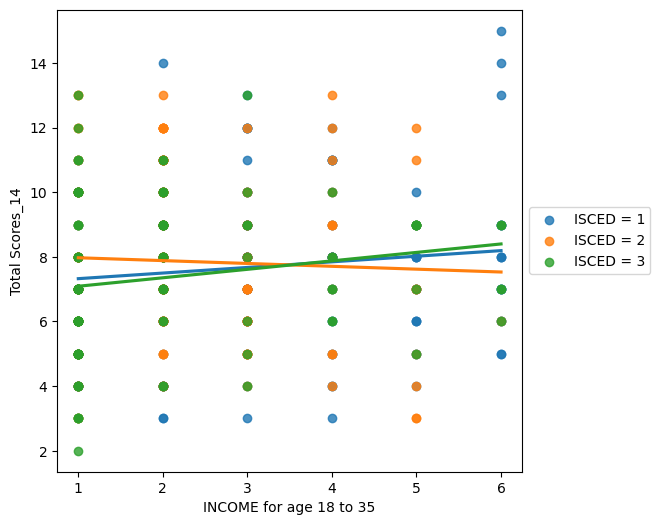

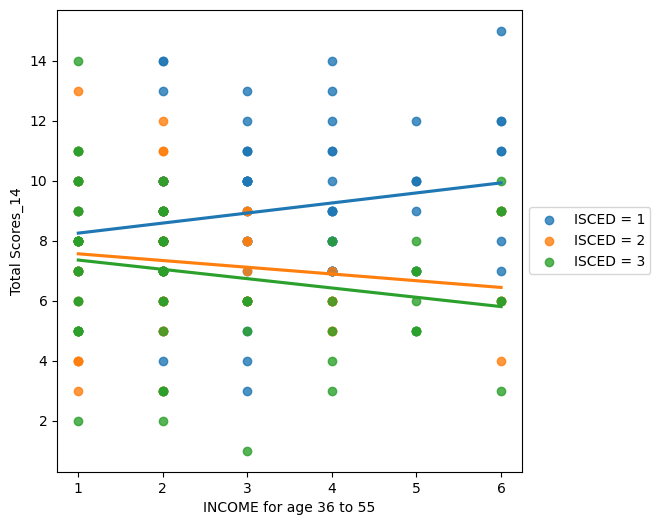

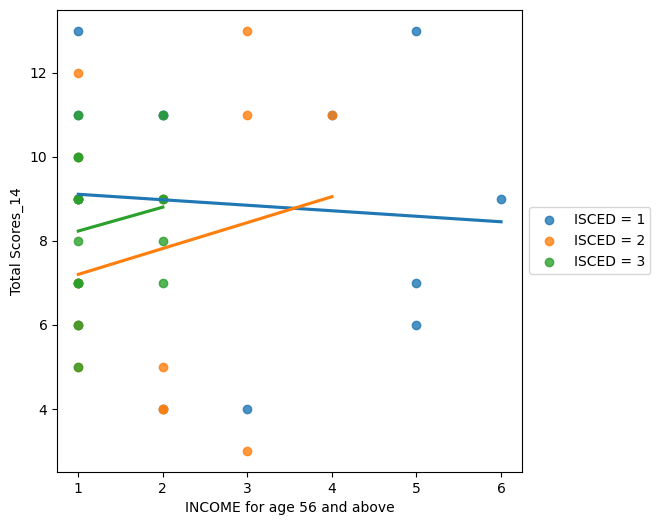

In [127]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

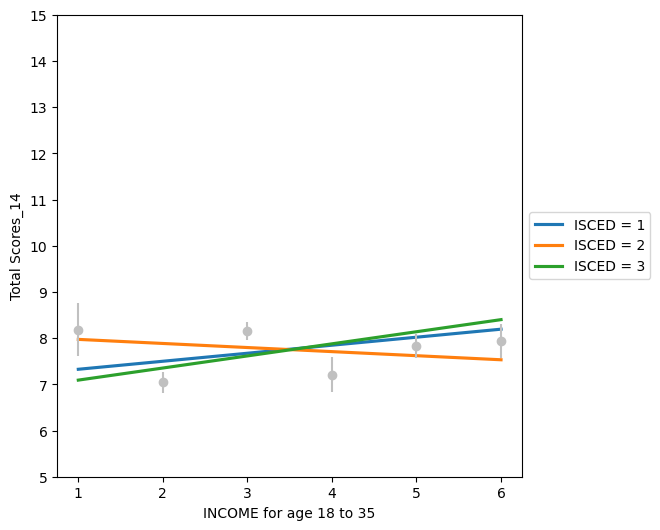

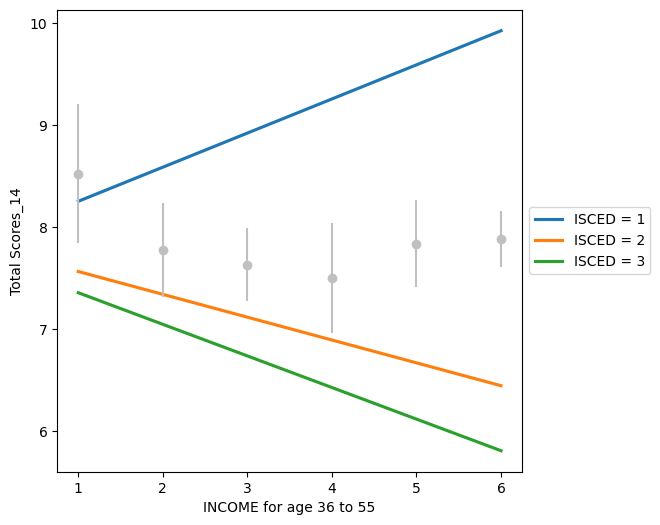

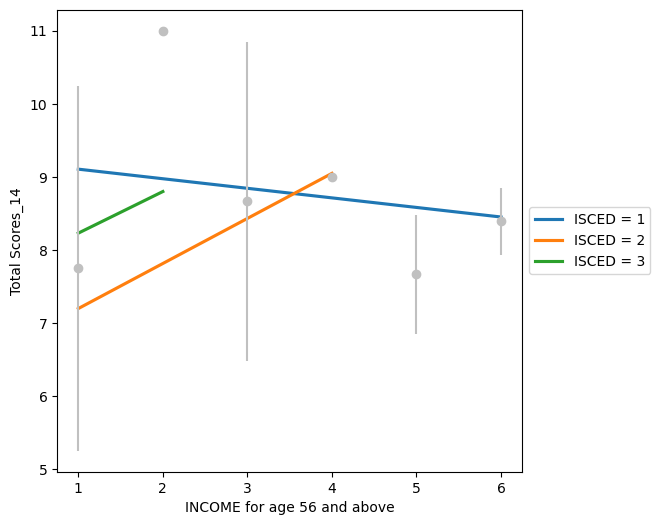

In [128]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income']).mean(numeric_only=True)['TotalScore_18'], yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='INCOME for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='INCOME for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income']).mean(numeric_only=True)['TotalScore_18'], yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='INCOME for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income']).mean(numeric_only=True)['TotalScore_18'], yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

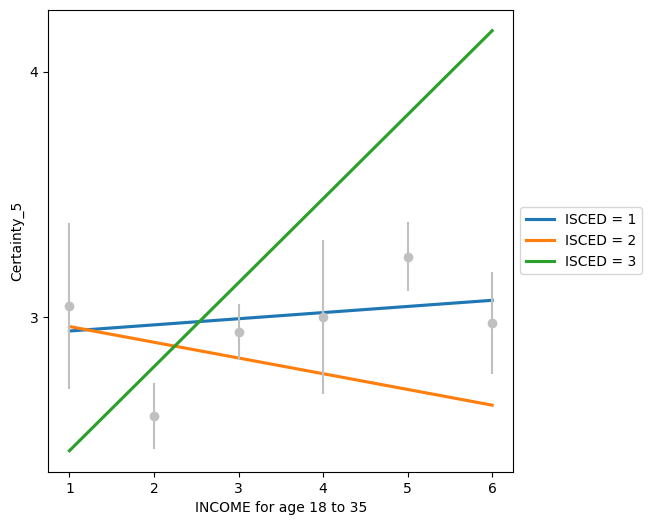

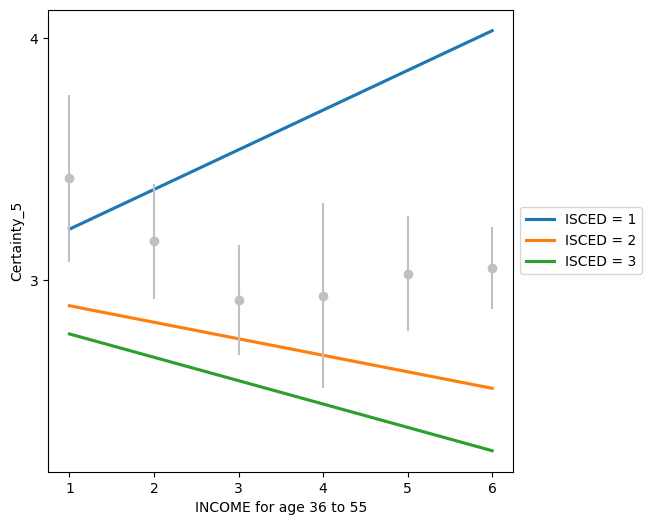

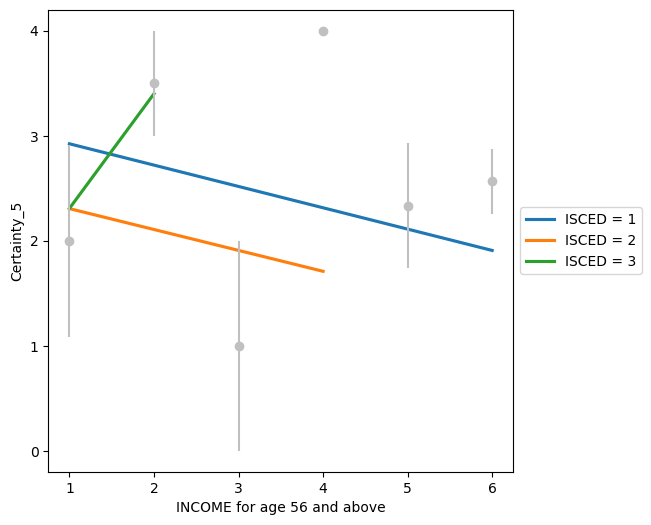

In [129]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

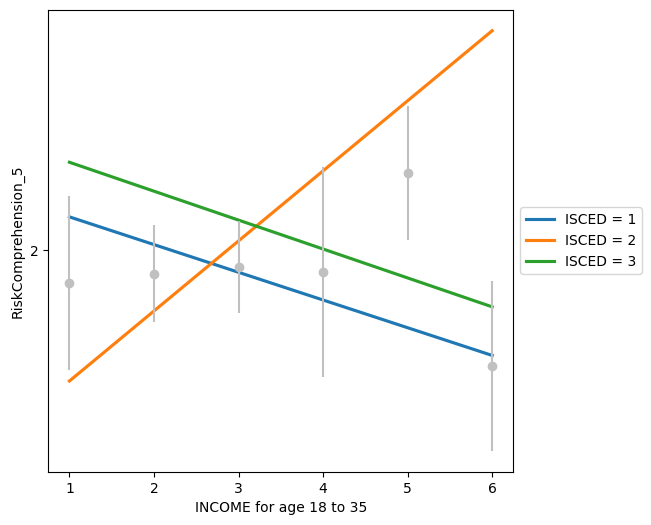

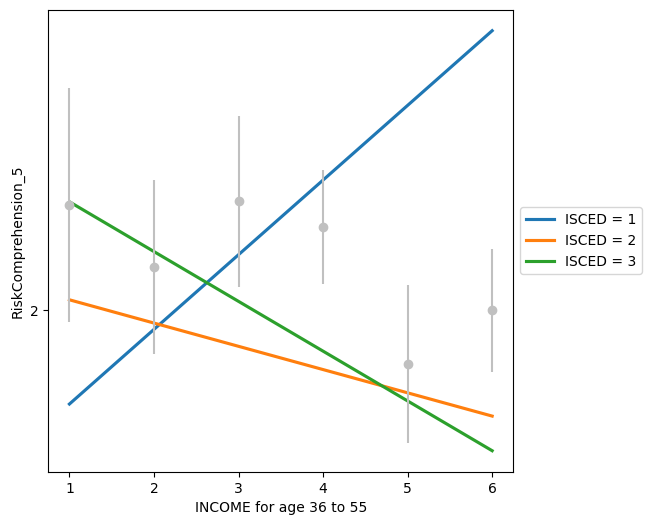

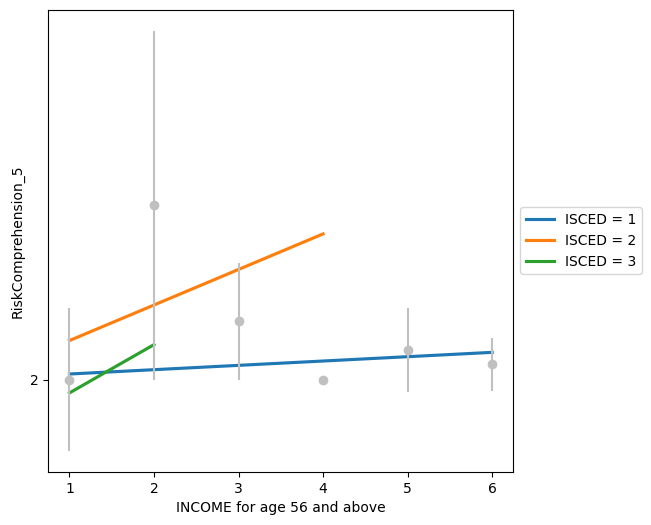

In [130]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

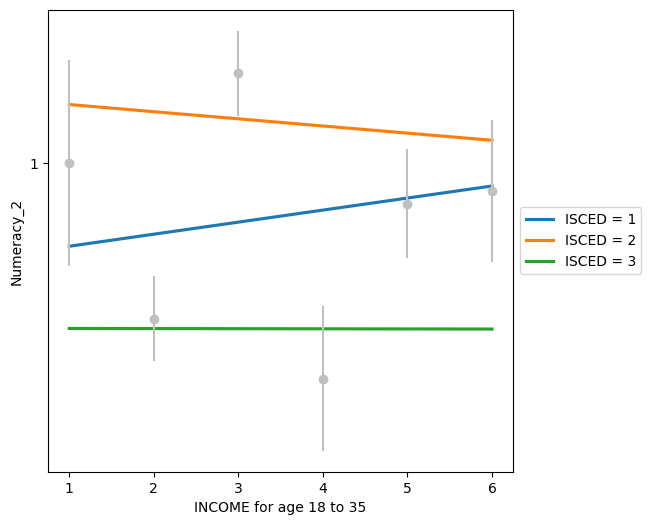

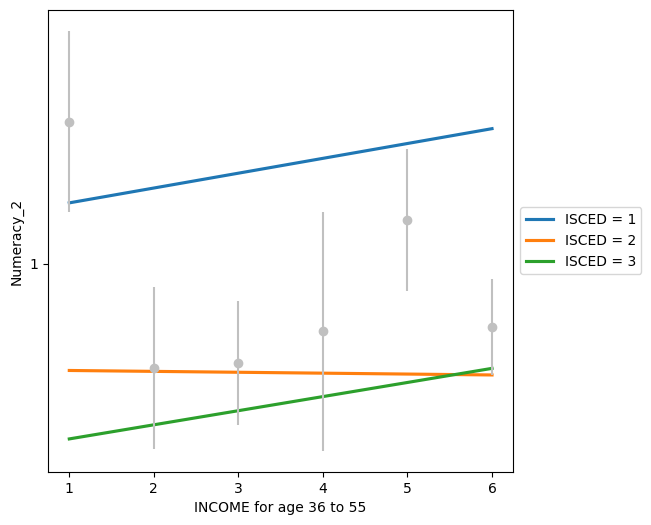

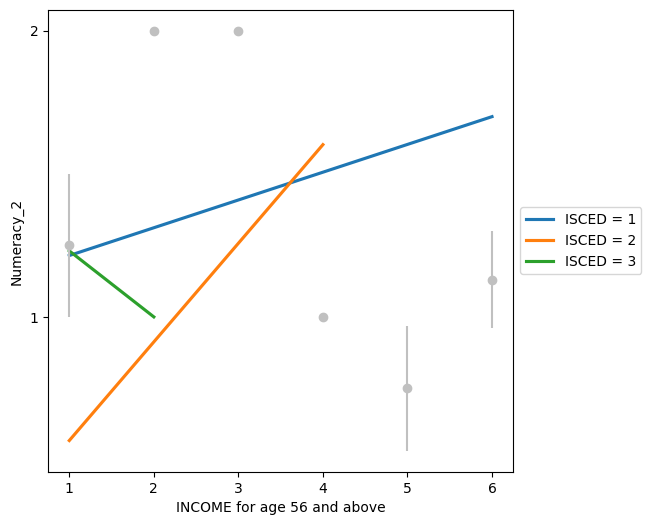

In [131]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_2', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Numeracy_2'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_2', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Numeracy_2'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_2', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Numeracy_2'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

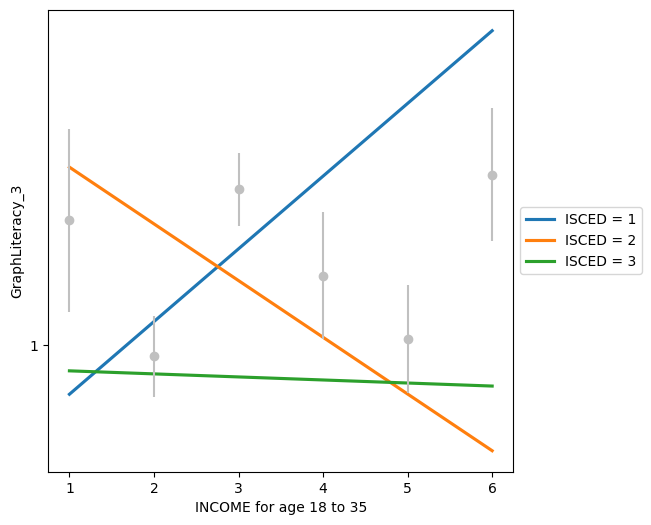

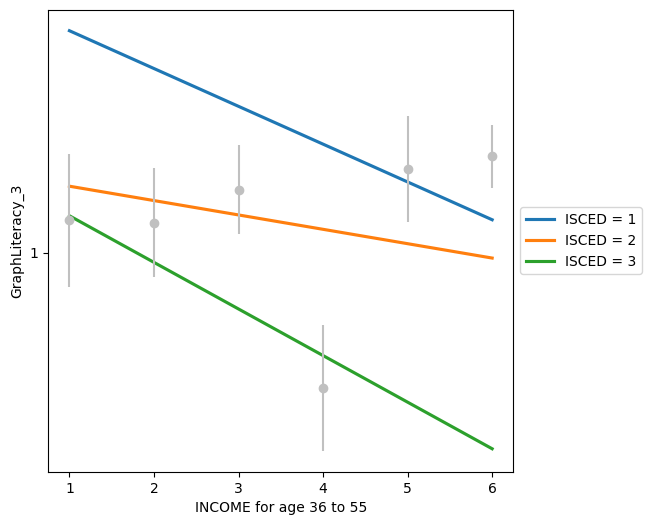

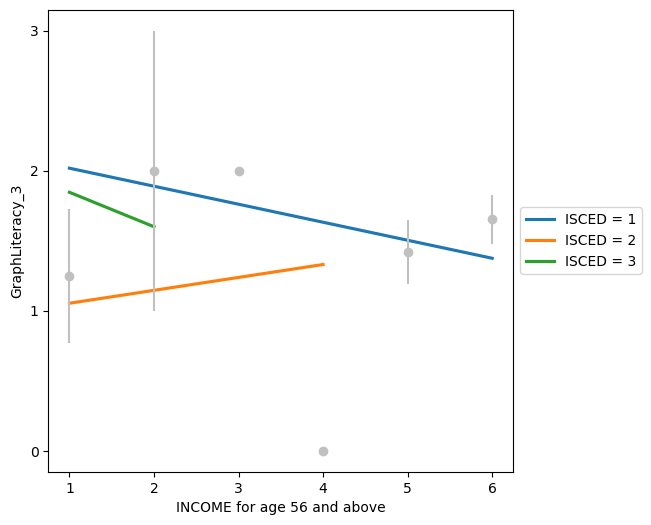

In [132]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

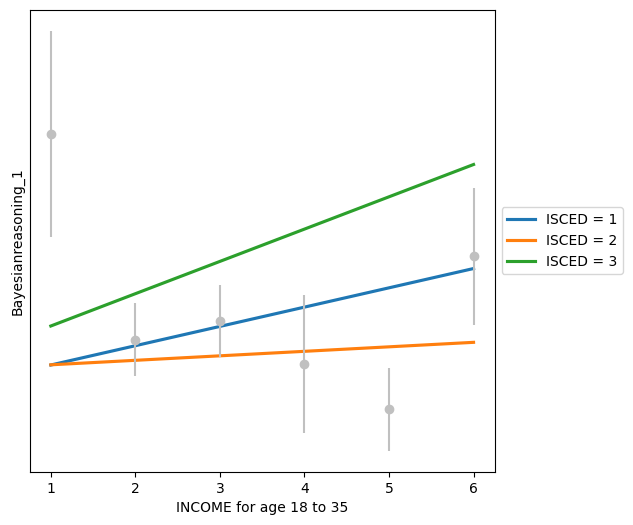

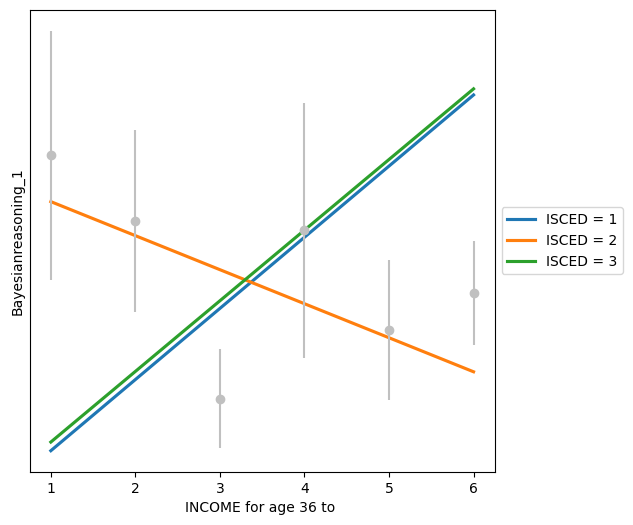

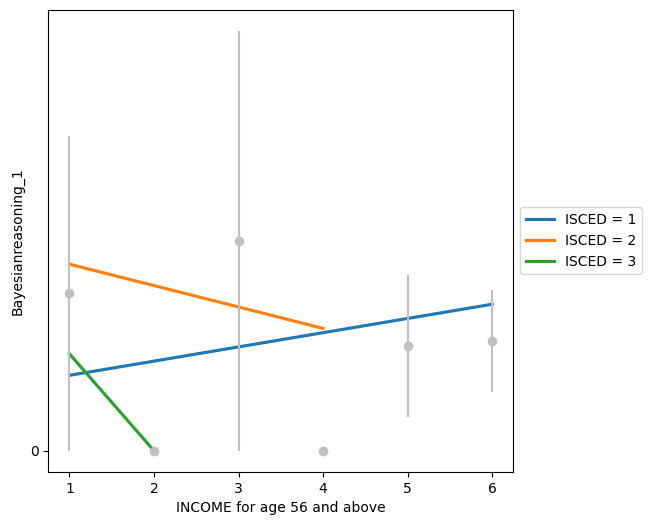

In [133]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==2) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df7.loc[ df7['age_rec']==2  ]["income"].unique(), y = df7.loc[ df7['age_rec']==2  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==2) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==3) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df7.loc[ df7['age_rec']==3  ]["income"].unique(), y = df7.loc[ df7['age_rec']==3  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==3) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age_rec']==4) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df7.loc[ df7['age_rec']== 4 ]['income'].unique(), y = df7.loc[ df7['age_rec']==4  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age_rec']==4) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [134]:
# Age mean method
# Age_mean

In [135]:
age_m = df2["age"].median()
age_m

33.0

In [136]:
df7["income"].value_counts()

income
2    221
1    194
3    114
4     76
5     52
6     42
Name: count, dtype: int64

In [137]:
df7.loc[(df7['age'] < age_m)].describe()

ResponseId         age  age_rec       isced      income        wealth  \
count  338.000000  338.000000    338.0  338.000000  338.000000  3.380000e+02   
mean   345.745562   26.260355      2.0    1.970414    2.349112  3.033634e+08   
std    194.884917    3.812788      0.0    0.762053    1.365976  5.439166e+09   
min      0.000000   18.000000      2.0    1.000000    1.000000  0.000000e+00   
25%    205.250000   24.000000      2.0    1.000000    1.000000  7.000000e+04   
50%    343.500000   26.000000      2.0    2.000000    2.000000  5.000000e+05   
75%    509.500000   30.000000      2.0    3.000000    3.000000  2.500000e+06   
max    693.000000   32.000000      2.0    3.000000    6.000000  1.000000e+11   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   338.000000     338.000000           338.000000       338.000000   
mean      2.855030       0.470414             1.946746         1.171598   
std       1.420386       0.616788             0.744996         0.956079   
min       0.000000       0.000000             1.000000         0.000000   
25%       2.000000       0.000000             1.000000         0.000000   
50%       3.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             2.000000         2.000000   
max       5.000000       2.000000             4.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  338.000000           338.000000   338.000000     338.000000   
mean     0.943787             0.260355    57.100592      23.520710   
std      0.807847             0.439479    28.407723      30.839412   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    60.000000       0.000000   
75%      2.000000             1.000000    80.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           338.000000       338.000000  338.000000           338.000000   
mean             38.934911        39.053254   47.189349            26.035503   
std              14.899920        31.869300   40.392359            43.947891   
min              20.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              40.000000        66.666667  100.000000           100.000000   
max              80.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  
count     338.000000    338.000000  
mean        7.647929     42.488494  
std         2.292488     12.736043  
min         2.000000     11.111111  
25%         6.000000     33.333333  
50%         8.000000     44.444444  
75%         9.000000     50.000000  
max        14.000000     77.777778

In [138]:
df7.loc[(df7['age'] >= age_m)].describe()

ResponseId         age     age_rec       isced      income  \
count  361.000000  361.000000  361.000000  361.000000  361.000000   
mean   352.047091   43.559557    2.883657    1.900277    2.770083   
std    208.531334    9.491366    0.594217    0.847234    1.552701   
min      1.000000   33.000000    2.000000    1.000000    1.000000   
25%    162.000000   36.000000    3.000000    1.000000    2.000000   
50%    353.000000   41.000000    3.000000    2.000000    2.000000   
75%    547.000000   47.000000    3.000000    3.000000    4.000000   
max    698.000000   75.000000    4.000000    3.000000    6.000000   

             wealth  Certainty_5  Uncertainty_2  RiskComprehension_5  \
count  3.610000e+02   361.000000     361.000000           361.000000   
mean   3.130188e+07     2.991690       0.470914             2.080332   
std    4.289678e+08     1.487891       0.662371             0.786466   
min    0.000000e+00     0.000000       0.000000             1.000000   
25%    1.000000e+05     2.000000       0.000000             2.000000   
50%    1.000000e+06     3.000000       0.000000             2.000000   
75%    5.000000e+06     4.000000       1.000000             3.000000   
max    8.144789e+09     5.000000       2.000000             4.000000   

       GraphLiteracy_3  Numeracy_2  Bayesianreasoning_1  Certainty_%  \
count       361.000000  361.000000           361.000000   361.000000   
mean          1.218837    0.933518             0.193906    59.833795   
std           0.954102    0.806922             0.395905    29.757820   
min           0.000000    0.000000             0.000000     0.000000   
25%           0.000000    0.000000             0.000000    40.000000   
50%           1.000000    1.000000             0.000000    60.000000   
75%           2.000000    2.000000             0.000000    80.000000   
max           3.000000    2.000000             1.000000   100.000000   

       Uncertainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
count     361.000000           361.000000       361.000000   361.00000   
mean       23.545706            41.606648        40.627886    46.67590   
std        33.118537            15.729320        31.803404    40.34611   
min         0.000000            20.000000         0.000000     0.00000   
25%         0.000000            40.000000         0.000000     0.00000   
50%         0.000000            40.000000        33.333333    50.00000   
75%        50.000000            60.000000        66.666667   100.00000   
max       100.000000            80.000000       100.000000   100.00000   

       Bayesianreasoning_%  TotalScore_18  TotalScore_%  
count           361.000000     361.000000    361.000000  
mean             19.390582       7.889197     43.828870  
std              39.590471       2.589277     14.384872  
min               0.000000       1.000000      5.555556  
25%               0.000000       6.000000     33.333333  
50%               0.000000       8.000000     44.444444  
75%               0.000000      10.000000     55.555556  
max             100.000000      15.000000     83.333333

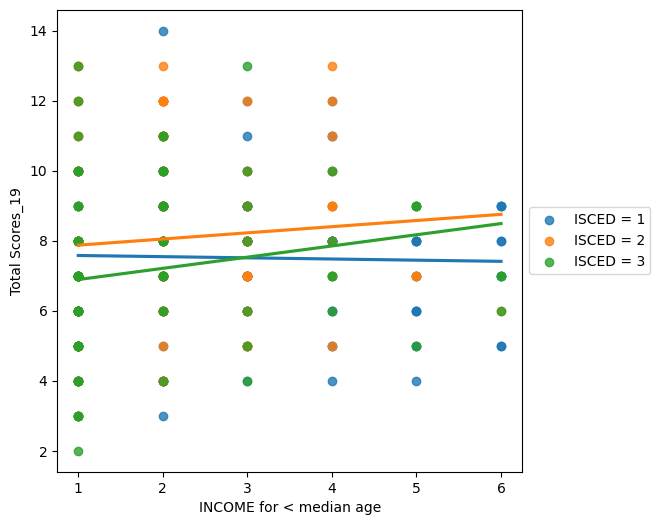

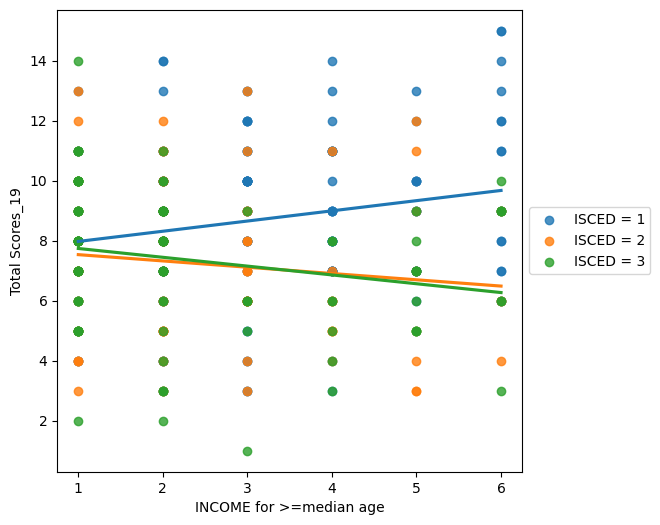

In [139]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df7.loc[(df7['age'] >= age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

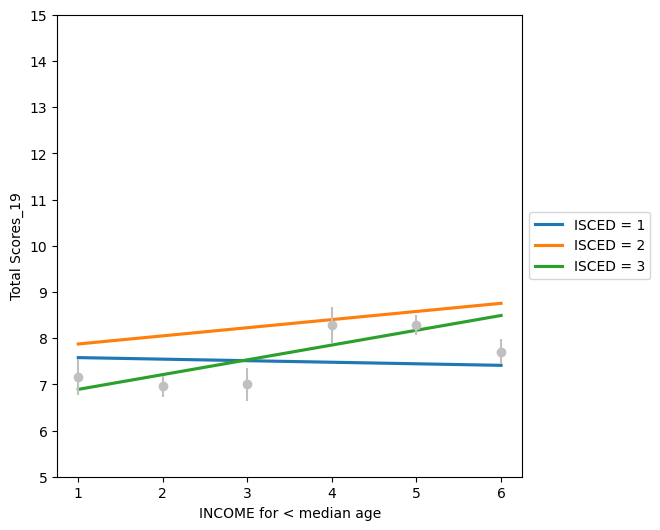

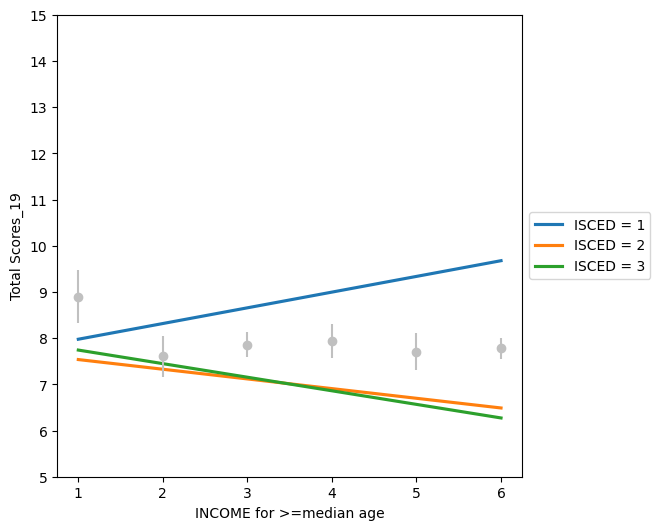

In [140]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['TotalScore_18'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='INCOME for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['TotalScore_18'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='INCOME for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

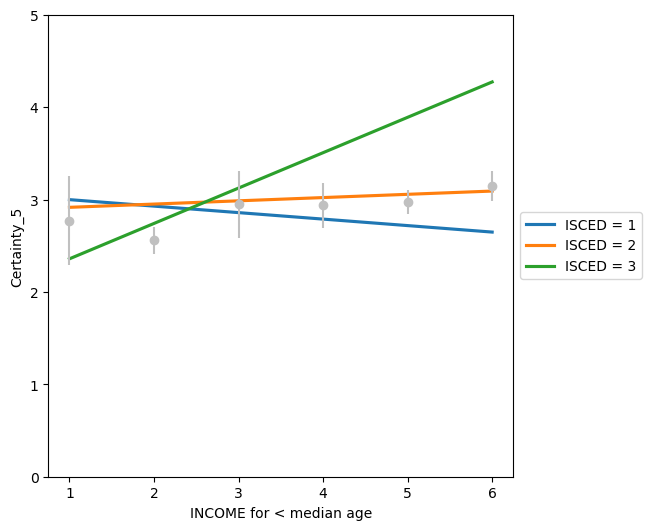

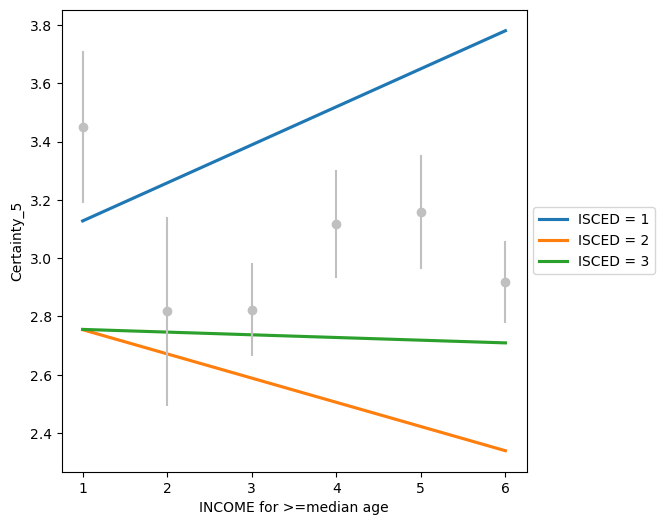

In [141]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Certainty_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='INCOME for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

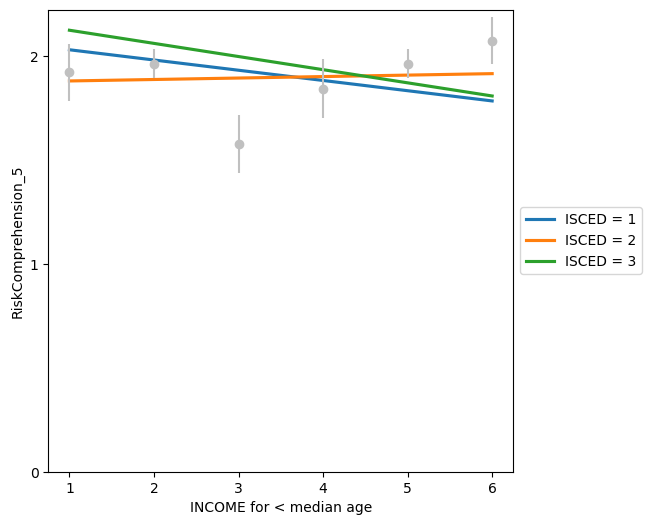

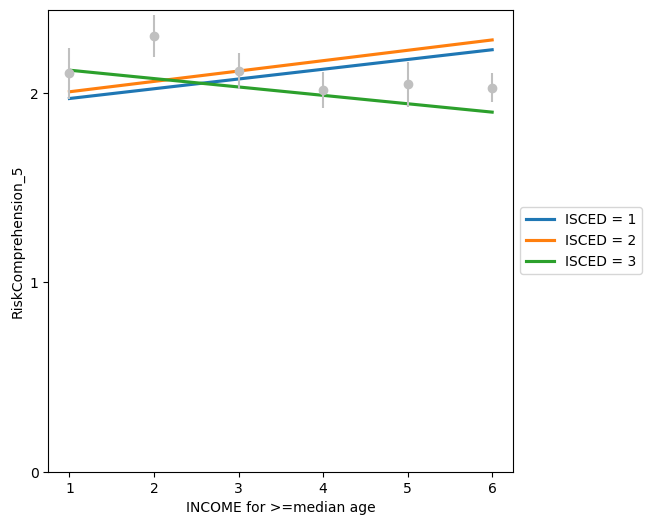

In [142]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='INCOME for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['RiskComprehension_5'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='INCOME for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

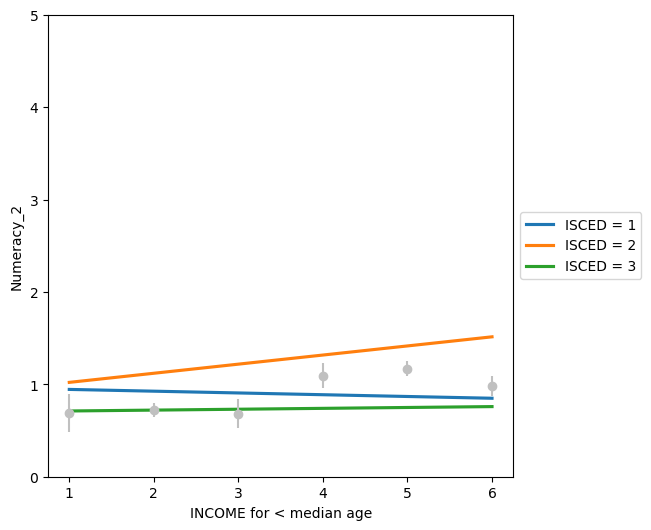

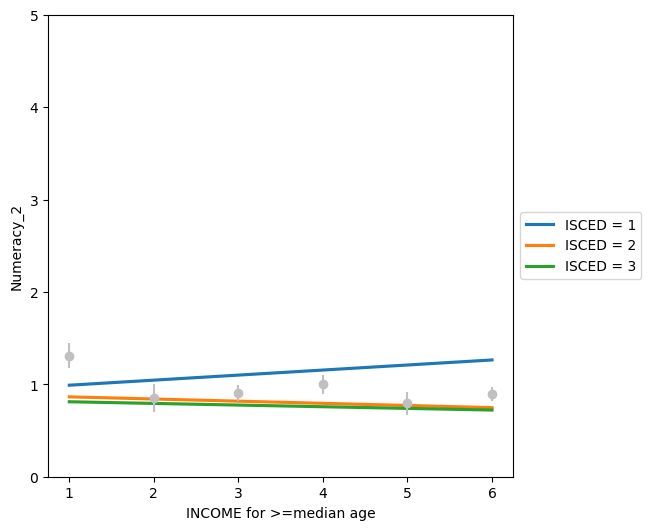

In [143]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Numeracy_2'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_2', xlabel='INCOME for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Numeracy_2'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_2', xlabel='INCOME for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

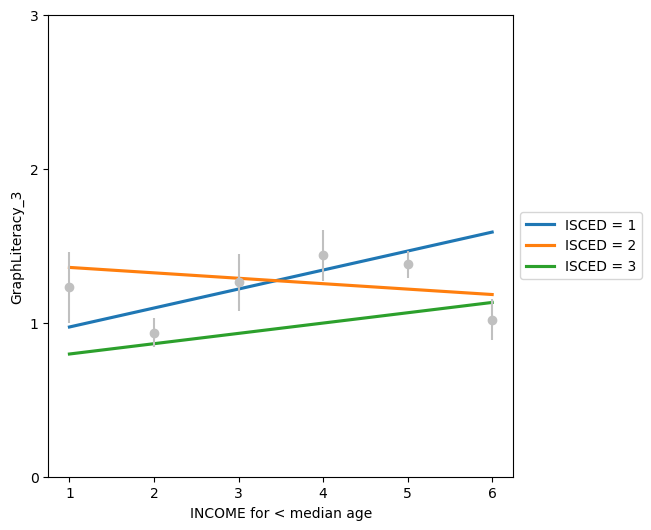

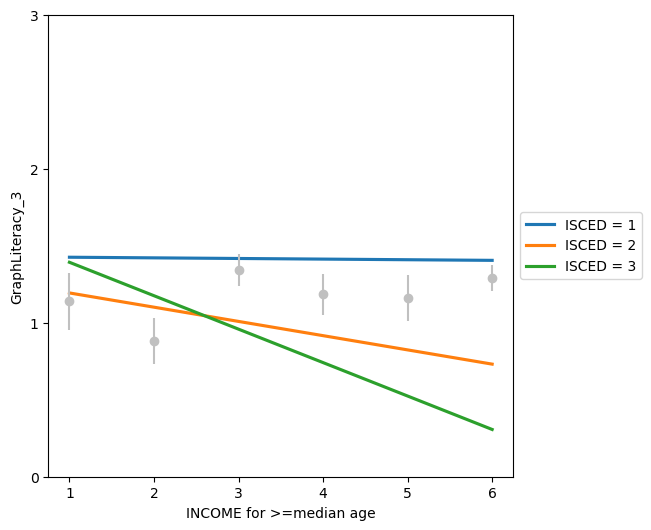

In [144]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='INCOME for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['GraphLiteracy_3'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='INCOME for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

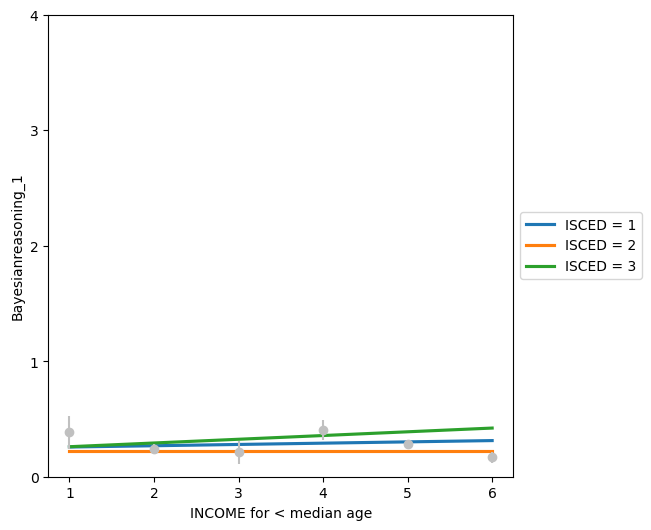

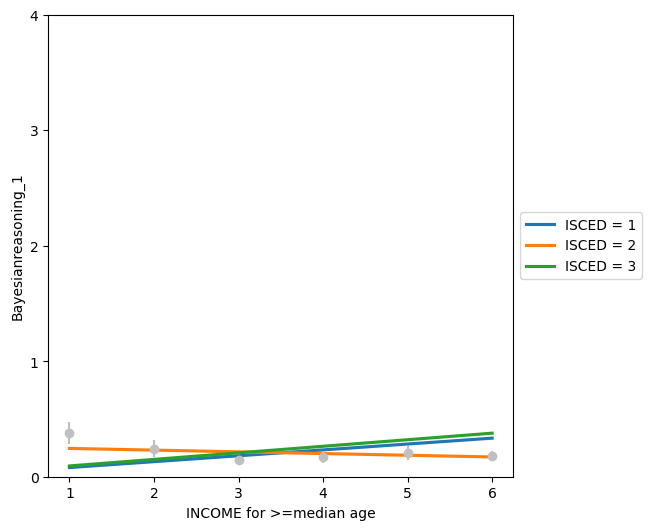

In [145]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] < age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df7.loc[ (df7['age'] < age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] < age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] < age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)].reset_index(drop = True), x = 'income', y = df7.loc[(df7['age'] >=age_m) & (df7['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df7.loc[ (df7['age'] >= age_m)  ]["income"].unique(), y = df7.loc[ (df7['age'] >=age_m)  ].groupby(['income'])['Bayesianreasoning_1'].mean(), yerr = df7.loc[ (df7['age'] >=age_m) ].groupby(['income'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='INCOME for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

## WEALTH

In [103]:
# Data Frame 2 or df2 is an aggregate data on facet total scores and over all total score, along with wealth and income data vs each response. 
# This data set is also sorted by wealth with all responses 'NA' removed.
# We also assign quartiles ranking each response according to this sort.

df4 = df2.sort_values(by = 'wealth')
df4 = df4.reset_index(drop = True)
df4 = df4.dropna(axis = 0, subset = 'wealth')
df4.insert(loc = len(df4.columns), column = "Quartile Number", value = pd.qcut(df4["wealth"],q = 4, labels = False ) + 1, allow_duplicates = 'False')

df4

ResponseId   age  age_rec  isced  income  \
0     2rkur9ckjvsyz36zmayz1zw2rkur9ckn  40.5        3      1       3   
1                    R_4DPGUOAP86yO30R  19.0        2      3       1   
2                    R_4fNO2Z5GF8KerZI  24.0        2      2       2   
3                    R_4lnmGavSf6rw1eE  31.0        2      1       1   
4     y139mcxc619h0ooosy139muk14mpfpvm  30.5        2      3       1   
...                                ...   ...      ...    ...     ...   
1008  35zux4sc18rplyz3dc85z35zux4sdfm4  21.5        2      2       4   
1009  wn9mk6m1k8o10l1twn9mk6b4z7l7yvhc  50.5        3      1       3   
1010  4udfypw7lf8mmgjmxr4d4udfym4sx1sf  40.5        3      1       3   
1011  oczyh23wpxpk4o0teoczy5zzzng3i6kk  30.5        2      2       5   
1012  zcj7ldokhyo6217f9sriwizcj7ldodwt  40.5        3      2       3   

           wealth  Certainty_5  Uncertainty_2  RiskComprehension_5  \
0             0.0            3              0                    2   
1             0.0            4              2                    1   
2             0.0            4              0                    4   
3             0.0            1              0                    2   
4             0.0            5              0                    2   
...           ...          ...            ...                  ...   
1008  500000000.0            2              0                    1   
1009  500000000.0            2              0                    3   
1010  500000000.0            0              0                    3   
1011  500000000.0            1              0                    3   
1012  600000000.0            3              1                    2   

      GraphLiteracy_3  Numeracy_2  Bayesianreasoning_1  Certainty_%  \
0                   0           0                    0         60.0   
1                   2           1                    1         80.0   
2                   1           2                    0         80.0   
3                   1           2                    0         20.0   
4                   0           0                    1        100.0   
...               ...         ...                  ...          ...   
1008                0           1                    0         40.0   
1009                3           2                    0         40.0   
1010                0           0                    0          0.0   
1011                3           2                    0         20.0   
1012                1           2                    1         60.0   

      Uncertainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0               0.0                 40.0         0.000000         0.0   
1             100.0                 20.0        66.666667        50.0   
2               0.0                 80.0        33.333333       100.0   
3               0.0                 40.0        33.333333       100.0   
4               0.0                 40.0         0.000000         0.0   
...             ...                  ...              ...         ...   
1008            0.0                 20.0         0.000000        50.0   
1009            0.0                 60.0       100.000000       100.0   
1010            0.0                 60.0         0.000000         0.0   
1011            0.0                 60.0       100.000000       100.0   
1012           50.0                 40.0        33.333333       100.0   

      Bayesianreasoning_%  TotalScore_18  TotalScore_%  Quartile Number  
0                     0.0              5     27.777778                1  
1                   100.0             11     61.111111                1  
2                     0.0             11     61.111111                1  
3                     0.0              6     33.333333                1  
4                   100.0              8     44.444444                1  
...                   ...            ...           ...              ...  
1008                  0.0              4     22.222222                4  


<Axes: ylabel='TotalScore_18'>

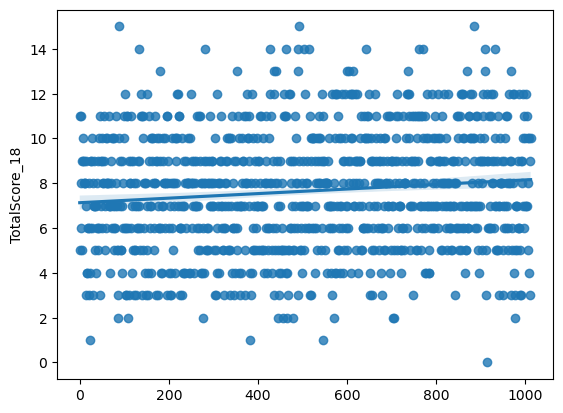

In [104]:
# Trend line for Absolute Total Facet Score vs unique wealth reponses

sns.regplot (data = df4, x = df4.index, y = 'TotalScore_18')

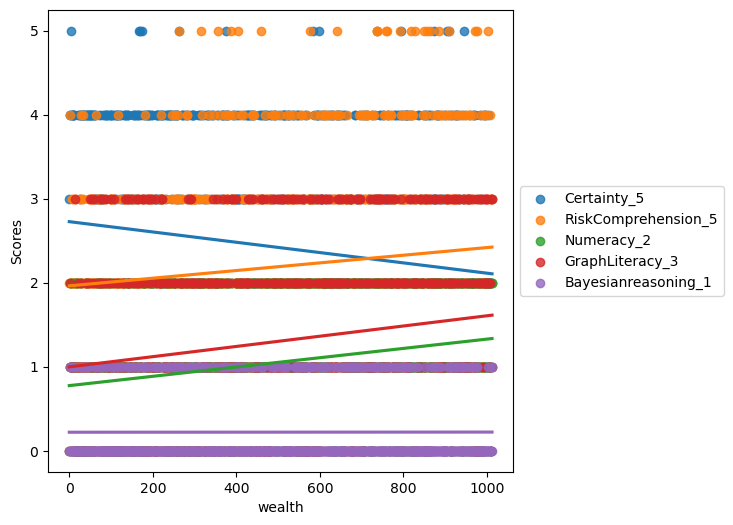

In [105]:
# Trend line for Absolute Independent Facet Score vs wealth reponses

fig1, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = df4.index, y = 'Certainty_5', fit_reg=True, ci=None, ax=ax1, label='Certainty_5')
sns.regplot (data = df4, x = df4.index, y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax1, label='RiskComprehension_5')
sns.regplot (data = df4, x = df4.index, y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax1, label='Numeracy_2')
sns.regplot (data = df4, x = df4.index, y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax1, label='GraphLiteracy_3')
sns.regplot (data = df4, x = df4.index, y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax1, label='Bayesianreasoning_1' )

ax1.set(ylabel='Scores', xlabel='wealth')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [106]:
# Count of number of responses under each quartile

df4.groupby('Quartile Number')[['Quartile Number']].count()

Quartile Number
Quartile Number                 
1                            255
2                            296
3                            242
4                            220

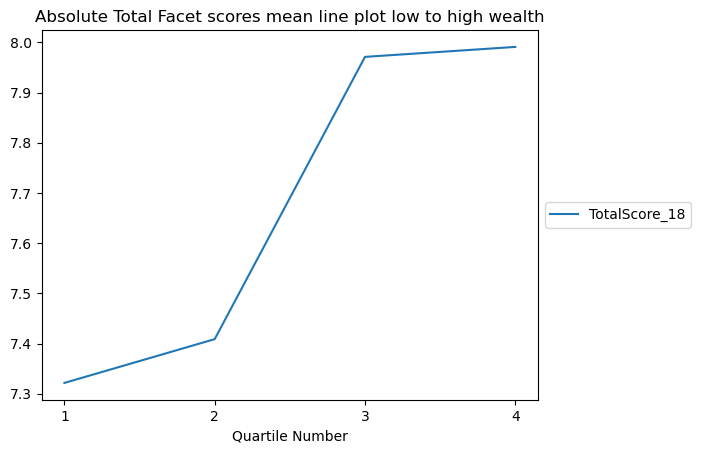

In [107]:
# Absolute Total Facet scores mean line plot from low to high Wealth

df4.groupby('Quartile Number')[['TotalScore_18']].mean().plot( kind = 'line', title = 'Absolute Total Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

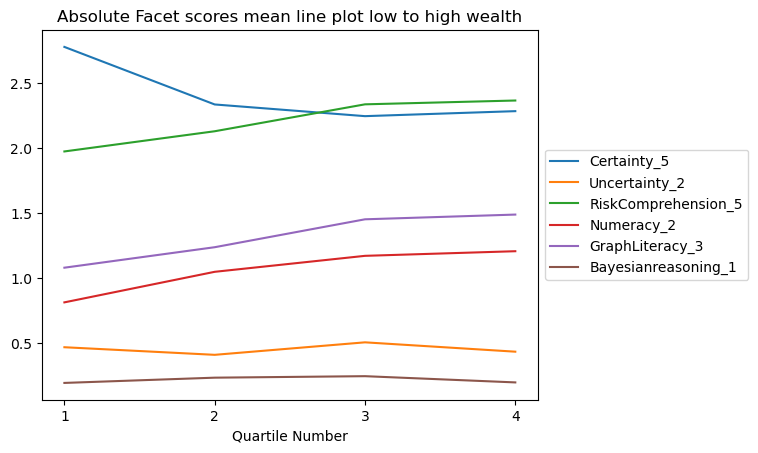

In [108]:
# Absolute Facet scores mean line plot from low to high wealth

df4.groupby('Quartile Number')[['Certainty_5', "Uncertainty_2", 'RiskComprehension_5','Numeracy_2','GraphLiteracy_3','Bayesianreasoning_1']].mean().plot( kind = 'line', title = 'Absolute Facet scores mean line plot low to high wealth', xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

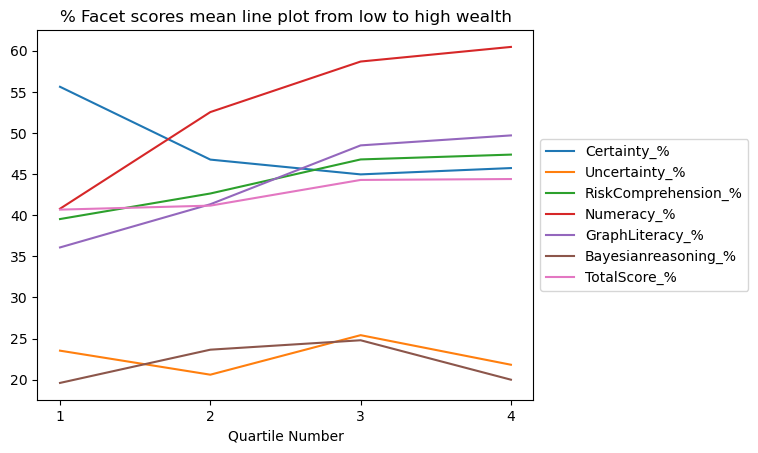

In [109]:
# Normalised Facet scores mean line plot from low to high wealth


df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().plot( kind = 'line', title = '% Facet scores mean line plot from low to high wealth',  xticks = np.arange(1,5,step = 1)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

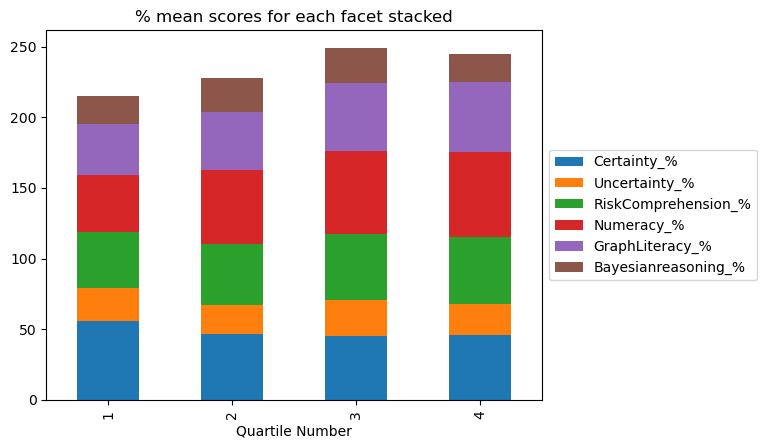

In [110]:
# Normalised mean scores for each facet stacked

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%']].mean().plot( kind = 'bar', title = '% mean scores for each facet stacked', stacked = True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

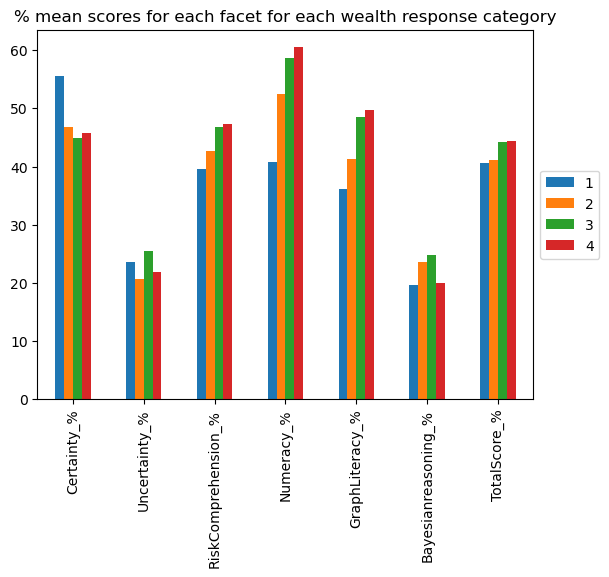

In [111]:
# Normalised mean scores for each facet for each wealth response Quartile

df4.groupby('Quartile Number')[['Certainty_%', "Uncertainty_%", 'RiskComprehension_%','Numeracy_%','GraphLiteracy_%','Bayesianreasoning_%','TotalScore_%']].mean().T.plot(kind = 'bar', title = '% mean scores for each facet for each wealth response category').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<Axes: xlabel='Quartile Number', ylabel='TotalScore_18'>

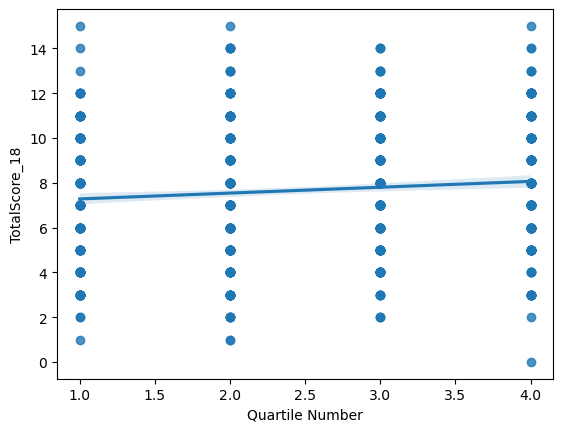

In [112]:
# Trend line for Absolute Total Facet Score vs Quartiles

sns.regplot (data = df4, x = 'Quartile Number', y = 'TotalScore_18')

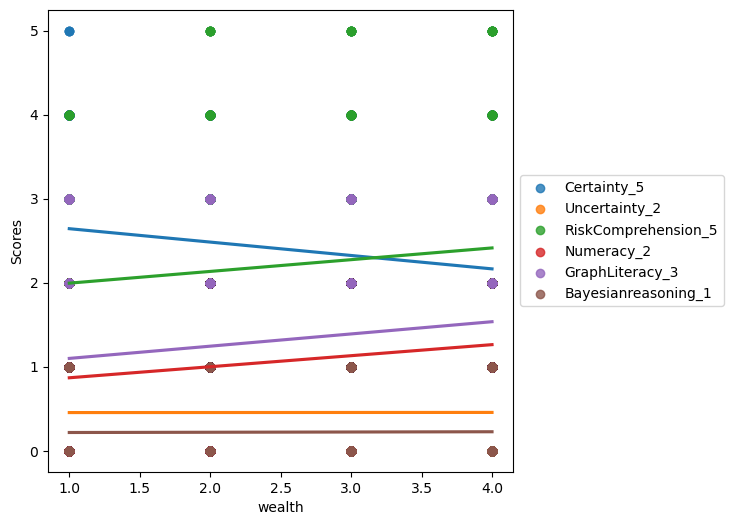

In [113]:
# Trend line for Absolute Independent Facet Score vs Quartiles

fig2, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4, x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax2, label='Certainty_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Uncertainty_2', fit_reg=True, ci=None, ax=ax2, label='Uncertainty_2')
sns.regplot (data = df4, x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax2, label='RiskComprehension_5')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax2, label='Numeracy_2')
sns.regplot (data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax2, label='GraphLiteracy_3')
sns.regplot (data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1',fit_reg=True, ci=None, ax=ax2, label='Bayesianreasoning_1' )

ax2.set(ylabel='Scores', xlabel='wealth')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

<Axes: xlabel='Quartile Number', ylabel='TotalScore_18'>

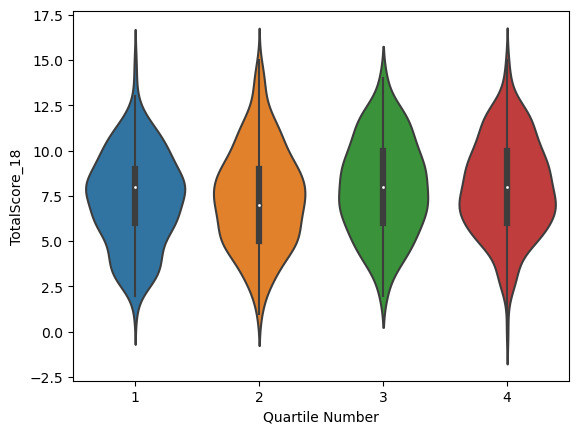

In [114]:
# Violine Plot for TotalScore_18 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'TotalScore_18')

<Axes: xlabel='Quartile Number', ylabel='Certainty_5'>

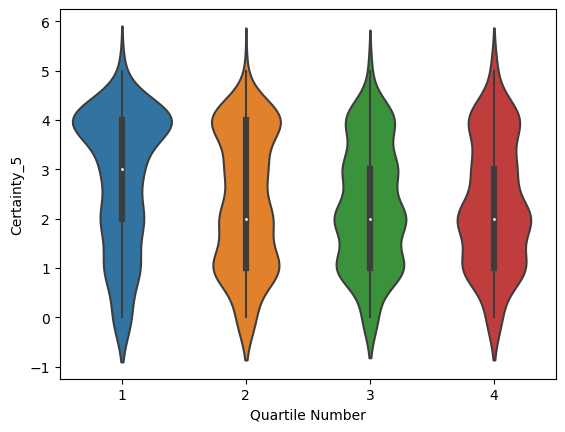

In [115]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Certainty_5')

<Axes: xlabel='Quartile Number', ylabel='Uncertainty_2'>

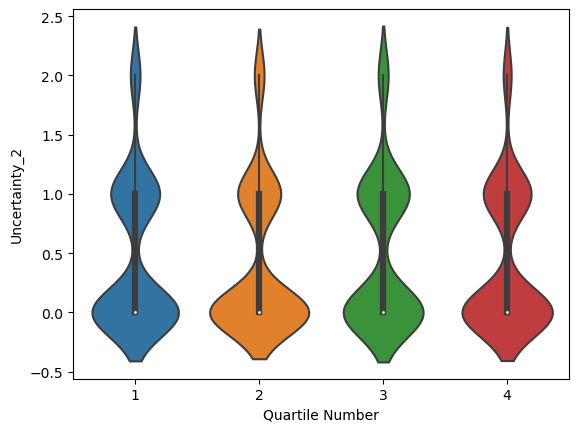

In [116]:
# Violine Plot for Certainty_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Uncertainty_2')

<Axes: xlabel='Quartile Number', ylabel='RiskComprehension_5'>

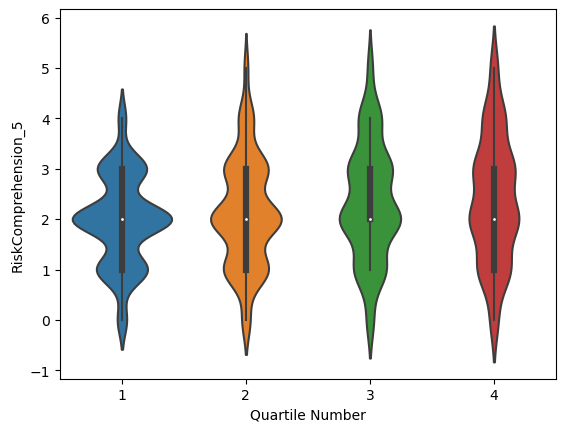

In [117]:
# Violine Plot for RiskComprehension_5 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'RiskComprehension_5')

<Axes: xlabel='Quartile Number', ylabel='GraphLiteracy_3'>

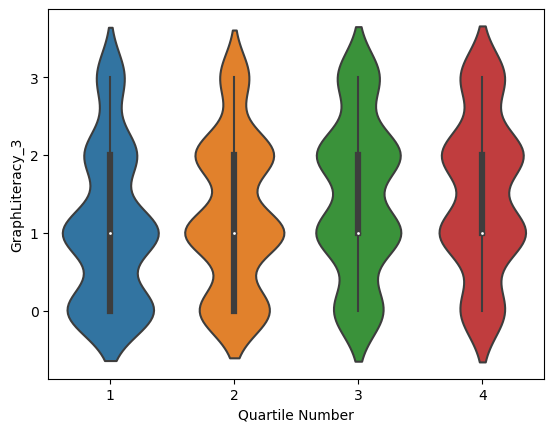

In [118]:
# Violine Plot for GraphLiteracy_3 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'GraphLiteracy_3')

<Axes: xlabel='Quartile Number', ylabel='Numeracy_2'>

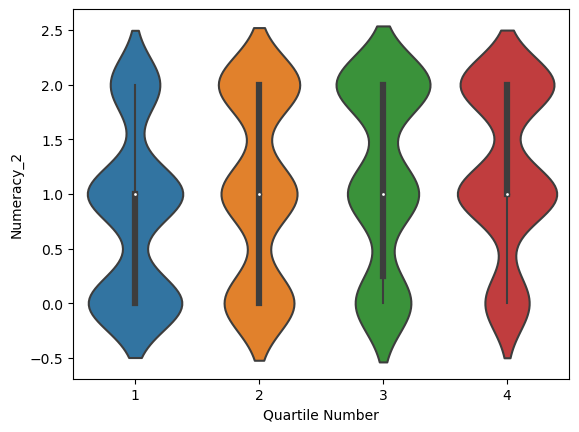

In [119]:
# Violine Plot for Numeracy_2 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Numeracy_2')

<Axes: xlabel='Quartile Number', ylabel='Bayesianreasoning_1'>

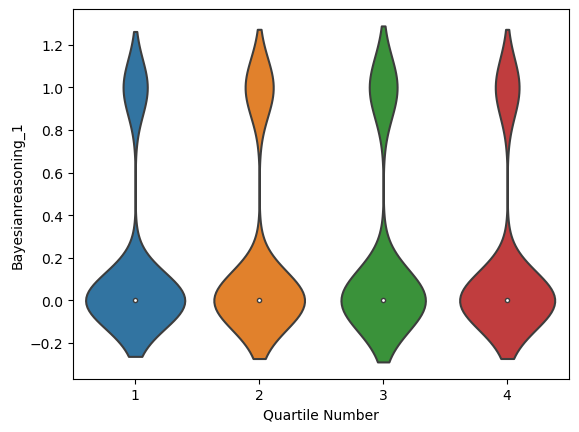

In [120]:
# Violine Plot for Bayesianreasoning_1 for each entry under Wealth Quartiles.

sns.violinplot( data = df4, x = 'Quartile Number', y = 'Bayesianreasoning_1')

### WEALTH vs SCORES w/ ISCED classification

In [121]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df6 = df5.dropna(axis = 0, subset = 'wealth')
# df6.drop(df6[df6['wealth'] == 3500000].index, inplace = True)
df6.loc[df6['isced']==1][['wealth']].describe()

wealth
count  5.310000e+02
mean   1.043356e+07
std    4.024320e+07
min    0.000000e+00
25%    4.000000e+05
50%    1.500000e+06
75%    6.000000e+06
max    5.000000e+08

In [122]:
# Descriptive stats for the data set, isced = 2

df6.loc[df6['isced']==2][['wealth']].describe()

wealth
count  4.170000e+02
mean   9.459245e+06
std    4.913786e+07
min    0.000000e+00
25%    2.000000e+05
50%    6.900000e+05
75%    4.000000e+06
max    6.000000e+08

In [123]:
# Descriptive stats for the data set, isced = 3

df6.loc[df6['isced']==3][['wealth']].describe()

wealth
count  6.500000e+01
mean   3.763119e+06
std    1.307520e+07
min    0.000000e+00
25%    5.000000e+04
50%    2.000000e+05
75%    2.000000e+06
max    1.000000e+08

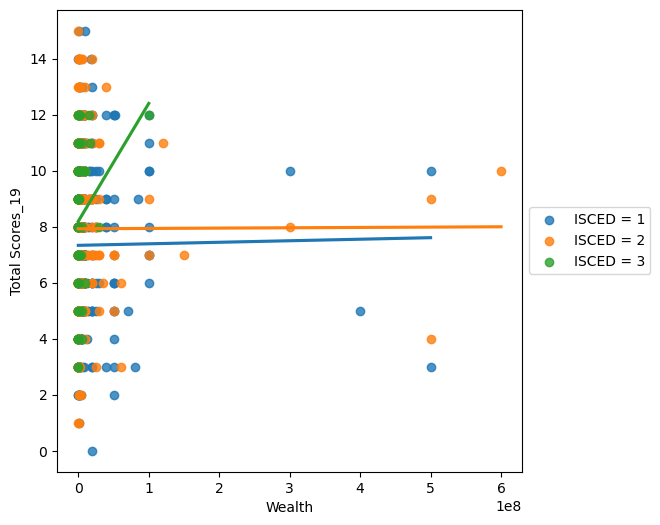

In [124]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='Wealth')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

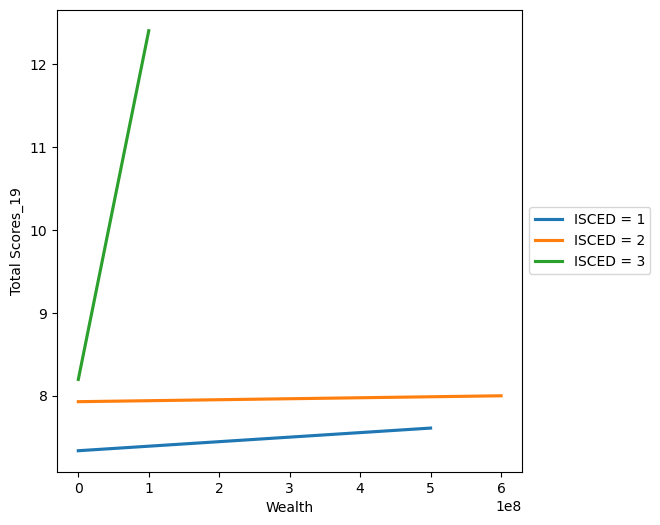

In [125]:
# Trend line for Absolute Tota Facet Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='Wealth')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

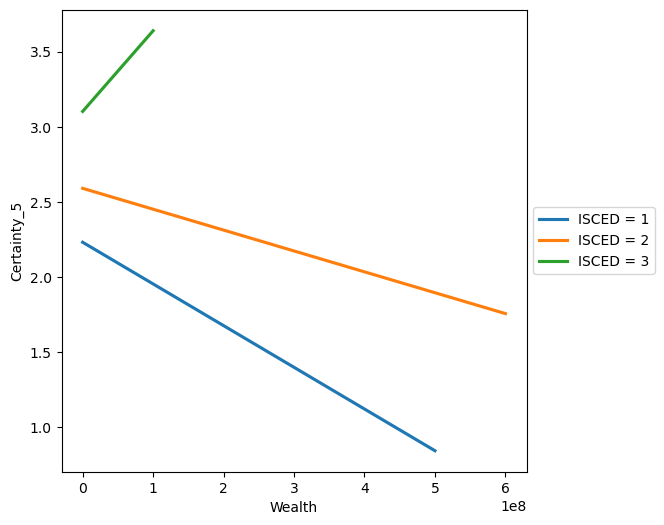

In [126]:
# Trend line for Absolute Certainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='Wealth')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

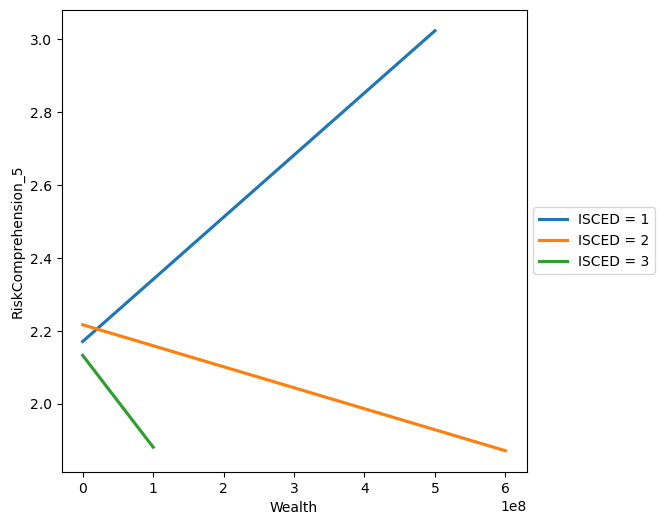

In [127]:
# Trend line for Absolute Uncertainty Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='Wealth')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

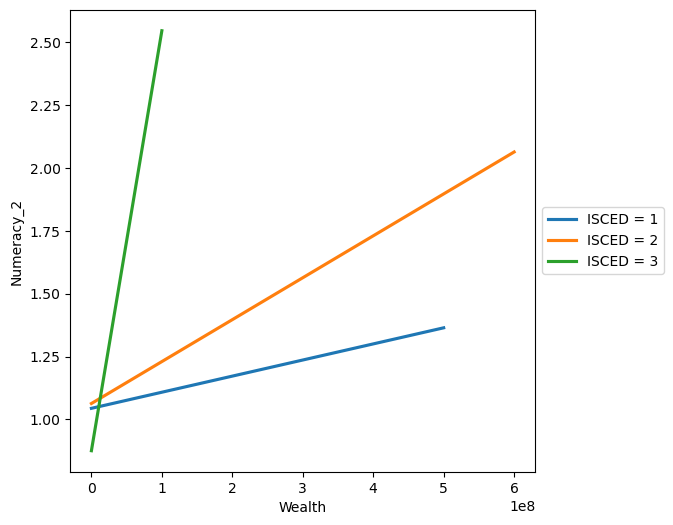

In [128]:
# Trend line for Absolute Number Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_2', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

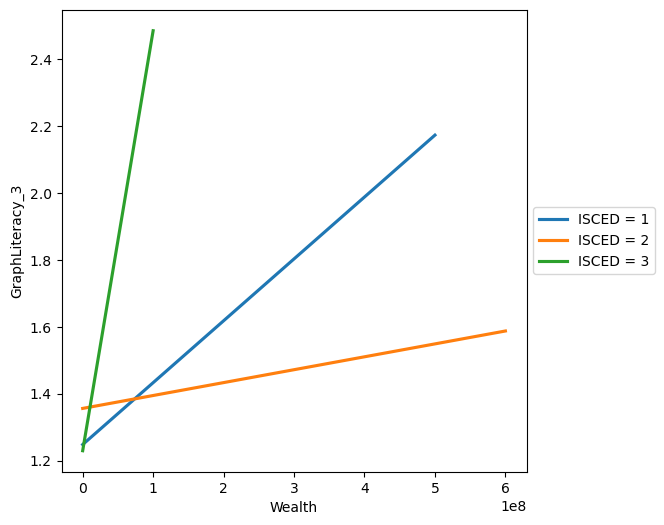

In [129]:
# Trend line for Absolute Graph Comprehension Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='Wealth')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

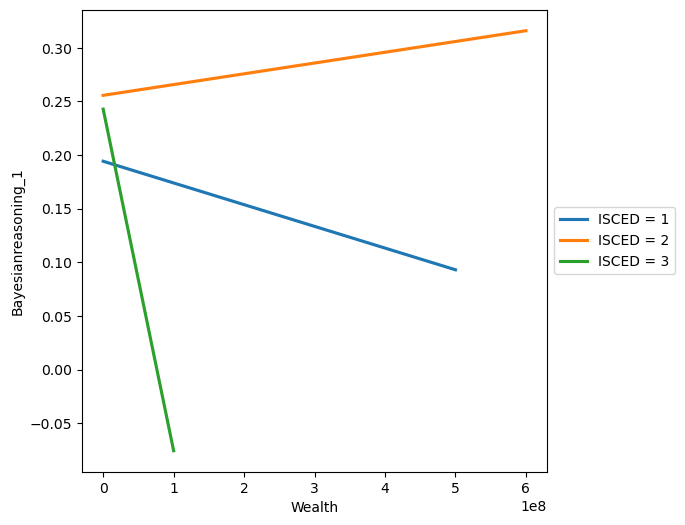

In [130]:
# Trend line for Absolute Bayesian Reasoning Score vs wealth reponses sorted by isced and ORDERED by wealth WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df6.loc[df6['isced']==1].reset_index(drop = True), x = df6.loc[df6['isced']==1].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==2].reset_index(drop = True), x = df6.loc[df6['isced']==2].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df6.loc[df6['isced']==3].reset_index(drop = True), x = df6.loc[df6['isced']==3].reset_index(drop = True)['wealth'], y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='Wealth')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

### WEALTH Quartile Number vs SCORES w/ ISCED and AGE based classification

In [131]:
# Descriptive stats for the data set, isced = 1
# NA values of wealth are removed

df4.loc[df4['isced']==1].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  531.000000  531.000000  531.0  531.000000  5.310000e+02   531.000000   
mean    34.803202    2.425612    1.0    2.448211  1.043356e+07     2.203390   
std      9.256072    0.562695    0.0    1.120416  4.024320e+07     1.290045   
min     18.000000    2.000000    1.0    1.000000  0.000000e+00     0.000000   
25%     30.500000    2.000000    1.0    2.000000  4.000000e+05     1.000000   
50%     30.500000    2.000000    1.0    2.000000  1.500000e+06     2.000000   
75%     40.500000    3.000000    1.0    3.000000  6.000000e+06     3.000000   
max     70.500000    4.000000    1.0    5.000000  5.000000e+08     5.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count     531.000000           531.000000       531.000000  531.000000   
mean        0.438795             2.188324         1.267420    1.050847   
std         0.599938             1.138658         0.965466    0.771701   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             1.000000         1.000000    0.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             5.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           531.000000   531.000000     531.000000           531.000000   
mean              0.192090    44.067797      21.939736            43.766478   
std               0.394315    25.800891      29.996920            22.773165   
min               0.000000     0.000000       0.000000             0.000000   
25%               0.000000    20.000000       0.000000            20.000000   
50%               0.000000    40.000000       0.000000            40.000000   
75%               0.000000    60.000000      50.000000            60.000000   
max               1.000000   100.000000     100.000000           100.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count       531.000000  531.000000           531.000000     531.000000   
mean         42.247332   52.542373            19.209040       7.340866   
std          32.182211   38.585064            39.431522       2.622581   
min           0.000000    0.000000             0.000000       0.000000   
25%          33.333333    0.000000             0.000000       5.500000   
50%          33.333333   50.000000             0.000000       7.000000   
75%          66.666667  100.000000             0.000000       9.000000   
max         100.000000  100.000000           100.000000      15.000000   

       TotalScore_%  Quartile Number  
count    531.000000       531.000000  
mean      40.782591         2.593220  
std       14.569894         1.083439  
min        0.000000         1.000000  
25%       30.555556         2.000000  
50%       38.888889         3.000000  
75%       50.000000         4.000000  
max       83.333333         4.000000

In [132]:
df4.loc[df4['isced']==2].describe()

age     age_rec  isced      income        wealth  Certainty_5  \
count  417.000000  417.000000  417.0  417.000000  4.170000e+02   417.000000   
mean    30.781775    2.263789    2.0    1.896882  9.459245e+06     2.577938   
std      9.887607    0.507120    0.0    1.031436  4.913786e+07     1.335280   
min     18.000000    2.000000    2.0    1.000000  0.000000e+00     0.000000   
25%     22.000000    2.000000    2.0    1.000000  2.000000e+05     1.000000   
50%     30.500000    2.000000    2.0    2.000000  6.900000e+05     3.000000   
75%     34.000000    2.000000    2.0    2.000000  4.000000e+06     4.000000   
max     70.000000    4.000000    2.0    5.000000  6.000000e+08     5.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count     417.000000           417.000000       417.000000  417.000000   
mean        0.443645             2.211031         1.359712    1.079137   
std         0.618088             1.050903         0.997645    0.818048   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             1.000000         1.000000    0.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             5.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           417.000000   417.000000     417.000000           417.000000   
mean              0.256595    51.558753      22.182254            44.220624   
std               0.437278    26.705607      30.904402            21.018061   
min               0.000000     0.000000       0.000000             0.000000   
25%               0.000000    20.000000       0.000000            20.000000   
50%               0.000000    60.000000       0.000000            40.000000   
75%               1.000000    80.000000      50.000000            60.000000   
max               1.000000   100.000000     100.000000           100.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count       417.000000  417.000000           417.000000     417.000000   
mean         45.323741   53.956835            25.659472       7.928058   
std          33.254842   40.902417            43.727842       2.670999   
min           0.000000    0.000000             0.000000       1.000000   
25%          33.333333    0.000000             0.000000       6.000000   
50%          33.333333   50.000000             0.000000       8.000000   
75%          66.666667  100.000000           100.000000      10.000000   
max         100.000000  100.000000           100.000000      15.000000   

       TotalScore_%  Quartile Number  
count    417.000000       417.000000  
mean      44.044764         2.285372  
std       14.838883         1.048168  
min        5.555556         1.000000  
25%       33.333333         1.000000  
50%       44.444444         2.000000  
75%       55.555556         3.000000  
max       83.333333         4.000000

In [133]:
df4.loc[df4['isced']==3].describe()

age    age_rec  isced     income        wealth  Certainty_5  \
count  65.000000  65.000000   65.0  65.000000  6.500000e+01    65.000000   
mean   27.138462   2.230769    3.0   1.661538  3.763119e+06     3.123077   
std    12.124519   0.580119    0.0   1.135739  1.307520e+07     1.192525   
min    16.000000   0.000000    3.0   1.000000  0.000000e+00     1.000000   
25%    19.000000   2.000000    3.0   1.000000  5.000000e+04     2.000000   
50%    21.500000   2.000000    3.0   1.000000  2.000000e+05     4.000000   
75%    30.500000   2.000000    3.0   2.000000  2.000000e+06     4.000000   
max    70.500000   4.000000    3.0   5.000000  1.000000e+08     5.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count      65.000000            65.000000        65.000000   65.000000   
mean        0.661538             2.123077         1.276923    0.938462   
std         0.667947             0.910146         0.976404    0.826834   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             2.000000         0.000000    0.000000   
50%         1.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             4.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            65.000000    65.000000      65.000000            65.000000   
mean              0.230769    62.461538      33.076923            42.461538   
std               0.424604    23.850496      33.397374            18.202916   
min               0.000000    20.000000       0.000000             0.000000   
25%               0.000000    40.000000       0.000000            40.000000   
50%               0.000000    80.000000      50.000000            40.000000   
75%               0.000000    80.000000      50.000000            60.000000   
max               1.000000   100.000000     100.000000            80.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count        65.000000   65.000000            65.000000      65.000000   
mean         42.564103   46.923077            23.076923       8.353846   
std          32.546810   41.341681            42.460389       2.546019   
min           0.000000    0.000000             0.000000       3.000000   
25%           0.000000    0.000000             0.000000       7.000000   
50%          33.333333   50.000000             0.000000       9.000000   
75%          66.666667  100.000000             0.000000      10.000000   
max         100.000000  100.000000           100.000000      12.000000   

       TotalScore_%  Quartile Number  
count     65.000000        65.000000  
mean      46.410256         1.892308  
std       14.144549         1.091488  
min       16.666667         1.000000  
25%       38.888889         1.000000  
50%       50.000000         1.000000  
75%       55.555556         3.000000  
max       66.666667         4.000000

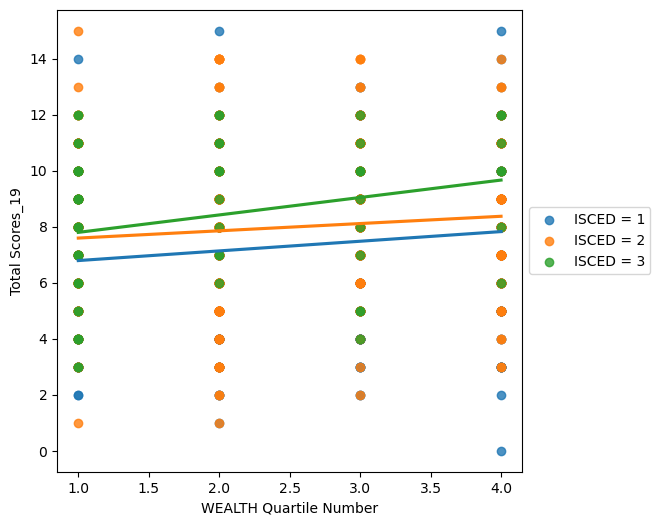

In [134]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITH scatter

fig, ax7 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==1]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 1')
sns.regplot (data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==2]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 2')
sns.regplot (data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[df4['isced']==3]['TotalScore_18'], fit_reg=True, ci=None, ax=ax7, label='ISCED = 3')

ax7.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax7.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

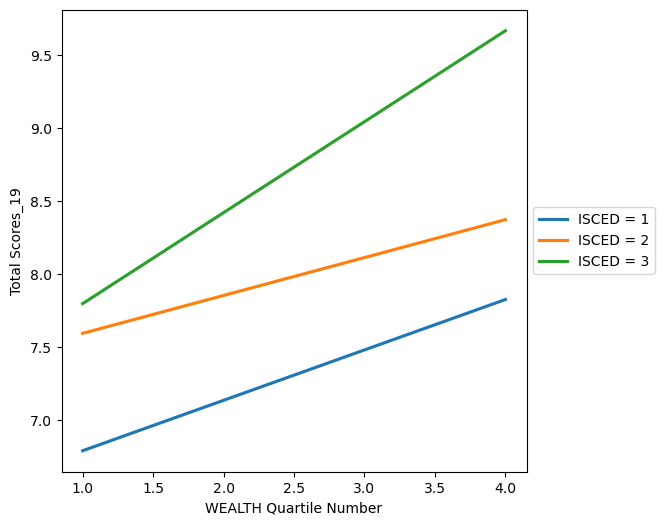

In [135]:
# Trend line for Absolute Tota Facet Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax8 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'TotalScore_18', fit_reg=True, ci=None, ax=ax8, label='ISCED = 3')

ax8.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number')
ax8.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

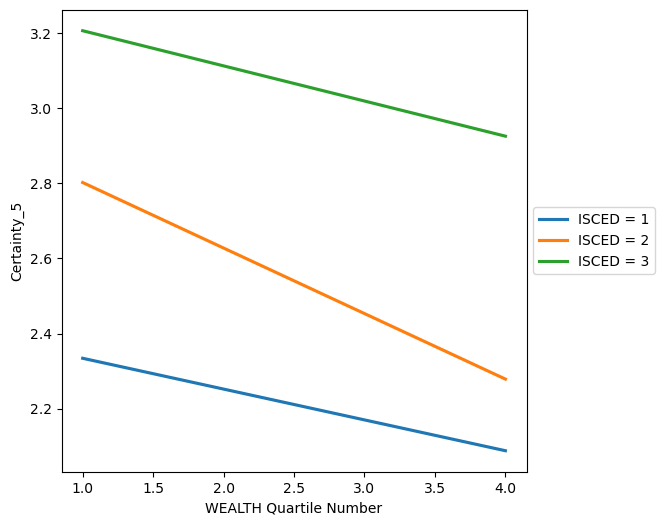

In [136]:
# Trend line for Absolute Certainty Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax9 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Certainty_5', fit_reg=True, ci=None, ax=ax9, label='ISCED = 3')

ax9.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number')
ax9.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

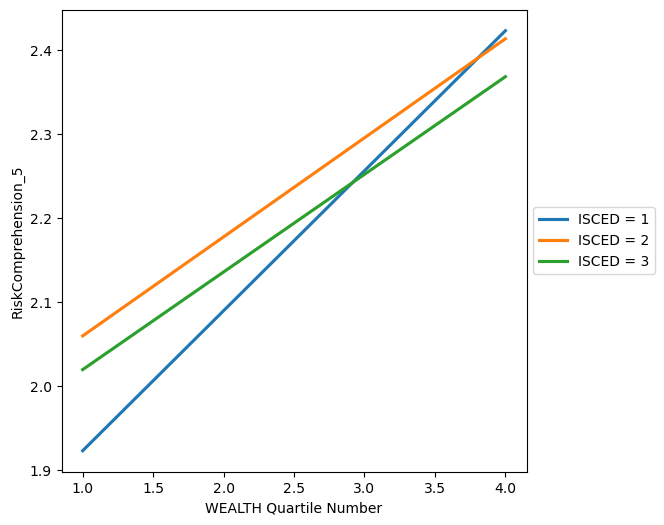

In [137]:
# Trend line for Absolute Risk Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax10 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'RiskComprehension_5', fit_reg=True, ci=None, ax=ax10, label='ISCED = 3')

ax10.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number')
ax10.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

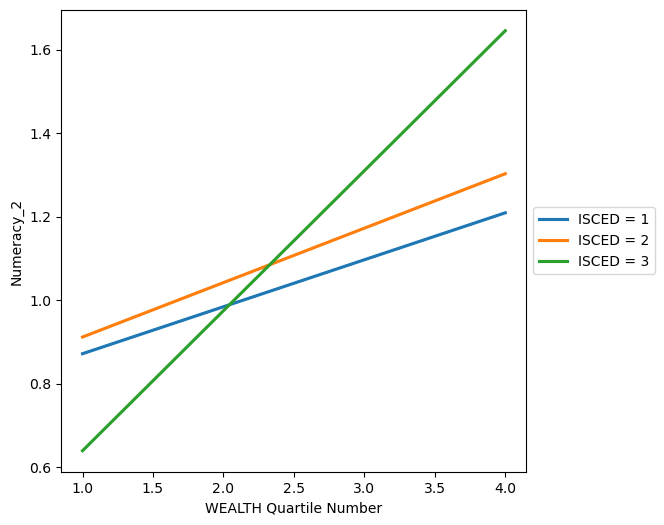

In [138]:
# Trend line for Absolute Number Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Numeracy_2', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

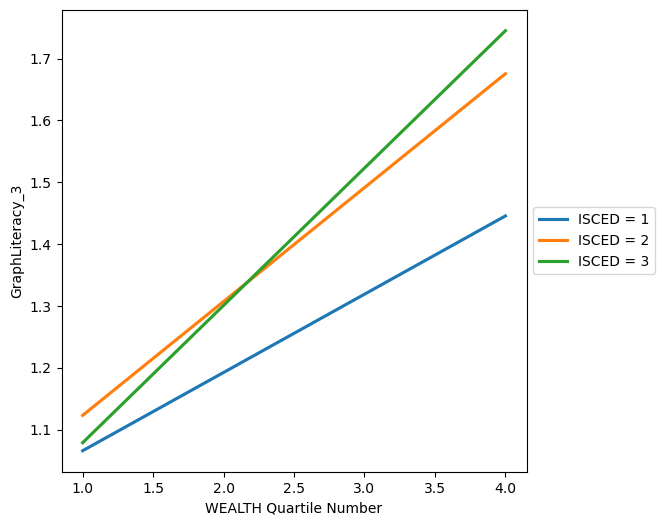

In [139]:
# Trend line for Absolute Graph Comprehension Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax11 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'GraphLiteracy_3', fit_reg=True, ci=None, ax=ax11, label='ISCED = 3')

ax11.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number')
ax11.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

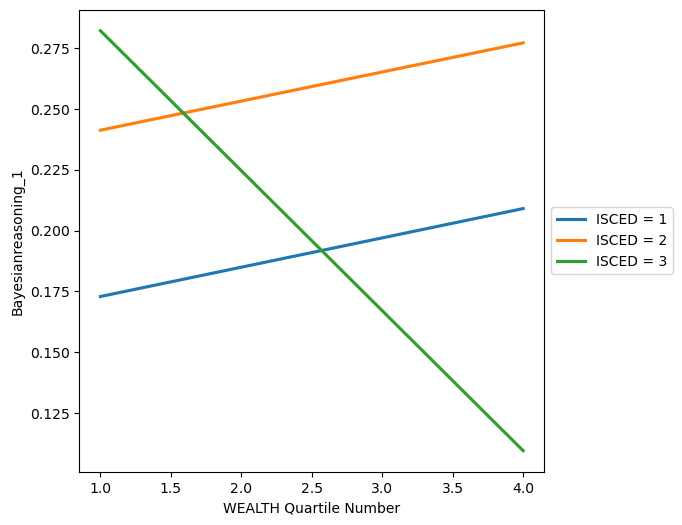

In [140]:
# Trend line for Absolute Bayesian Reasoning Score vs Quartile Number reponses sorted by isced and ORDERED by Quartile Number WITHOUT scatter

fig, ax12 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[df4['isced']==1].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==2].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[df4['isced']==3].reset_index(drop = True), x = 'Quartile Number', y = 'Bayesianreasoning_1', fit_reg=True, ci=None, ax=ax12, label='ISCED = 3')

ax12.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number')
ax12.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

In [141]:
df4

ResponseId   age  age_rec  isced  income  \
0     2rkur9ckjvsyz36zmayz1zw2rkur9ckn  40.5        3      1       3   
1                    R_4DPGUOAP86yO30R  19.0        2      3       1   
2                    R_4fNO2Z5GF8KerZI  24.0        2      2       2   
3                    R_4lnmGavSf6rw1eE  31.0        2      1       1   
4     y139mcxc619h0ooosy139muk14mpfpvm  30.5        2      3       1   
...                                ...   ...      ...    ...     ...   
1008  35zux4sc18rplyz3dc85z35zux4sdfm4  21.5        2      2       4   
1009  wn9mk6m1k8o10l1twn9mk6b4z7l7yvhc  50.5        3      1       3   
1010  4udfypw7lf8mmgjmxr4d4udfym4sx1sf  40.5        3      1       3   
1011  oczyh23wpxpk4o0teoczy5zzzng3i6kk  30.5        2      2       5   
1012  zcj7ldokhyo6217f9sriwizcj7ldodwt  40.5        3      2       3   

           wealth  Certainty_5  Uncertainty_2  RiskComprehension_5  \
0             0.0            3              0                    2   
1             0.0            4              2                    1   
2             0.0            4              0                    4   
3             0.0            1              0                    2   
4             0.0            5              0                    2   
...           ...          ...            ...                  ...   
1008  500000000.0            2              0                    1   
1009  500000000.0            2              0                    3   
1010  500000000.0            0              0                    3   
1011  500000000.0            1              0                    3   
1012  600000000.0            3              1                    2   

      GraphLiteracy_3  Numeracy_2  Bayesianreasoning_1  Certainty_%  \
0                   0           0                    0         60.0   
1                   2           1                    1         80.0   
2                   1           2                    0         80.0   
3                   1           2                    0         20.0   
4                   0           0                    1        100.0   
...               ...         ...                  ...          ...   
1008                0           1                    0         40.0   
1009                3           2                    0         40.0   
1010                0           0                    0          0.0   
1011                3           2                    0         20.0   
1012                1           2                    1         60.0   

      Uncertainty_%  RiskComprehension_%  GraphLiteracy_%  Numeracy_%  \
0               0.0                 40.0         0.000000         0.0   
1             100.0                 20.0        66.666667        50.0   
2               0.0                 80.0        33.333333       100.0   
3               0.0                 40.0        33.333333       100.0   
4               0.0                 40.0         0.000000         0.0   
...             ...                  ...              ...         ...   
1008            0.0                 20.0         0.000000        50.0   
1009            0.0                 60.0       100.000000       100.0   
1010            0.0                 60.0         0.000000         0.0   
1011            0.0                 60.0       100.000000       100.0   
1012           50.0                 40.0        33.333333       100.0   

      Bayesianreasoning_%  TotalScore_18  TotalScore_%  Quartile Number  
0                     0.0              5     27.777778                1  
1                   100.0             11     61.111111                1  
2                     0.0             11     61.111111                1  
3                     0.0              6     33.333333                1  
4                   100.0              8     44.444444                1  
...                   ...            ...           ...              ...  
1008                  0.0              4     22.222222                4  


In [142]:
# Since we already have a classification for Age groups in the form of age_rec, we will use that.
# We will also use median of age to see if it yields any relevant results, as instructed.

# AXES to be used = Age or age groups, ISCED, Income

# Age groups = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 59 y/o
# Age group 4 = 60 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)



In [143]:
df4.loc[(df4['age_rec']==2)].describe()

age  age_rec       isced      income        wealth  Certainty_5  \
count  693.000000    693.0  693.000000  693.000000  6.930000e+02   693.000000   
mean    27.116162      2.0    1.603175    2.059163  7.513477e+06     2.473304   
std      4.547104      0.0    0.617511    1.083624  3.290550e+07     1.350849   
min     18.000000      2.0    1.000000    1.000000  0.000000e+00     0.000000   
25%     22.000000      2.0    1.000000    1.000000  2.000000e+05     1.000000   
50%     30.500000      2.0    2.000000    2.000000  8.000000e+05     2.000000   
75%     30.500000      2.0    2.000000    3.000000  3.500000e+06     4.000000   
max     35.000000      2.0    3.000000    5.000000  5.000000e+08     5.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count     693.000000           693.000000       693.000000  693.000000   
mean        0.458874             2.155844         1.326118    1.057720   
std         0.629338             1.069256         0.978303    0.802535   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             1.000000         1.000000    0.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             5.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            693.00000   693.000000     693.000000           693.000000   
mean               0.23088    49.466089      22.943723            43.116883   
std                0.42170    27.016973      31.466902            21.385112   
min                0.00000     0.000000       0.000000             0.000000   
25%                0.00000    20.000000       0.000000            20.000000   
50%                0.00000    40.000000       0.000000            40.000000   
75%                0.00000    80.000000      50.000000            60.000000   
max                1.00000   100.000000     100.000000           100.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count       693.000000  693.000000           693.000000     693.000000   
mean         44.203944   52.886003            23.088023       7.702742   
std          32.610103   40.126750            42.170032       2.639946   
min           0.000000    0.000000             0.000000       0.000000   
25%          33.333333    0.000000             0.000000       6.000000   
50%          33.333333   50.000000             0.000000       8.000000   
75%          66.666667  100.000000             0.000000      10.000000   
max         100.000000  100.000000           100.000000      15.000000   

       TotalScore_%  Quartile Number  
count    693.000000       693.000000  
mean      42.793009         2.300144  
std       14.666365         1.044923  
min        0.000000         1.000000  
25%       33.333333         1.000000  
50%       44.444444         2.000000  
75%       55.555556         3.000000  
max       83.333333         4.000000

In [144]:
df4.loc[(df4['age_rec']==3)].describe()

age  age_rec       isced      income        wealth  Certainty_5  \
count  285.000000    285.0  285.000000  285.000000  2.850000e+02   285.000000   
mean    42.577193      3.0    1.385965    2.445614  1.463604e+07     2.277193   
std      4.501683      0.0    0.573916    1.166442  6.251005e+07     1.298837   
min     36.000000      3.0    1.000000    1.000000  0.000000e+00     0.000000   
25%     40.500000      3.0    1.000000    2.000000  3.000000e+05     1.000000   
50%     40.500000      3.0    1.000000    2.000000  2.000000e+06     2.000000   
75%     44.000000      3.0    2.000000    3.000000  7.500000e+06     3.000000   
max     54.000000      3.0    3.000000    5.000000  6.000000e+08     5.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count     285.000000           285.000000       285.000000  285.000000   
mean        0.445614             2.266667         1.235088    1.042105   
std         0.576558             1.109710         0.984473    0.781599   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             2.000000         0.000000    0.000000   
50%         0.000000             2.000000         1.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             5.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count           285.000000   285.000000     285.000000           285.000000   
mean              0.196491    45.543860      22.280702            45.333333   
std               0.398043    25.976744      28.827898            22.194192   
min               0.000000     0.000000       0.000000             0.000000   
25%               0.000000    20.000000       0.000000            40.000000   
50%               0.000000    40.000000       0.000000            40.000000   
75%               0.000000    60.000000      50.000000            60.000000   
max               1.000000   100.000000     100.000000           100.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count       285.000000  285.000000           285.000000     285.000000   
mean         41.169591   52.105263            19.649123       7.463158   
std          32.815766   39.079949            39.804315       2.706840   
min           0.000000    0.000000             0.000000       1.000000   
25%           0.000000    0.000000             0.000000       5.000000   
50%          33.333333   50.000000             0.000000       7.000000   
75%          66.666667  100.000000             0.000000       9.000000   
max         100.000000  100.000000           100.000000      15.000000   

       TotalScore_%  Quartile Number  
count    285.000000       285.000000  
mean      41.461988         2.628070  
std       15.038000         1.136116  
min        5.555556         1.000000  
25%       27.777778         2.000000  
50%       38.888889         3.000000  
75%       50.000000         4.000000  
max       83.333333         4.000000

In [145]:
df4.loc[(df4['age_rec']==4)].describe()

age  age_rec      isced     income        wealth  Certainty_5  \
count  34.000000     34.0  34.000000  34.000000  3.400000e+01    34.000000   
mean   62.897059      4.0   1.500000   2.176471  1.032985e+07     2.382353   
std     4.344588      0.0   0.615457   1.217812  1.451734e+07     0.953930   
min    57.000000      4.0   1.000000   1.000000  1.000000e+05     1.000000   
25%    60.500000      4.0   1.000000   1.000000  1.437500e+06     2.000000   
50%    60.500000      4.0   1.000000   2.000000  6.000000e+06     2.000000   
75%    64.250000      4.0   2.000000   2.000000  1.000000e+07     3.000000   
max    70.500000      4.0   3.000000   5.000000  5.250000e+07     4.000000   

       Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  Numeracy_2  \
count      34.000000            34.000000        34.000000   34.000000   
mean        0.441176             2.323529         1.529412    1.117647   
std         0.612554             1.296162         0.928841    0.769286   
min         0.000000             0.000000         0.000000    0.000000   
25%         0.000000             1.000000         1.000000    1.000000   
50%         0.000000             2.000000         2.000000    1.000000   
75%         1.000000             3.000000         2.000000    2.000000   
max         2.000000             5.000000         3.000000    2.000000   

       Bayesianreasoning_1  Certainty_%  Uncertainty_%  RiskComprehension_%  \
count            34.000000    34.000000      34.000000            34.000000   
mean              0.235294    47.647059      22.058824            46.470588   
std               0.430562    19.078597      30.627717            25.923238   
min               0.000000    20.000000       0.000000             0.000000   
25%               0.000000    40.000000       0.000000            20.000000   
50%               0.000000    40.000000       0.000000            40.000000   
75%               0.000000    60.000000      50.000000            60.000000   
max               1.000000    80.000000     100.000000           100.000000   

       GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  TotalScore_18  \
count        34.000000   34.000000            34.000000      34.000000   
mean         50.980392   55.882353            23.529412       8.029412   
std          30.961358   38.464281            43.056155       2.587678   
min           0.000000    0.000000             0.000000       3.000000   
25%          33.333333   50.000000             0.000000       6.000000   
50%          66.666667   50.000000             0.000000       7.500000   
75%          66.666667  100.000000             0.000000      10.000000   
max         100.000000  100.000000           100.000000      13.000000   

       TotalScore_%  Quartile Number  
count     34.000000        34.000000  
mean      44.607843         3.205882  
std       14.375990         0.946426  
min       16.666667         1.000000  
25%       33.333333         3.000000  
50%       41.666667         3.500000  
75%       55.555556         4.000000  
max       72.222222         4.000000

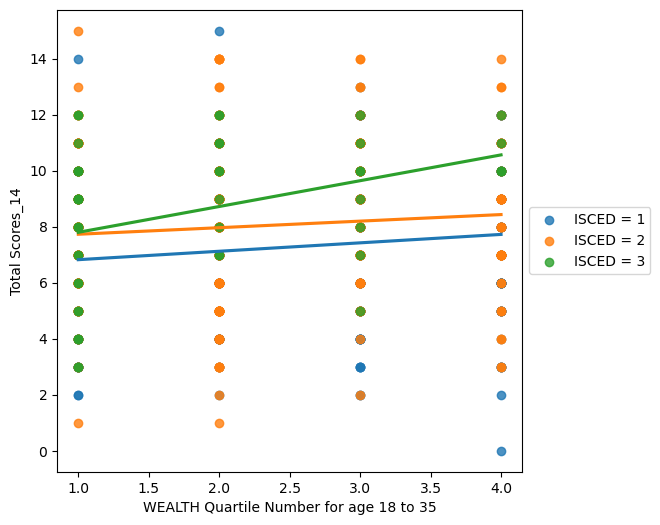

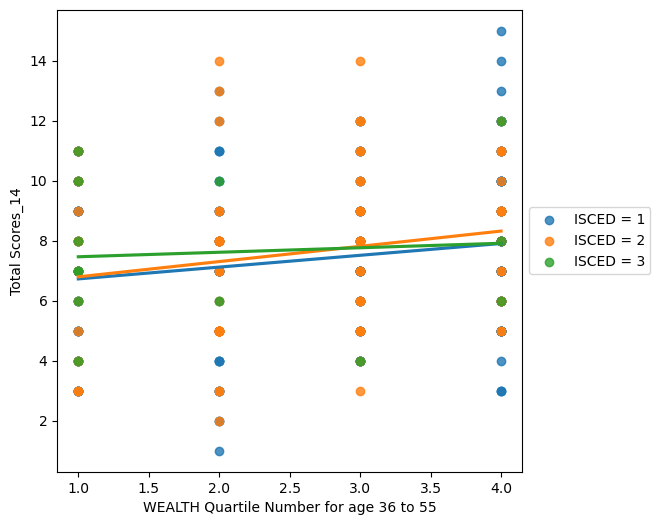

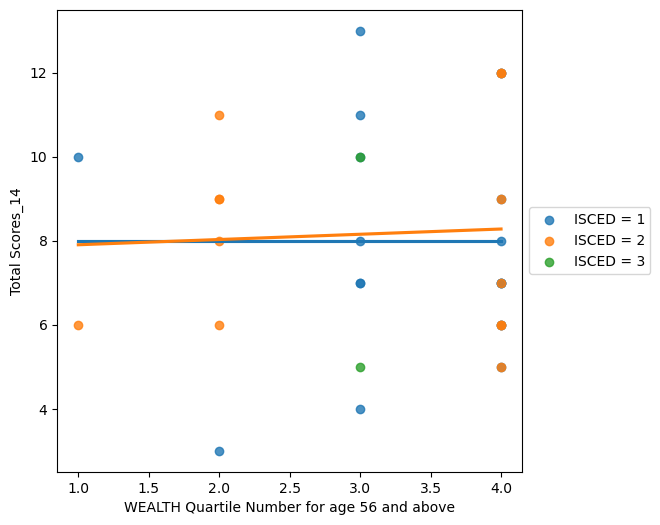

In [146]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above')
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

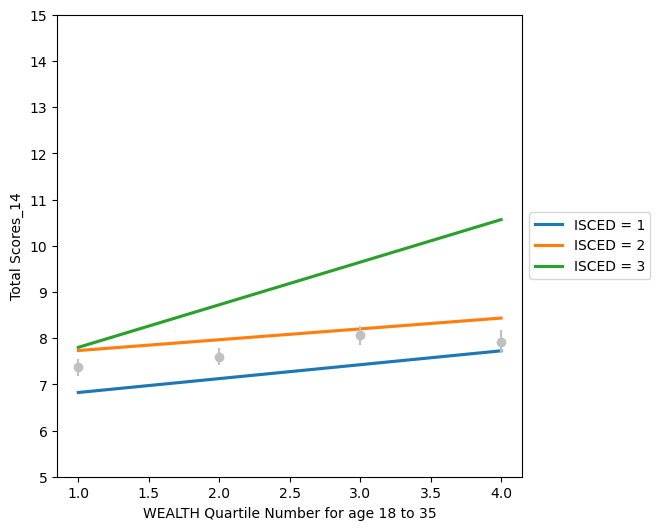

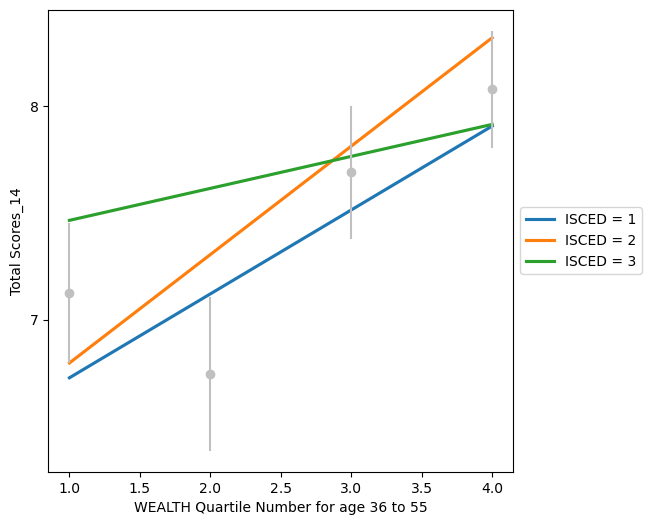

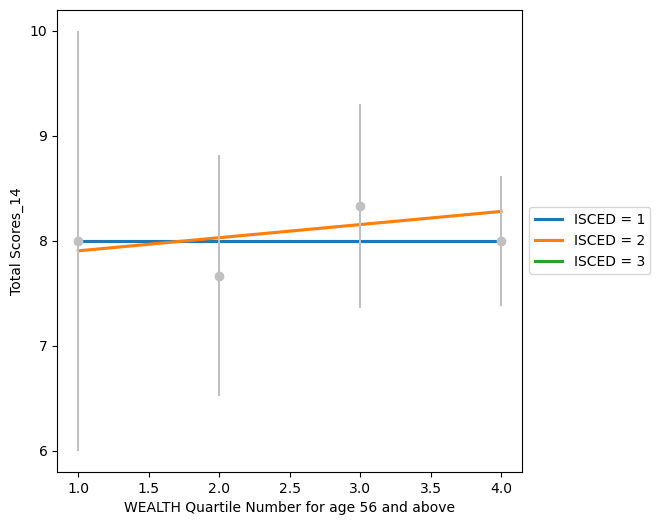

In [147]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_18'], yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_18'], yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Total Scores_14', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(5, 16 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number']).mean(numeric_only=True)['TotalScore_18'], yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

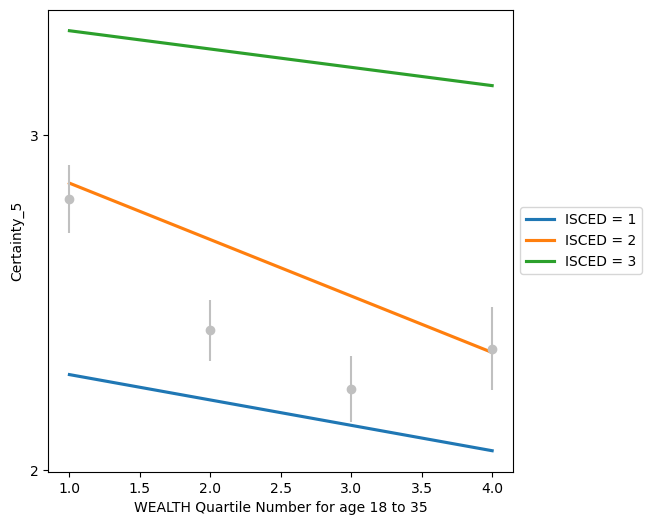

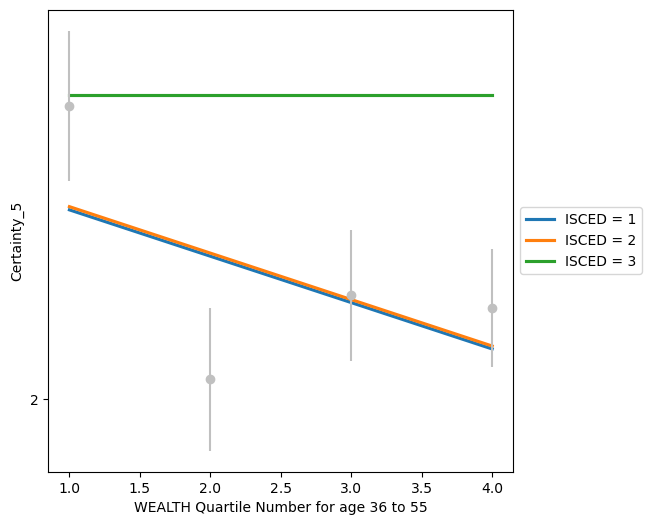

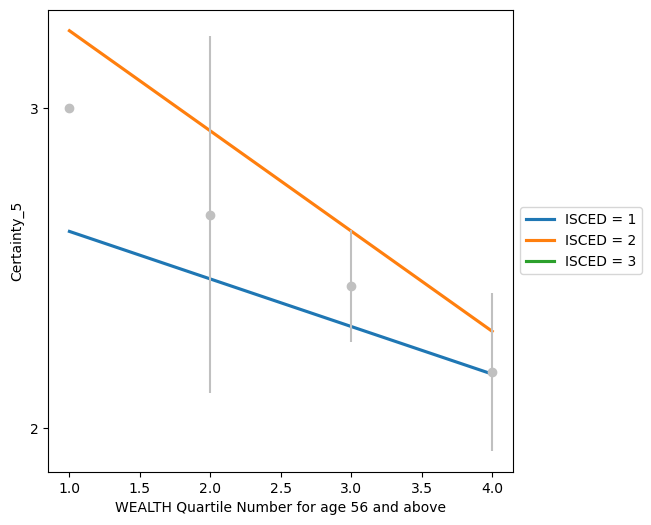

In [148]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

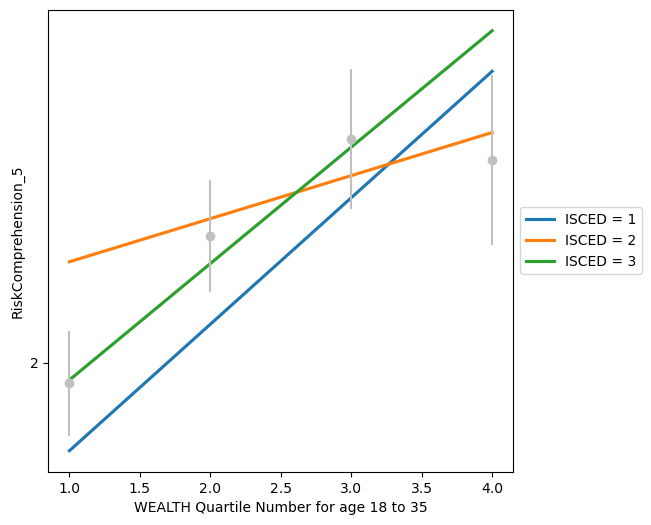

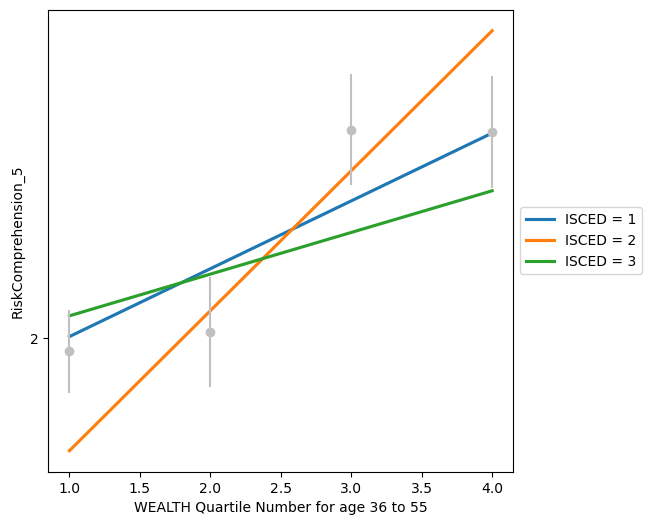

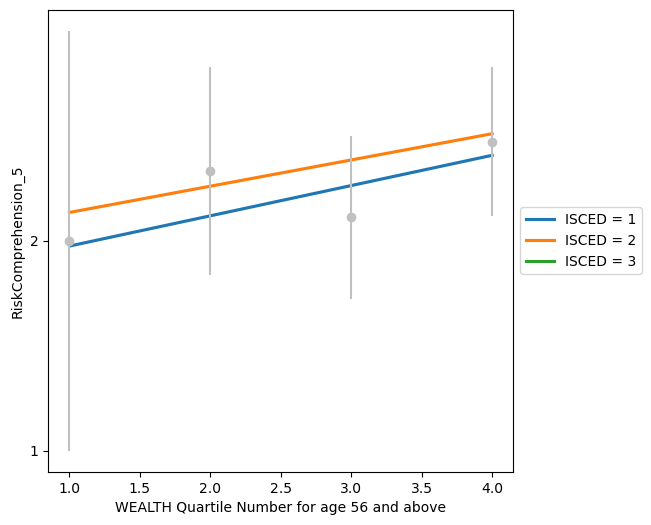

In [149]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 3 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

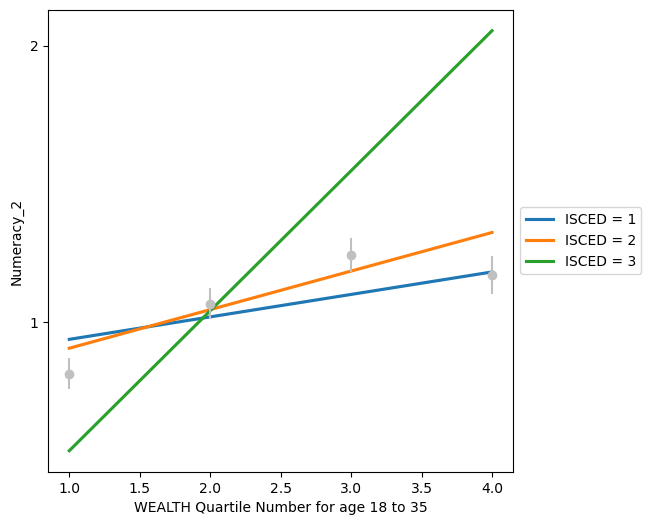

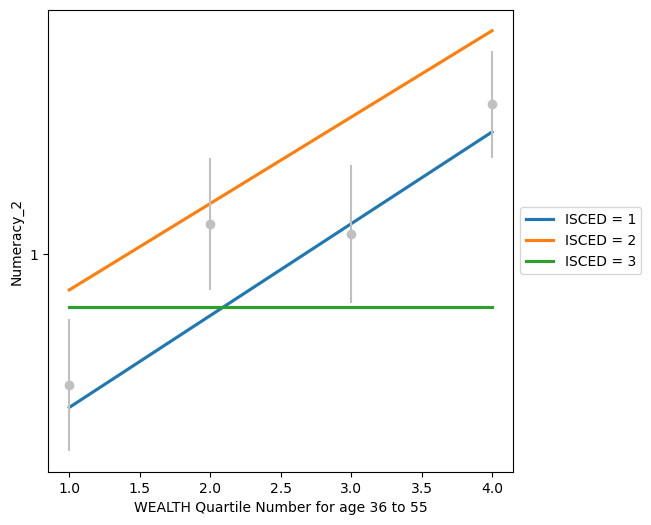

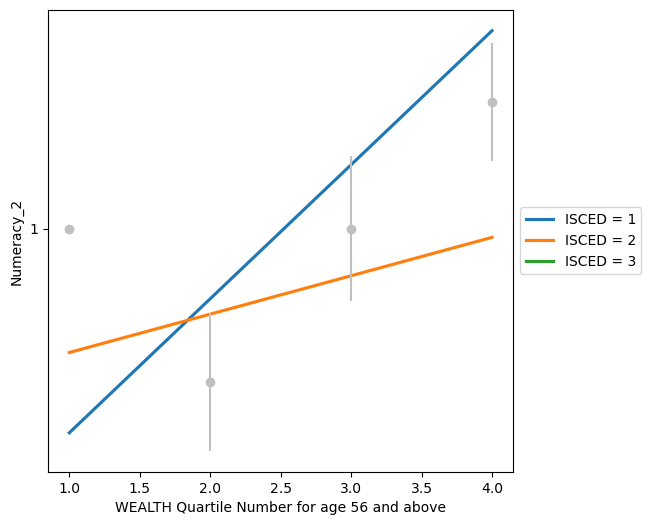

In [150]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Numeracy_2'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Numeracy_2'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 6 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Numeracy_2'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

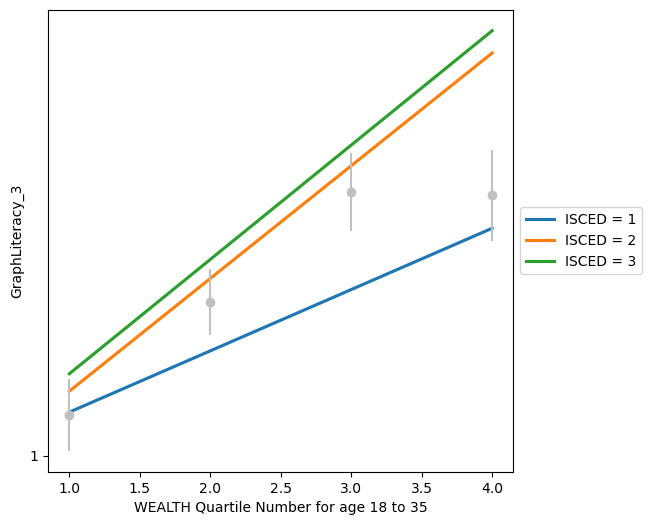

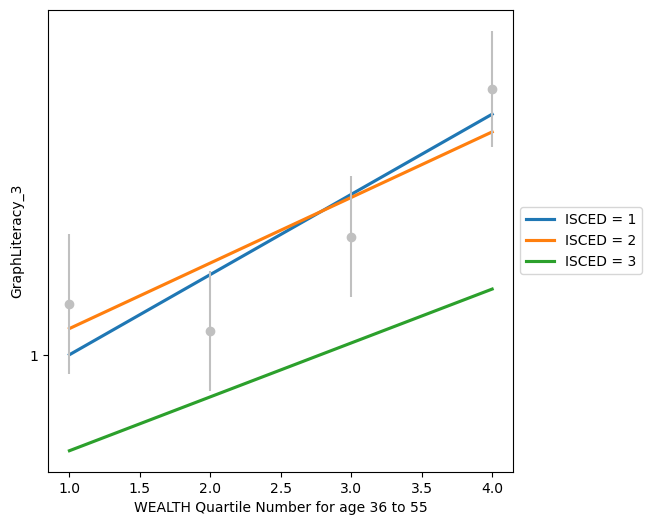

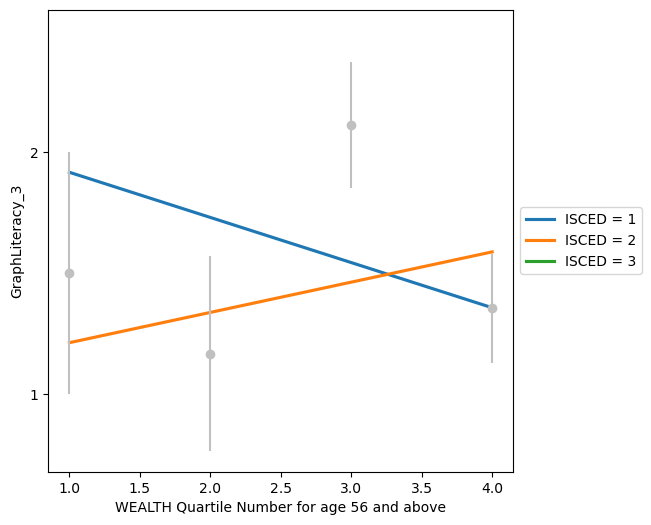

In [151]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 36 to 55',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 4 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

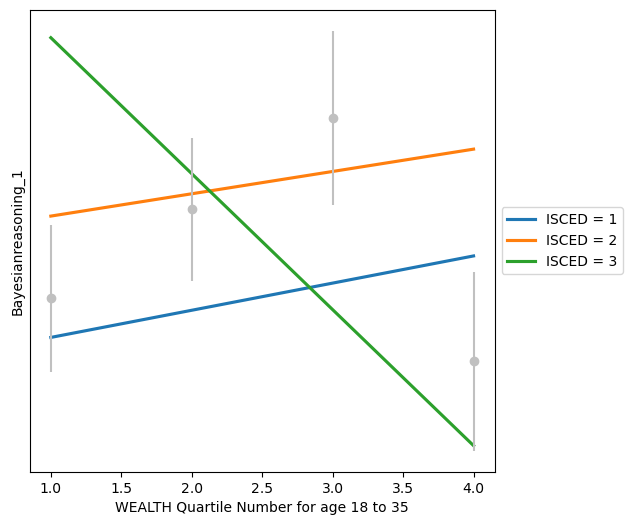

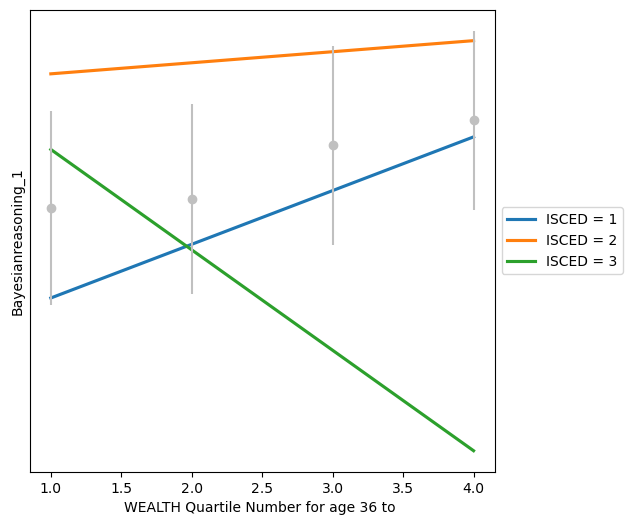

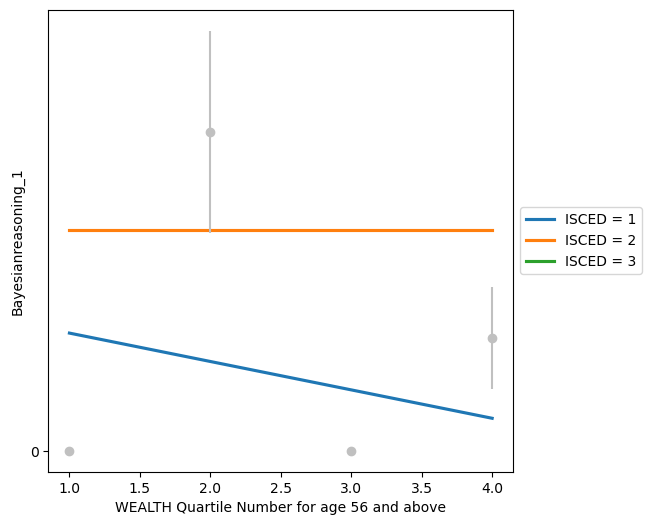

In [152]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==2) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 18 to 35',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax1.errorbar(x = df4.loc[ df4['age_rec']==2  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==2  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==2) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==3) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 36 to ',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax2.errorbar(x = df4.loc[ df4['age_rec']==3  ]["Quartile Number"].unique(), y = df4.loc[ df4['age_rec']==3  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==3) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

fig, ax3 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age_rec']==4) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax3, label='ISCED = 3')

ax3.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for age 56 and above',  yticks = np.arange(0, 5 , 1))
ax3.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax3.errorbar(x = df4.loc[ df4['age_rec']== 4 ]['Quartile Number'].unique(), y = df4.loc[ df4['age_rec']==4  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age_rec']==4) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
plt.show()

In [153]:
# Age mean method
# Age_mean

In [154]:
age_m = df2["age"].median()
age_m

30.5

In [155]:
df4["Quartile Number"].value_counts()

Quartile Number
2    296
1    255
3    242
4    220
Name: count, dtype: int64

In [156]:
df4.loc[(df4['age'] < age_m)].describe()

age     age_rec       isced      income        wealth  \
count  338.000000  338.000000  338.000000  338.000000  3.380000e+02   
mean    23.139053    1.994083    1.837278    1.825444  7.068495e+06   
std      3.331116    0.108786    0.630694    1.037432  3.523029e+07   
min     16.000000    0.000000    1.000000    1.000000  0.000000e+00   
25%     21.500000    2.000000    1.000000    1.000000  1.000000e+05   
50%     21.500000    2.000000    2.000000    2.000000  5.000000e+05   
75%     26.000000    2.000000    2.000000    2.000000  2.000000e+06   
max     30.000000    2.000000    3.000000    5.000000  5.000000e+08   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   338.000000     338.000000           338.000000       338.000000   
mean      2.970414       0.520710             2.183432         1.423077   
std       1.253723       0.659005             0.987499         0.981279   
min       0.000000       0.000000             0.000000         0.000000   
25%       2.000000       0.000000             2.000000         1.000000   
50%       4.000000       0.000000             2.000000         1.000000   
75%       4.000000       1.000000             3.000000         2.000000   
max       4.000000       2.000000             5.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  338.000000           338.000000   338.000000     338.000000   
mean     1.136095             0.257396    59.408284      26.035503   
std      0.800111             0.437848    25.074468      32.950263   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    40.000000       0.000000   
50%      1.000000             0.000000    80.000000       0.000000   
75%      2.000000             1.000000    80.000000      50.000000   
max      2.000000             1.000000    80.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           338.000000       338.000000  338.000000           338.000000   
mean             43.668639        47.435897   56.804734            25.739645   
std              19.749987        32.709292   40.005530            43.784781   
min               0.000000         0.000000    0.000000             0.000000   
25%              40.000000        33.333333    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              60.000000        66.666667  100.000000           100.000000   
max             100.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  Quartile Number  
count     338.000000    338.000000       338.000000  
mean        8.491124     47.172913         2.071006  
std         2.547165     14.150919         1.019536  
min         2.000000     11.111111         1.000000  
25%         7.000000     38.888889         1.000000  
50%         9.000000     50.000000         2.000000  
75%        10.000000     55.555556         3.000000  
max        15.000000     83.333333         4.000000

In [157]:
df4.loc[(df4['age'] >= age_m)].describe()

age     age_rec       isced      income        wealth  \
count  675.000000  675.000000  675.000000  675.000000  6.750000e+02   
mean    37.421481    2.522963    1.391111    2.343704  1.087433e+07   
std      8.757857    0.592227    0.548462    1.127128  4.645892e+07   
min     30.500000    2.000000    1.000000    1.000000  0.000000e+00   
25%     30.500000    2.000000    1.000000    2.000000  3.775000e+05   
50%     34.000000    2.000000    1.000000    2.000000  1.500000e+06   
75%     40.500000    3.000000    2.000000    3.000000  6.000000e+06   
max     70.500000    4.000000    3.000000    5.000000  6.000000e+08   

       Certainty_5  Uncertainty_2  RiskComprehension_5  GraphLiteracy_3  \
count   675.000000     675.000000           675.000000       675.000000   
mean      2.139259       0.422222             2.198519         1.247407   
std       1.275720       0.587540             1.137047         0.974210   
min       0.000000       0.000000             0.000000         0.000000   
25%       1.000000       0.000000             1.000000         0.000000   
50%       2.000000       0.000000             2.000000         1.000000   
75%       3.000000       1.000000             3.000000         2.000000   
max       5.000000       2.000000             5.000000         3.000000   

       Numeracy_2  Bayesianreasoning_1  Certainty_%  Uncertainty_%  \
count  675.000000           675.000000   675.000000     675.000000   
mean     1.014815             0.202963    42.785185      21.111111   
std      0.789256             0.402503    25.514407      29.376979   
min      0.000000             0.000000     0.000000       0.000000   
25%      0.000000             0.000000    20.000000       0.000000   
50%      1.000000             0.000000    40.000000       0.000000   
75%      2.000000             0.000000    60.000000      50.000000   
max      2.000000             1.000000   100.000000     100.000000   

       RiskComprehension_%  GraphLiteracy_%  Numeracy_%  Bayesianreasoning_%  \
count           675.000000       675.000000  675.000000           675.000000   
mean             43.970370        41.580247   50.740741            20.296296   
std              22.740942        32.473656   39.462818            40.250343   
min               0.000000         0.000000    0.000000             0.000000   
25%              20.000000         0.000000    0.000000             0.000000   
50%              40.000000        33.333333   50.000000             0.000000   
75%              60.000000        66.666667  100.000000             0.000000   
max             100.000000       100.000000  100.000000           100.000000   

       TotalScore_18  TotalScore_%  Quartile Number  
count     675.000000    675.000000       675.000000  
mean        7.225185     40.139918         2.597037  
std         2.611255     14.506972         1.078791  
min         0.000000      0.000000         1.000000  
25%         5.000000     27.777778         2.000000  
50%         7.000000     38.888889         3.000000  
75%         9.000000     50.000000         4.000000  
max        15.000000     83.333333         4.000000

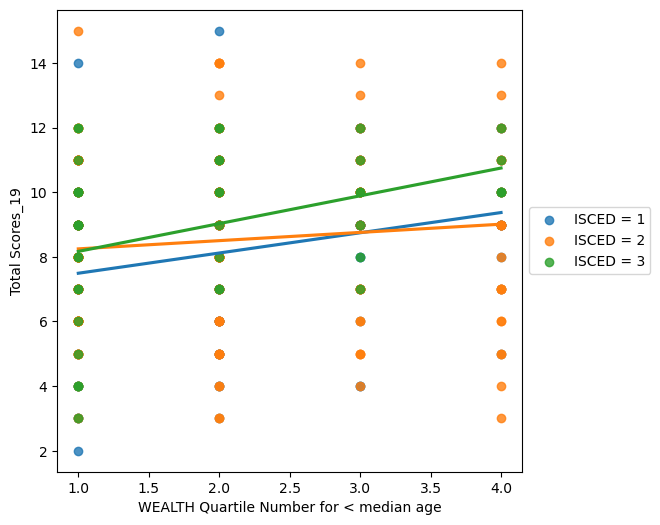

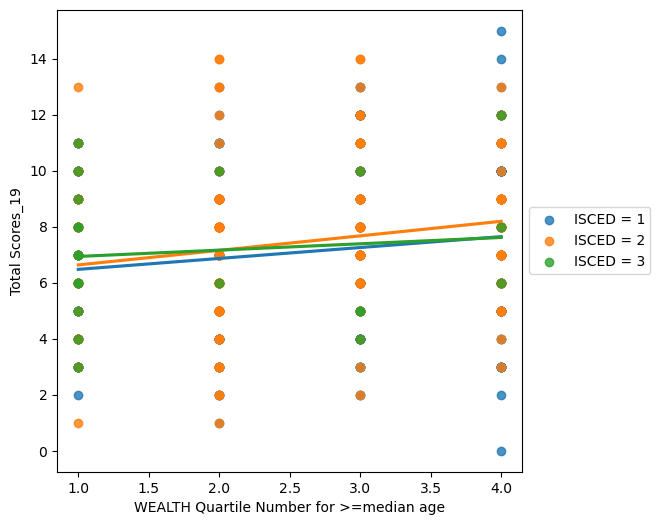

In [158]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age')
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (data = df4.loc[(df4['age'] >= age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

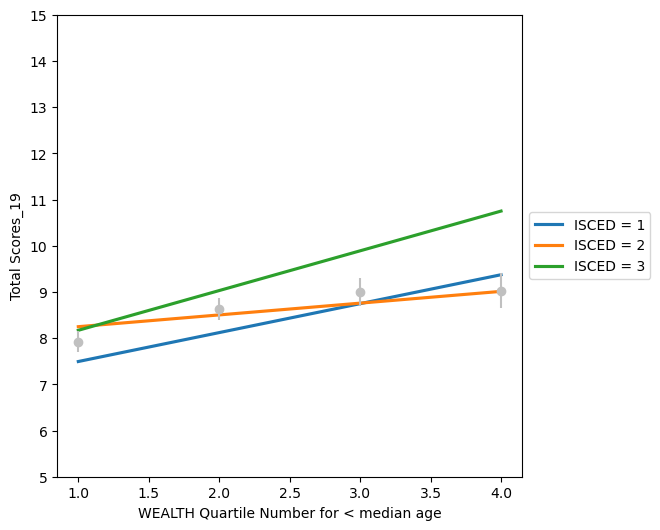

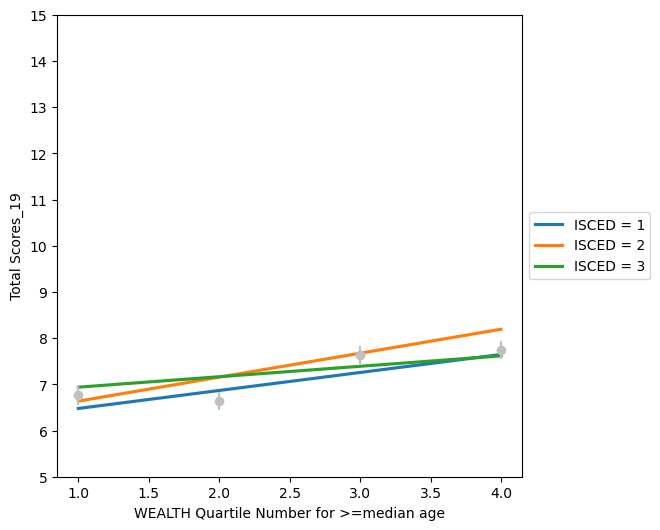

In [159]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['TotalScore_18'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(5, 16 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['TotalScore_18'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['TotalScore_18'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['TotalScore_18'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Total Scores_19', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(5, 16 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

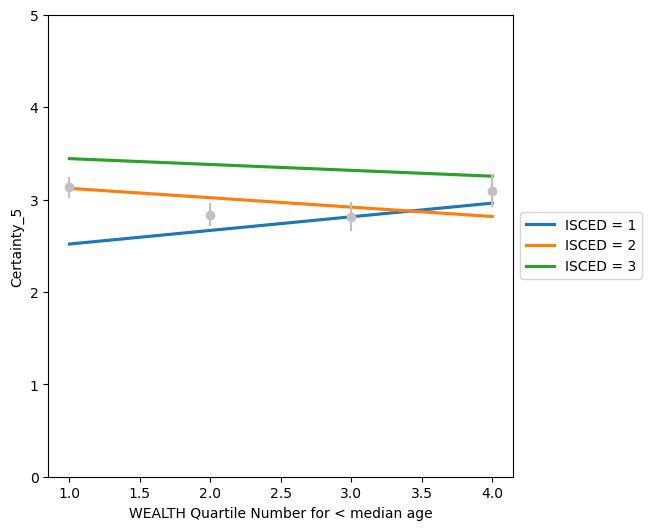

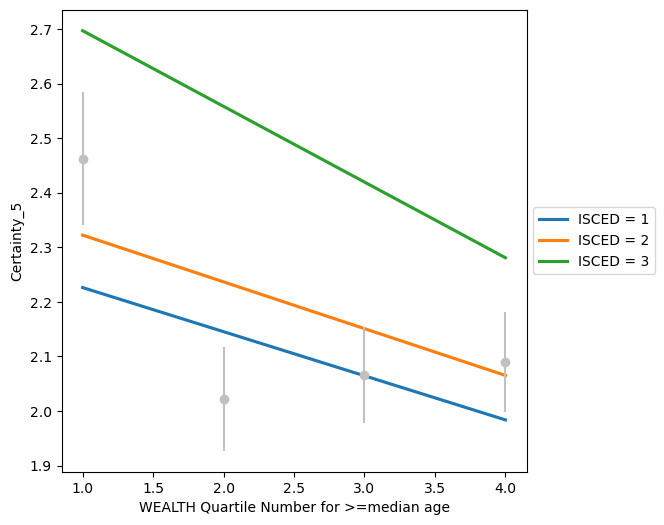

In [160]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Certainty_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Certainty_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Certainty_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Certainty_5', xlabel='WEALTH Quartile Number for >=median age')
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

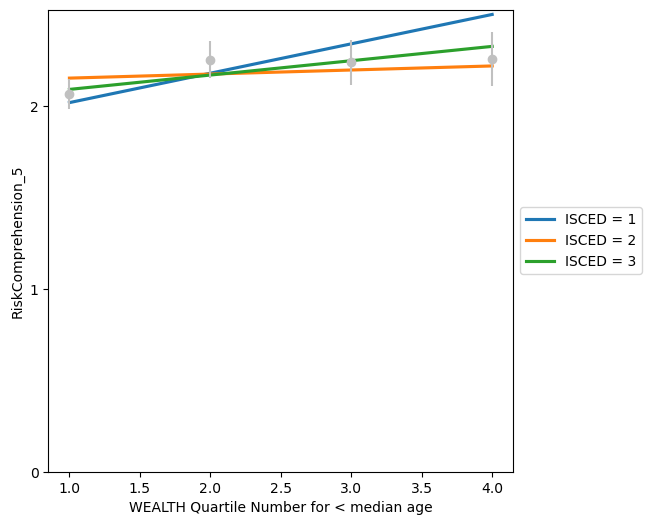

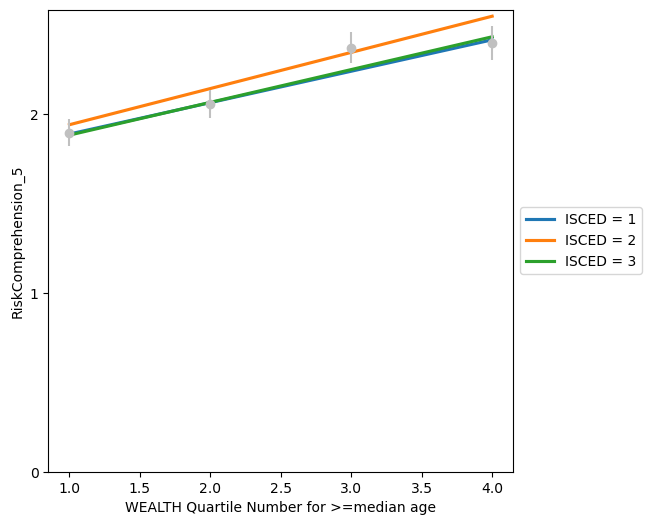

In [161]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 3 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['RiskComprehension_5'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['RiskComprehension_5'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['RiskComprehension_5'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='RiskComprehension_5', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 3 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

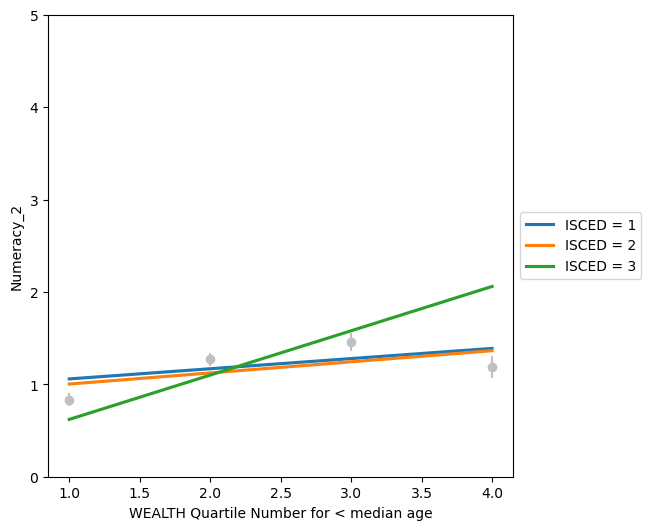

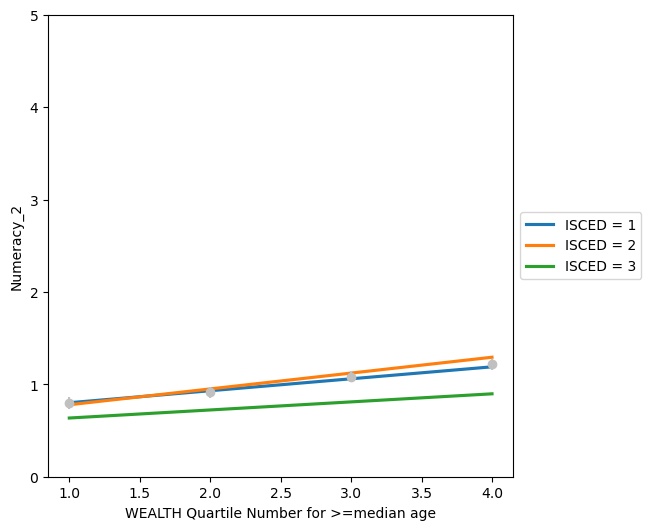

In [162]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Numeracy_2'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 6 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Numeracy_2'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Numeracy_2'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Numeracy_2'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Numeracy_2', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 6 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

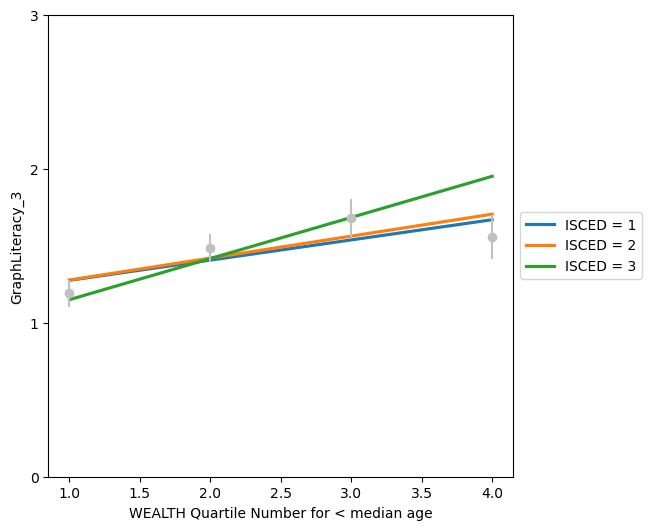

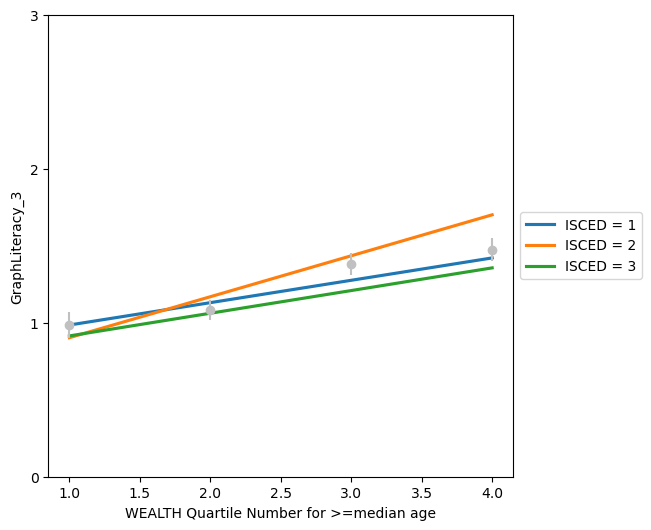

In [163]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 4 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['GraphLiteracy_3'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['GraphLiteracy_3'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['GraphLiteracy_3'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='GraphLiteracy_3', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 4 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

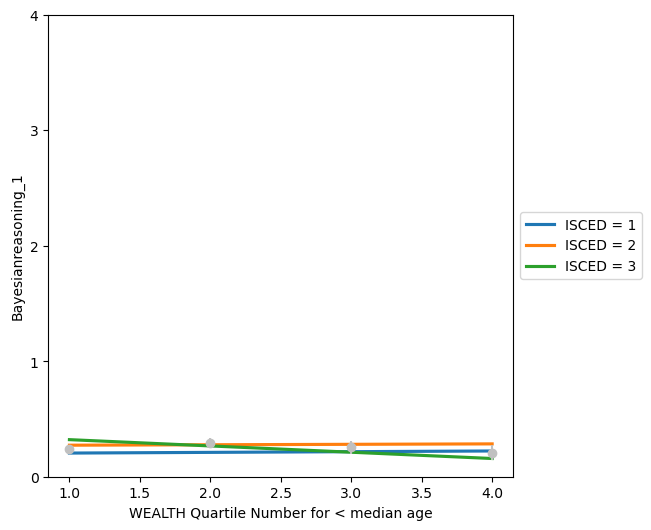

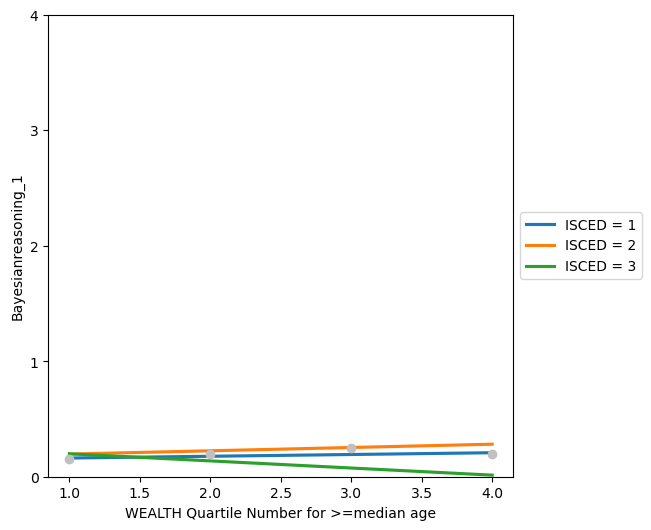

In [164]:
fig, ax1 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] < age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax1, label='ISCED = 3')

ax1.errorbar(x = df4.loc[ (df4['age'] < age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] < age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] < age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax1.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for < median age',  yticks = np.arange(0, 5 , 1))
ax1.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()

fig, ax2 = plt.subplots(figsize=(6, 6))

sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==1)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 1')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==2)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 2')
sns.regplot (scatter = False, data = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)].reset_index(drop = True), x = 'Quartile Number', y = df4.loc[(df4['age'] >=age_m) & (df4['isced']==3)]['Bayesianreasoning_1'], fit_reg=True, ci=None, ax=ax2, label='ISCED = 3')

ax2.errorbar(x = df4.loc[ (df4['age'] >= age_m)  ]["Quartile Number"].unique(), y = df4.loc[ (df4['age'] >=age_m)  ].groupby(['Quartile Number'])['Bayesianreasoning_1'].mean(), yerr = df4.loc[ (df4['age'] >=age_m) ].groupby(['Quartile Number'])['Bayesianreasoning_1'].sem(), fmt='o', color = lighten_color('gray',0.5))
ax2.set(ylabel='Bayesianreasoning_1', xlabel='WEALTH Quartile Number for >=median age',  yticks = np.arange(0, 5 , 1))
ax2.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.show()